In [ ]:
# ============================================================
# CELL 01 — DATASET LOAD (QEvasion)
# ============================================================

!pip -q install datasets transformers scikit-learn tqdm

from datasets import load_dataset

# Load dataset (single source of truth)
ds = load_dataset("ailsntua/QEvasion")

train_ds = ds["train"]
test_ds  = ds["test"]

# Basic sanity checks
print("train size:", len(train_ds))
print("test size :", len(test_ds))

print("\nColumns:", train_ds.column_names)

print("\n--- Example (train[0]) ---")
print("Q:", train_ds[0]["question"][:200])
print("A:", train_ds[0]["interview_answer"][:200])
print("clarity:", train_ds[0]["clarity_label"])
print("evasion:", train_ds[0]["evasion_label"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.90M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/259k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3448 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/308 [00:00<?, ? examples/s]

train size: 3448
test size : 308

Columns: ['title', 'date', 'president', 'url', 'question_order', 'interview_question', 'interview_answer', 'gpt3.5_summary', 'gpt3.5_prediction', 'question', 'annotator_id', 'annotator1', 'annotator2', 'annotator3', 'inaudible', 'multiple_questions', 'affirmative_questions', 'index', 'clarity_label', 'evasion_label']

--- Example (train[0]) ---
Q: How would you respond to the accusation that the United States is containing China while pushing for diplomatic talks?
A: Well, look, first of all, theI am sincere about getting the relationship right. And one of the things that is going on now is, China is beginning to change some of the rules of the game, in terms of t
clarity: Clear Reply
evasion: Explicit


Data Analysis through the empty evasion rows, majority voting

In [ ]:
# 1) "Boş label" nedir?
# None ise boş kabul ediyoruz.
# String ise strip() sonrası "" ise boş kabul ediyoruz.

def empty_indices(ds, col):
    vals = ds[col]  # dataset kolonu -> liste gibi
    idx = []        # boş olanların index'lerini burada toplayacağız
    for i, x in enumerate(vals):               # (index, değer)
        if (x is None) or (str(x).strip() == ""):  # boş mu?
            idx.append(i)
    return idx

# 2) Clarity ve Evasion için boş index listeleri
train_empty_clarity = empty_indices(train_ds, "clarity_label")
test_empty_clarity  = empty_indices(test_ds,  "clarity_label")

train_empty_evasion = empty_indices(train_ds, "evasion_label")
test_empty_evasion  = empty_indices(test_ds,  "evasion_label")

# 3) Sayıları yazdır
print("TRAIN empty clarity_label:", len(train_empty_clarity), "first:", train_empty_clarity[:10])
print("TEST  empty clarity_label:", len(test_empty_clarity),  "first:", test_empty_clarity[:10])

print("TRAIN empty evasion_label:", len(train_empty_evasion), "first:", train_empty_evasion[:10])
print("TEST  empty evasion_label:", len(test_empty_evasion),  "first:", test_empty_evasion[:10])

# 4) Test'te boş evasion varsa örnek göster (en faydalısı bu)
if len(test_empty_evasion) > 0:
    i = test_empty_evasion[0]
    print("\nExample empty evasion in TEST:")
    print("question:", test_ds[i]["question"])
    print("answer:", test_ds[i]["interview_answer"])
    print("clarity_label:", repr(test_ds[i]["clarity_label"]))
    print("evasion_label:", repr(test_ds[i]["evasion_label"]))


TRAIN empty clarity_label: 0 first: []
TEST  empty clarity_label: 0 first: []
TRAIN empty evasion_label: 0 first: []
TEST  empty evasion_label: 308 first: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Example empty evasion in TEST:
question:  Inquiring about the status or information regarding the redline.
answer: Well, the world has made it clear that these tests caused us to come together and work in the United Nations to send a clear message to the North Korean regime. We're bound up together with a common strategy to solve this issue peacefully through diplomatic means.Kevin [Kevin Corke, NBC News].
clarity_label: 'Ambivalent'
evasion_label: ''


In [ ]:
# 0) Boş kontrol fonksiyonu: None veya "" veya sadece boşluk ise boş say
def is_empty(x):
    return (x is None) or (str(x).strip() == "")

# 1) Test setinde annotator sütunlarının isimleri
ann_cols = ["annotator1", "annotator2", "annotator3"]

# 2) Her sütun için boş sayısını say
for c in ann_cols:
    empty_count = sum(is_empty(x) for x in test_ds[c])
    print(f"TEST empty {c}: {empty_count} / {len(test_ds)}")

# 3) Satır bazında: üçü birden boş mu?
all3_empty_idx = [
    i for i in range(len(test_ds))
    if is_empty(test_ds[i]["annotator1"]) and is_empty(test_ds[i]["annotator2"]) and is_empty(test_ds[i]["annotator3"])
]
print("\nRows where ALL 3 annotators are empty:", len(all3_empty_idx))
print("first idx:", all3_empty_idx[:10])

# 4) Satır bazında: en az bir annotator dolu mu?
any_nonempty_idx = [
    i for i in range(len(test_ds))
    if (not is_empty(test_ds[i]["annotator1"])) or (not is_empty(test_ds[i]["annotator2"])) or (not is_empty(test_ds[i]["annotator3"]))
]
print("\nRows where AT LEAST 1 annotator is non-empty:", len(any_nonempty_idx))
print("first idx:", any_nonempty_idx[:10])

# 5) Örnek göster: (üçü de dolu olan bir satır bulmaya çalış)
triple_nonempty = [
    i for i in range(len(test_ds))
    if (not is_empty(test_ds[i]["annotator1"])) and (not is_empty(test_ds[i]["annotator2"])) and (not is_empty(test_ds[i]["annotator3"]))
]
print("\nRows where ALL 3 annotators are non-empty:", len(triple_nonempty))
print("first idx:", triple_nonempty[:10])

if triple_nonempty:
    i = triple_nonempty[0]
    print("\nExample row with 3 annotators filled:")
    print("annotator1:", repr(test_ds[i]["annotator1"]))
    print("annotator2:", repr(test_ds[i]["annotator2"]))
    print("annotator3:", repr(test_ds[i]["annotator3"]))
    print("evasion_label:", repr(test_ds[i]["evasion_label"]))
    print("clarity_label:", repr(test_ds[i]["clarity_label"]))
    print("Q:", test_ds[i]["question"])
    print("A:", test_ds[i]["interview_answer"][:200])


TEST empty annotator1: 0 / 308
TEST empty annotator2: 0 / 308
TEST empty annotator3: 0 / 308

Rows where ALL 3 annotators are empty: 0
first idx: []

Rows where AT LEAST 1 annotator is non-empty: 308
first idx: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Rows where ALL 3 annotators are non-empty: 308
first idx: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Example row with 3 annotators filled:
annotator1: 'Dodging'
annotator2: 'General'
annotator3: 'Dodging'
evasion_label: ''
clarity_label: 'Ambivalent'
Q:  Inquiring about the status or information regarding the redline.
A: Well, the world has made it clear that these tests caused us to come together and work in the United Nations to send a clear message to the North Korean regime. We're bound up together with a common s


In [ ]:
from collections import Counter

# 1) evasion -> clarity mapping (senin daha önce çıkardığın)
NONREPLY = {"Claims ignorance", "Clarification", "Declining to answer"}
REPLY    = {"Explicit"}

def evasion_to_clarity(e):
    if e in NONREPLY:
        return "Clear Non-Reply"
    if e in REPLY:
        return "Clear Reply"
    return "Ambivalent"

# 2) Majority vote fonksiyonu (3 annotator label'ından)
# - Eğer 2 veya 3 kişi aynı label'ı verdiyse majority vardır.
# - Eğer 3'ü de farklıysa majority yoktur (None döner).
def majority_vote(a1, a2, a3):
    labels = [a1, a2, a3]
    cnt = Counter(labels)
    top_label, top_count = cnt.most_common(1)[0]
    if top_count >= 2:
        return top_label, top_count   # top_count 2 veya 3 olur
    return None, 1  # 3'ü de farklı -> majority yok

# 3) Sayıcılar
n_total = len(test_ds)

n_majority_3 = 0    # 3/3 aynı
n_majority_2 = 0    # 2/3 aynı
n_no_majority = 0   # 3'ü farklı

# clarity tutarlılığı sayaçları
n_map_compare = 0          # majority olan satır sayısı (mapping kıyası yapabildiğimiz)
n_map_match = 0            # mapped clarity == test_ds clarity_label
n_map_mismatch = 0         # mapped clarity != test_ds clarity_label

# 4) İstersen örnek göstermek için mismatch index topla
mismatch_examples = []

for i in range(n_total):
    a1 = test_ds[i]["annotator1"]
    a2 = test_ds[i]["annotator2"]
    a3 = test_ds[i]["annotator3"]

    maj, maj_count = majority_vote(a1, a2, a3)

    if maj is None:
        n_no_majority += 1
        continue

    # majority var
    if maj_count == 3:
        n_majority_3 += 1
    else:
        n_majority_2 += 1

    # 5) Majority evasion -> clarity map et ve test clarity ile kıyasla
    mapped_clarity = evasion_to_clarity(maj)
    gold_clarity = test_ds[i]["clarity_label"]

    n_map_compare += 1
    if mapped_clarity == gold_clarity:
        n_map_match += 1
    else:
        n_map_mismatch += 1
        if len(mismatch_examples) < 5:
            mismatch_examples.append((i, maj, (a1,a2,a3), mapped_clarity, gold_clarity))

# 6) Sonuçları yazdır
print("=== Majority vote on EVASION (annotator1/2/3) ===")
print("Total test rows:", n_total)
print("Majority exists (3/3 same):", n_majority_3)
print("Majority exists (2/3 same):", n_majority_2)
print("No majority (all different):", n_no_majority)

print("\n=== Evasion-majority -> Clarity mapping consistency ===")
print("Rows we could compare (majority rows):", n_map_compare)
print("Mapped clarity MATCHES test clarity:", n_map_match)
print("Mapped clarity MISMATCHES test clarity:", n_map_mismatch)
if n_map_compare > 0:
    print("Match rate:", n_map_match / n_map_compare)

# 7) Birkaç mismatch örneği göster
if mismatch_examples:
    print("\n--- First mismatch examples ---")
    for (i, maj, anns, mapped, gold) in mismatch_examples:
        print("\nidx:", i)
        print("annotators:", anns)
        print("majority evasion:", maj)
        print("mapped clarity:", mapped)
        print("gold clarity:", gold)
        print("Q:", test_ds[i]["question"])
        print("A:", test_ds[i]["interview_answer"][:200])


=== Majority vote on EVASION (annotator1/2/3) ===
Total test rows: 308
Majority exists (3/3 same): 125
Majority exists (2/3 same): 150
No majority (all different): 33

=== Evasion-majority -> Clarity mapping consistency ===
Rows we could compare (majority rows): 275
Mapped clarity MATCHES test clarity: 275
Mapped clarity MISMATCHES test clarity: 0
Match rate: 1.0


In [ ]:
from collections import Counter

NONREPLY = {"Claims ignorance", "Clarification", "Declining to answer"}
REPLY    = {"Explicit"}

def evasion_to_clarity(e):
    if e in NONREPLY:
        return "Clear Non-Reply"
    if e in REPLY:
        return "Clear Reply"
    return "Ambivalent"

def majority_label(labels):
    """
    labels: list of 3 items
    returns: (majority_label or None, top_count)
    """
    cnt = Counter(labels)
    top_label, top_count = cnt.most_common(1)[0]
    if top_count >= 2:
        return top_label, top_count
    return None, 1

n_total = len(test_ds)

# evasion-majority yok olan satırlar üzerinde clarity-majority var mı?
n_evasion_no_maj = 0

n_clarity_maj_3 = 0
n_clarity_maj_2 = 0
n_clarity_no_maj = 0

# clarity-majority varsa, gold clarity ile uyuşuyor mu?
n_clarity_compare = 0
n_clarity_match = 0
n_clarity_mismatch = 0

examples = []

for i in range(n_total):
    a1 = test_ds[i]["annotator1"]
    a2 = test_ds[i]["annotator2"]
    a3 = test_ds[i]["annotator3"]

    # 1) evasion-level majority var mı?
    ev_maj, ev_cnt = majority_label([a1, a2, a3])
    if ev_maj is not None:
        continue  # burada zaten evasion-majority vardı; bu analiz 3'ü farklı olanlar için

    n_evasion_no_maj += 1

    # 2) annotator evasion'larını clarity'ye map et (3 adet clarity etiketi oluşur)
    c1 = evasion_to_clarity(a1)
    c2 = evasion_to_clarity(a2)
    c3 = evasion_to_clarity(a3)

    # 3) clarity-level majority var mı?
    cl_maj, cl_cnt = majority_label([c1, c2, c3])

    if cl_maj is None:
        n_clarity_no_maj += 1
    elif cl_cnt == 3:
        n_clarity_maj_3 += 1
    else:
        n_clarity_maj_2 += 1

    # 4) clarity-majority varsa, dataset clarity_label ile kıyasla
    if cl_maj is not None:
        gold = test_ds[i]["clarity_label"]
        n_clarity_compare += 1
        if cl_maj == gold:
            n_clarity_match += 1
        else:
            n_clarity_mismatch += 1
            if len(examples) < 5:
                examples.append((i, (a1,a2,a3), (c1,c2,c3), cl_maj, gold))

print("=== Rows where EVASION has NO majority (all 3 different) ===")
print("Count:", n_evasion_no_maj)

print("\n=== On those rows, CLARITY-majority after mapping ===")
print("Clarity majority exists (3/3 same):", n_clarity_maj_3)
print("Clarity majority exists (2/3 same):", n_clarity_maj_2)
print("Clarity no majority (all 3 different):", n_clarity_no_maj)

print("\n=== If clarity-majority exists, does it match test clarity_label? ===")
print("Comparable rows:", n_clarity_compare)
print("Matches:", n_clarity_match)
print("Mismatches:", n_clarity_mismatch)
if n_clarity_compare > 0:
    print("Match rate:", n_clarity_match / n_clarity_compare)

if examples:
    print("\n--- mismatch examples (should be rare/none) ---")
    for i, evs, cls, maj, gold in examples:
        print("\nidx:", i)
        print("evasion annotators:", evs)
        print("mapped clarities:", cls)
        print("clarity majority:", maj)
        print("gold clarity:", gold)
        print("Q:", test_ds[i]["question"])
        print("A:", test_ds[i]["interview_answer"][:200])


=== Rows where EVASION has NO majority (all 3 different) ===
Count: 33

=== On those rows, CLARITY-majority after mapping ===
Clarity majority exists (3/3 same): 13
Clarity majority exists (2/3 same): 18
Clarity no majority (all 3 different): 2

=== If clarity-majority exists, does it match test clarity_label? ===
Comparable rows: 31
Matches: 31
Mismatches: 0
Match rate: 1.0


In [ ]:
import pandas as pd
from collections import Counter
from IPython.display import display

NONREPLY = {"Claims ignorance", "Clarification", "Declining to answer"}
REPLY    = {"Explicit"}

def evasion_to_clarity(e):
    if e in NONREPLY:
        return "Clear Non-Reply"
    if e in REPLY:
        return "Clear Reply"
    return "Ambivalent"

def majority_label(labels):
    cnt = Counter(labels)
    top_label, top_count = cnt.most_common(1)[0]
    if top_count >= 2:
        return top_label, top_count
    return None, 1

rows = []

for i in range(len(test_ds)):
    a1 = test_ds[i]["annotator1"]
    a2 = test_ds[i]["annotator2"]
    a3 = test_ds[i]["annotator3"]

    # evasion-level majority var mı?
    ev_maj, ev_cnt = majority_label([a1, a2, a3])
    if ev_maj is not None:
        continue  # evasion majority varsa bu analizin konusu değil

    # evasion majority yok -> clarity'ye map et
    c1 = evasion_to_clarity(a1)
    c2 = evasion_to_clarity(a2)
    c3 = evasion_to_clarity(a3)

    # clarity-level majority var mı?
    cl_maj, cl_cnt = majority_label([c1, c2, c3])
    if cl_maj is not None:
        continue  # clarity majority varsa bu da değil

    # hem evasion'da hem clarity'de majority yok -> bu satırı kaydet
    rows.append({
        "idx": i,
        "annotator1_evasion": a1,
        "annotator2_evasion": a2,
        "annotator3_evasion": a3,
        "mapped_clarity_1": c1,
        "mapped_clarity_2": c2,
        "mapped_clarity_3": c3,
        "gold_clarity_label": test_ds[i]["clarity_label"],
        "question": test_ds[i]["question"],
        "answer_preview": test_ds[i]["interview_answer"][:220],
    })

df = pd.DataFrame(rows)

print("Count (evasion no-majority AND clarity no-majority):", len(df))
display(df)


Count (evasion no-majority AND clarity no-majority): 2


,idx,annotator1_evasion,annotator2_evasion,annotator3_evasion,mapped_clarity_1,mapped_clarity_2,mapped_clarity_3,gold_clarity_label,question,answer_preview
0,11,Explicit,Claims ignorance,General,Clear Reply,Clear Non-Reply,Ambivalent,Clear Reply,Shape of the multinational force,"In terms of the troops, that's what the meetin..."
1,145,Explicit,Claims ignorance,Partial/half-answer,Clear Reply,Clear Non-Reply,Ambivalent,Clear Reply,Assessment of the job performance,I don't have any plans to reappoint him becaus...


**EVASION TEST SETINI HAZIRLMA**

---



---



---



In [ ]:
from collections import Counter

def build_evasion_majority_dataset_safe(
    dataset,
    label_column="evasion_label",
    annotator_columns=("annotator1", "annotator2", "annotator3"),
    verbose=True,
):
    """
    Builds a SAFE majority-voted evasion dataset.

    Properties:
    - Idempotent: If evasion_label already exists and is non-empty, dataset is returned as-is.
    - Does NOT modify the original dataset.
    - Drops samples without strict majority (2/3).
    """

    # ---- 0) If dataset already has a usable evasion_label, do NOTHING ----
    if label_column in dataset.column_names:
        sample_value = dataset[0].get(label_column, None)
        if sample_value is not None and str(sample_value).strip() != "":
            if verbose:
                print("[EVASION DATASET] Existing evasion_label found → using dataset as-is.")
            return dataset

    # ---- 1) Majority vote helper ----
    def majority_vote(labels):
        counts = Counter(labels)
        top_label, top_count = counts.most_common(1)[0]
        if top_count >= 2:
            return top_label
        return None

    # ---- 2) Collect majority labels ----
    keep_indices = []
    majority_labels = []

    for idx in range(len(dataset)):
        votes = []
        for col in annotator_columns:
            val = dataset[idx].get(col, None)
            if val is not None and str(val).strip() != "":
                votes.append(str(val).strip())

        if len(votes) < 2:
            continue

        maj = majority_vote(votes)
        if maj is not None:
            keep_indices.append(idx)
            majority_labels.append(maj)

    # ---- 3) Build new dataset ----
    dataset_majority = dataset.select(keep_indices)

    if label_column in dataset_majority.column_names:
        dataset_majority = dataset_majority.remove_columns([label_column])

    dataset_majority = dataset_majority.add_column(label_column, majority_labels)

    if verbose:
        print("[EVASION DATASET BUILT]")
        print("Original size :", len(dataset))
        print("Kept (majority):", len(dataset_majority))
        print("Dropped       :", len(dataset) - len(dataset_majority))
        print("Example label :", dataset_majority[0][label_column])

    return dataset_majority


In [ ]:
train_ds_evasion = build_evasion_majority_dataset_safe(train_ds)
test_ds_evasion  = build_evasion_majority_dataset_safe(test_ds)


[EVASION DATASET] Existing evasion_label found → using dataset as-is.


Flattening the indices:   0%|          | 0/275 [00:00<?, ? examples/s]

[EVASION DATASET BUILT]
Original size : 308
Kept (majority): 275
Dropped       : 33
Example label : Dodging


CPU or GPU Check

In [ ]:
import re, numpy as np, torch
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)


DEVICE: cuda


**Bu kod tokenizer + encoder modelini hazırlar.**

In [ ]:
# ============================================================
# CELL — TOKENIZER + ENCODER MODEL INITIALIZATION (4 MODELS)
# AMAÇ:
# - ATTENTION TABANLI FEATURE ÇIKARIMI İÇİN
# - HER MODEL İÇİN AYRI TOKENIZER VE ENCODER OLUŞTURMAK
# - MODEL SEÇİMİNİ AÇIK VE OKUNUR HALE GETİRMEK
# ============================================================

from transformers import AutoTokenizer, AutoModel

# ------------------------------------------------------------
# MODEL ADLARI (AÇIK, KISALTMASIZ)
# ------------------------------------------------------------

BERT_MODEL_NAME     = "bert-base-uncased"
ROBERTA_MODEL_NAME  = "roberta-base"
DEBERTA_MODEL_NAME  = "microsoft/deberta-v3-base"
XLNET_MODEL_NAME    = "xlnet-base-cased"


# ------------------------------------------------------------
# BERT
# ------------------------------------------------------------

bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
bert_model = AutoModel.from_pretrained(
    BERT_MODEL_NAME,
    output_attentions=True
)
bert_model.to(DEVICE)
bert_model.eval()


# ------------------------------------------------------------
# RoBERTa
# ------------------------------------------------------------

roberta_tokenizer = AutoTokenizer.from_pretrained(ROBERTA_MODEL_NAME)
roberta_model = AutoModel.from_pretrained(
    ROBERTA_MODEL_NAME,
    output_attentions=True
)
roberta_model.to(DEVICE)
roberta_model.eval()


# ------------------------------------------------------------
# DeBERTa
# ------------------------------------------------------------

deberta_tokenizer = AutoTokenizer.from_pretrained(DEBERTA_MODEL_NAME)
deberta_model = AutoModel.from_pretrained(
    DEBERTA_MODEL_NAME,
    output_attentions=True
)
deberta_model.to(DEVICE)
deberta_model.eval()


# ------------------------------------------------------------
# XLNet
# ------------------------------------------------------------

xlnet_tokenizer = AutoTokenizer.from_pretrained(XLNET_MODEL_NAME)
xlnet_model = AutoModel.from_pretrained(
    XLNET_MODEL_NAME,
    output_attentions=True
)
xlnet_model.to(DEVICE)
xlnet_model.eval()


print("Initialized models:")
print(" - BERT")
print(" - RoBERTa")
print(" - DeBERTa")
print(" - XLNet")
from transformers import AutoTokenizer, AutoModel

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Initialized models:
 - BERT
 - RoBERTa
 - DeBERTa
 - XLNet


**Debuggging**


---



---



---



---



These cells are for only visual purposes.

In [ ]:
print("BERT tokenizer loaded    :", bert_tokenizer.__class__.__name__)
print("RoBERTa tokenizer loaded :", roberta_tokenizer.__class__.__name__)
print("DeBERTa tokenizer loaded :", deberta_tokenizer.__class__.__name__)
print("XLNet tokenizer loaded   :", xlnet_tokenizer.__class__.__name__)


NameError: name 'bert_tokenizer' is not defined

**Funcitons to prepare feature loader**

---




---



---



After this cell, return back to work


---


---



---



Continue to prepare our loader

**Tokenizer’ın ürettiği tek bir sequence içinden, soru (Q) token’larını ve cevap (A) token’larını maske olarak ayırıyor.**

**Yani [CLS] Q [SEP] A [SEP] formatını varsayıyor ve iki tane boolean maske döndürüyor: q_mask, a_mask.**

In [ ]:
def split_segments_safe(model_inputs, tokenizer, debug=False, max_print=2):
    """
    Safer version of split_segments.

    Returns:
      question_mask, answer_mask  (both shape: (B, T), dtype=bool)

    Strategy:
      - If token_type_ids exists: use it (0=question, 1=answer)
      - Else: split by first [SEP]
      - Remove [CLS]/[SEP]/[PAD]
      - If attention_mask exists: exclude padding positions as well
    """
    import torch

    input_ids = model_inputs["input_ids"]                      # (B, T)
    attention_mask = model_inputs.get("attention_mask", None)  # (B, T) or None
    batch_size, sequence_length = input_ids.shape

    cls_token_id = tokenizer.cls_token_id
    sep_token_id = tokenizer.sep_token_id
    pad_token_id = tokenizer.pad_token_id

    if debug:
        print(f"[split_segments_safe] B={batch_size}, T={sequence_length}")
        print(f"[split_segments_safe] keys={list(model_inputs.keys())}")
        print(f"[split_segments_safe] cls={cls_token_id}, sep={sep_token_id}, pad={pad_token_id}")

    # Build a mask for special tokens
    is_special_token = torch.zeros_like(input_ids, dtype=torch.bool)
    for special_token_id in (cls_token_id, sep_token_id, pad_token_id):
        if special_token_id is not None:
            is_special_token |= (input_ids == special_token_id)

    # 1) Prefer token_type_ids if available
    has_token_type_ids = ("token_type_ids" in model_inputs and model_inputs["token_type_ids"] is not None)
    if has_token_type_ids:
        token_type_ids = model_inputs["token_type_ids"]  # (B, T)

        question_mask = (token_type_ids == 0)
        answer_mask = (token_type_ids == 1)

        if debug:
            unique_values = torch.unique(token_type_ids).detach().cpu().tolist()
            print(f"[split_segments_safe] using token_type_ids, unique={unique_values}")

    # 2) Fallback: split by first [SEP]
    else:
        if sep_token_id is None:
            raise ValueError("Tokenizer has no sep_token_id; cannot split by [SEP].")

        is_sep = (input_ids == sep_token_id)        # (B, T) bool
        has_sep = is_sep.any(dim=1)                 # (B,) bool

        if debug:
            print("[split_segments_safe] token_type_ids missing -> [SEP] fallback")
            for b in range(min(batch_size, max_print)):
                sep_positions = is_sep[b].nonzero(as_tuple=True)[0].detach().cpu().tolist()
                print(f"[debug] sample {b}: sep_positions={sep_positions}")

        # If SEP missing in any example, we return all-False masks for those examples
        first_sep_pos = torch.where(
            has_sep,
            is_sep.float().argmax(dim=1),
            torch.full((batch_size,), -1, device=input_ids.device)
        )  # (B,)

        position_indices = torch.arange(sequence_length, device=input_ids.device).unsqueeze(0).expand(batch_size, sequence_length)

        # question: (1 .. first_sep-1)
        question_mask = (position_indices > 0) & (position_indices < first_sep_pos.unsqueeze(1))
        # answer: (first_sep+1 .. end)
        answer_mask = position_indices > first_sep_pos.unsqueeze(1)

        # if SEP missing -> all False for that example
        question_mask &= has_sep.unsqueeze(1)
        answer_mask &= has_sep.unsqueeze(1)

    # Remove special tokens
    question_mask &= ~is_special_token
    answer_mask &= ~is_special_token

    # If attention_mask exists, also exclude padding positions robustly
    if attention_mask is not None:
        valid_token_mask = attention_mask.bool()
        question_mask &= valid_token_mask
        answer_mask &= valid_token_mask

    if debug:
        for b in range(min(batch_size, max_print)):
            q_cnt = int(question_mask[b].sum().item())
            a_cnt = int(answer_mask[b].sum().item())
            overlap = int((question_mask[b] & answer_mask[b]).sum().item())
            print(f"[debug] sample {b}: q_tokens={q_cnt}, a_tokens={a_cnt}, overlap={overlap}")

    return question_mask, answer_mask


In [ ]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def text_specificity_ratio(text: str) -> float:
    """
    Returns a specificity score in [0, 1] for an English text.

    Idea:
    - Extract word-like tokens from text.
    - Count how many are "content words" (not in English stopwords).
    - Return: content_word_count / total_word_count

    Examples:
    - "the of and to"        -> score near 0.0  (mostly stopwords)
    - "nuclear test treaty"  -> score near 1.0  (mostly content words)
    """

    # 1) Normalize to lowercase so "The" and "the" match the stopword list
    normalized_text = text.lower()

    # 2) Extract word tokens: letters + apostrophes
    #    - "don't" is captured as "don't"
    #    - Numbers or symbols are ignored
    all_words = re.findall(r"[A-Za-z']+", normalized_text)

    # 3) If there are no words, return 0.0 to avoid dividing by zero
    if len(all_words) == 0:
        return 0.0

    # 4) Keep only "content words" = words NOT in the stopword set
    #    ENGLISH_STOP_WORDS is a built-in stopword set from scikit-learn
    content_words = [w for w in all_words if w not in ENGLISH_STOP_WORDS]

    # 5) Specificity ratio = content words / total words
    specificity = len(content_words) / len(all_words)

    return specificity


In [ ]:
import re

REFUSAL_REGEX_PATTERNS = [
    r"\bI (can't|cannot|won't) (comment|answer|say|discuss)\b",
    r"\bI (don't|do not) (know|have information)\b",
    r"\bI'?m not (sure|aware)\b",
    r"\bno comment\b",
    r"\bI (decline|refuse)\b",
    r"\bI (can't|cannot) (confirm|deny)\b",
    r"\bI (can't|cannot) (talk|speak) about\b",
    r"\bI (won't|will not) speculate\b",
]

CLARIFICATION_REGEX_PATTERNS = [
    # Direct clarification requests
    r"\b(can|could|would) you clarify\b",
    r"\bcan you (please )?clarify\b",
    r"\bcould you (please )?clarify\b",
    r"\bplease clarify\b",
    r"\bclarify (that|this)\b",

    # Asking meaning / definition
    r"\bwhat do you mean\b",
    r"\bwhat (exactly )?do you mean\b",
    r"\bwhat does (that|this) mean\b",
    r"\bwhat is meant by\b",
    r"\bdefine\b",
    r"\bwhat do you mean by\b",

    # Asking to specify / be specific
    r"\b(can|could|would) you (please )?specify\b",
    r"\bcan you be more specific\b",
    r"\bplease be specific\b",
    r"\bwhich (one|part|aspect|point)\b",
    r"\bwhich (exactly )?(one|part)\b",
    r"\bwhat (part|aspect)\b",

    # Asking for more context / details
    r"\b(i )?(need|would like) more (context|details|information)\b",
    r"\bcan you provide more (context|details)\b",
    r"\bmore (context|details),? please\b",

    # Not understanding / unclear
    r"\b(i )?(don'?t|do not) understand\b",
    r"\b(i )?am confused\b",
    r"\bthat('?s| is) (unclear|not clear)\b",
    r"\bunclear\b",

    # Rephrase / elaborate
    r"\b(can|could|would) you (please )?(rephrase|elaborate|explain)\b",
    r"\bcan you say that differently\b",
    r"\bcould you expand on that\b",

    # Reference resolution
    r"\bwhat are you referring to\b",
    r"\bwhich (statement|claim|issue) are you referring to\b",
]


def extract_pattern_based_features(answer_text: str):
    """
    Extracts simple pattern-based features from an answer.

    Returns a 4-tuple:
      1) refusal_pattern_match_count:
         How many refusal-style regex patterns matched at least once.
      2) clarification_pattern_match_count:
         How many clarification-style regex patterns matched at least once.
      3) question_mark_count:
         How many '?' characters appear in the text.
      4) word_token_count:
         How many word-like tokens appear (letters + apostrophe).

    Notes:
    - Each regex pattern contributes at most 1 to the count (match / no match).
    - Matching is case-insensitive because we lower-case the text first.
    """

    # 1) Make the text safe (None -> "") and case-insensitive (lowercase)
    normalized_answer_text = (answer_text or "").lower()

    # 2) Count how many refusal patterns match at least once
    refusal_pattern_match_count = sum(
        bool(re.search(pattern, normalized_answer_text))
        for pattern in REFUSAL_REGEX_PATTERNS
    )

    # 3) Count how many clarification patterns match at least once
    clarification_pattern_match_count = sum(
        bool(re.search(pattern, normalized_answer_text))
        for pattern in CLARIFICATION_REGEX_PATTERNS
    )

    # 4) Count literal question marks
    question_mark_count = normalized_answer_text.count("?")

    # 5) Count word tokens (very simple tokenization)
    word_tokens = re.findall(r"[A-Za-z']+", normalized_answer_text)
    word_token_count = len(word_tokens)

    return (
        refusal_pattern_match_count,
        clarification_pattern_match_count,
        question_mark_count,
        word_token_count,
    )


In [ ]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# scikit-learn's built-in English stopword list, converted to a set for fast lookup
STOP_WORD_SET = set(ENGLISH_STOP_WORDS)

# Words that typically express negation (used as a simple lexicon)
NEGATION_WORD_SET = {
    "no", "not", "never", "none", "nobody", "nothing", "nowhere",
    "neither", "nor",
    "cannot", "cant", "can't",
    "dont", "don't", "doesnt", "doesn't", "didnt", "didn't",
    "isnt", "isn't", "arent", "aren't", "wasnt", "wasn't",
    "werent", "weren't",
    "won't", "wouldnt", "wouldn't",
    "shouldnt", "shouldn't", "couldnt", "couldn't",
}

# Words that typically express uncertainty / hedging (used as a simple lexicon)
HEDGE_WORD_SET = {
    "maybe", "perhaps", "probably", "possibly",
    "apparently",
    "seem", "seems", "seemed",
    "appear", "appears", "appeared",
    "roughly", "around", "about",
    "sort", "kinda", "kind", "somewhat",
    "guess", "think", "believe",
    "suggest", "suggests",
    "likely", "unlikely",
}

def tokenize_lowercase_words(text: str):
    """
    Tokenize text into a list of lowercase word-like tokens.
    - Keeps only letters a-z and apostrophes.
    - Ignores numbers, punctuation, and non-English letters.

    Example:
      "I don't know." -> ["i", "don't", "know"]
    """
    normalized_text = (text or "").lower()
    tokens = re.findall(r"[a-z']+", normalized_text)
    return tokens

def compute_stopword_ratio(tokens):
    """
    Returns the fraction of tokens that are stopwords.
    - If there are no tokens, returns 0.0.
    """
    if not tokens:
        return 0.0
    stopword_count = sum(token in STOP_WORD_SET for token in tokens)
    return stopword_count / len(tokens)

def count_and_ratio_in_lexicon(tokens, lexicon_set: set):
    """
    Counts how many tokens appear in a given lexicon, and also returns the ratio.

    Returns:
      (lexicon_count, lexicon_ratio)
      - lexicon_count: integer
      - lexicon_ratio: lexicon_count / len(tokens), or 0.0 if tokens is empty
    """
    if not tokens:
        return 0, 0.0

    lexicon_count = sum(token in lexicon_set for token in tokens)
    lexicon_ratio = lexicon_count / len(tokens)
    return lexicon_count, lexicon_ratio

def extract_lexicon_features(question_text: str, answer_text: str):
    """
    Extracts simple lexicon-based features for (question, answer).

    Features include:
    - Stopword ratios in question and answer, and their difference.
    - Negation word counts/ratios in question and answer, and ratio difference.
    - Hedge word counts/ratios in question and answer, and ratio difference.

    Returns:
      A list of numeric features in a fixed order.
    """

    question_tokens = tokenize_lowercase_words(question_text)
    answer_tokens = tokenize_lowercase_words(answer_text)

    # Stopword ratios
    question_stopword_ratio = compute_stopword_ratio(question_tokens)
    answer_stopword_ratio = compute_stopword_ratio(answer_tokens)

    # Negation counts + ratios
    question_negation_count, question_negation_ratio = count_and_ratio_in_lexicon(
        question_tokens, NEGATION_WORD_SET
    )
    answer_negation_count, answer_negation_ratio = count_and_ratio_in_lexicon(
        answer_tokens, NEGATION_WORD_SET
    )

    # Hedge counts + ratios
    question_hedge_count, question_hedge_ratio = count_and_ratio_in_lexicon(
        question_tokens, HEDGE_WORD_SET
    )
    answer_hedge_count, answer_hedge_ratio = count_and_ratio_in_lexicon(
        answer_tokens, HEDGE_WORD_SET
    )

    # Differences (answer - question)
    stopword_ratio_difference = answer_stopword_ratio - question_stopword_ratio
    negation_ratio_difference = answer_negation_ratio - question_negation_ratio
    hedge_ratio_difference = answer_hedge_ratio - question_hedge_ratio

    return [
        # Stopwords
        question_stopword_ratio,
        answer_stopword_ratio,
        stopword_ratio_difference,

        # Negations
        question_negation_count,
        question_negation_ratio,
        answer_negation_count,
        answer_negation_ratio,
        negation_ratio_difference,

        # Hedges
        question_hedge_count,
        question_hedge_ratio,
        answer_hedge_count,
        answer_hedge_ratio,
        hedge_ratio_difference,
    ]

def extract_answer_lexicon_ratios(answer_text: str):
    """
    Computes three ratios only for the answer:
    - stopword ratio
    - negation ratio
    - hedge ratio

    Returns:
      (answer_stopword_ratio, answer_negation_ratio, answer_hedge_ratio)
      Each is a float in [0, 1].
    """

    answer_tokens = tokenize_lowercase_words(answer_text)
    if not answer_tokens:
        return 0.0, 0.0, 0.0

    answer_stopword_ratio = sum(t in STOP_WORD_SET for t in answer_tokens) / len(answer_tokens)
    answer_negation_ratio = sum(t in NEGATION_WORD_SET for t in answer_tokens) / len(answer_tokens)
    answer_hedge_ratio = sum(t in HEDGE_WORD_SET for t in answer_tokens) / len(answer_tokens)

    return float(answer_stopword_ratio), float(answer_negation_ratio), float(answer_hedge_ratio)


In [ ]:
import re
import numpy as np
import torch

def extract_batch_features(
    question_text_list,
    answer_text_list,
    tokenizer,
    model,
    device,
    max_sequence_length=512,
    debug_segment_split=True,
    max_debug_print=2,
):
    """
    Build a feature matrix for a batch of (question, answer) pairs.

    Returns:
      np.ndarray of shape (batch_size, 16) with dtype float32

    Notes:
      - "Model token" counts come from the tokenizer/model segmentation (subwords).
      - "Word token" counts come from regex word splitting (human-like words).
      - Requires the model to return attentions.
    """

    # 1) Tokenize question/answer pairs into model inputs
    model_inputs = tokenizer(
        question_text_list,
        answer_text_list,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_sequence_length,
    )

    # 2) Move to device
    model_inputs = {key: value.to(device) for key, value in model_inputs.items()}

    # 3) Forward pass (no gradients)
    with torch.no_grad():
        model_outputs = model(**model_inputs)

    # 4) Last-layer attention:
    #    (batch_size, num_heads, seq_len, seq_len) -> average heads -> (batch_size, seq_len, seq_len)
    last_layer_attention = model_outputs.attentions[-1].mean(dim=1)

    # 5) Identify which token positions belong to question vs answer
    question_position_mask, answer_position_mask = split_segments_safe(
        model_inputs,
        tokenizer,
        debug=debug_segment_split,
        max_print=max_debug_print,
    )

    batch_size, sequence_length, _ = last_layer_attention.shape

    feature_rows = []

    for example_index in range(batch_size):
        # Token positions (indices) for question and answer within the concatenated sequence
        question_token_positions = question_position_mask[example_index].nonzero(as_tuple=True)[0]
        answer_token_positions = answer_position_mask[example_index].nonzero(as_tuple=True)[0]

        # Counts of MODEL TOKENS (subwords) on each side
        question_model_token_count = int(len(question_token_positions))
        answer_model_token_count = int(len(answer_token_positions))

        # Defaults if one side is empty
        if question_model_token_count == 0 or answer_model_token_count == 0:
            attention_mass_question_to_answer = 0.0
            attention_mass_answer_to_question = 0.0
            focus_token_to_answer_strength = 0.0
            answer_token_to_focus_strength = 0.0
            focus_token_coverage_ratio = 0.0
        else:
            # (1) Total attention mass from question tokens to answer tokens
            attention_mass_question_to_answer = float(
                last_layer_attention[example_index][question_token_positions][:, answer_token_positions]
                .sum()
                .item()
            )

            # (2) Total attention mass from answer tokens to question tokens
            attention_mass_answer_to_question = float(
                last_layer_attention[example_index][answer_token_positions][:, question_token_positions]
                .sum()
                .item()
            )

            # (3) Choose "focus tokens" inside the question using a centrality score
            #     centrality = outgoing_sum + incoming_sum (restricted to question positions)
            question_outgoing_attention_sum = last_layer_attention[example_index][question_token_positions].sum(dim=1)
            question_incoming_attention_sum = last_layer_attention[example_index][:, question_token_positions].sum(dim=0)
            question_token_centrality_score = question_outgoing_attention_sum + question_incoming_attention_sum

            max_focus_token_count = min(8, question_model_token_count)
            top_focus_indices_within_question = torch.topk(
                question_token_centrality_score,
                k=max_focus_token_count
            ).indices

            focus_token_positions = question_token_positions[top_focus_indices_within_question]

            # Attention submatrices:
            #   focus -> answer : (num_focus, answer_len)
            #   answer -> focus : (answer_len, num_focus)
            focus_to_answer_attention_matrix = last_layer_attention[example_index][focus_token_positions][:, answer_token_positions]
            answer_to_focus_attention_matrix = last_layer_attention[example_index][answer_token_positions][:, focus_token_positions]

            # (4) Focus->Answer strength:
            #     For each focus token: strongest link to any answer token, then average
            focus_token_to_answer_strength = float(
                focus_to_answer_attention_matrix.max(dim=1).values.mean().item()
            )

            # (5) Answer->Focus strength:
            #     For each answer token: strongest link to any focus token, then average
            answer_token_to_focus_strength = float(
                answer_to_focus_attention_matrix.max(dim=1).values.mean().item()
            )

            # (6) Focus coverage ratio:
            #     Fraction of focus tokens whose best link to the answer is above a threshold
            attention_threshold = 0.08
            focus_token_coverage_ratio = float(
                (focus_to_answer_attention_matrix.max(dim=1).values > attention_threshold)
                .float()
                .mean()
                .item()
            )

        # (7) Answer "content word" ratio (non-stopwords / all words)
        answer_content_word_ratio = float(text_specificity_ratio(answer_text_list[example_index]))

        # (8) Count digit groups in answer (e.g., "2024" -> 1, "3.14" -> 2 with this regex)
        answer_digit_group_count = int(len(re.findall(r"\d+", answer_text_list[example_index])))

        # (9) Regex-pattern features from answer (refusal / clarify / '?' / word count)
        refusal_pattern_match_count, clarification_pattern_match_count, answer_question_mark_count, answer_word_count = (
            extract_pattern_based_features(answer_text_list[example_index])
        )

        # (10) Lexicon ratios from answer (stopwords / negations / hedges)
        answer_stopword_ratio, answer_negation_ratio, answer_hedge_ratio = (
            extract_answer_lexicon_ratios(answer_text_list[example_index])
        )

        feature_rows.append([
            # Model-token counts
            question_model_token_count,
            answer_model_token_count,

            # Cross attention masses
            attention_mass_question_to_answer,
            attention_mass_answer_to_question,

            # Focus-related strengths and coverage
            focus_token_to_answer_strength,
            answer_token_to_focus_strength,
            focus_token_coverage_ratio,

            # Answer surface / lexicon features
            answer_content_word_ratio,
            answer_digit_group_count,
            refusal_pattern_match_count,
            clarification_pattern_match_count,
            answer_question_mark_count,
            answer_word_count,
            answer_stopword_ratio,
            answer_negation_ratio,
            answer_hedge_ratio,
        ])

    return np.array(feature_rows, dtype=np.float32)


In [ ]:
from tqdm import tqdm
import numpy as np
import torch

def featurize_dataset(
    hf_ds,
    tokenizer,
    model,
    device,
    batch_size=8,
    max_sequence_length=512,
    debug_segment_split=False,
):
    # Make sure attentions are returned
    if hasattr(model, "config") and hasattr(model.config, "output_attentions"):
        model.config.output_attentions = True

    model.eval()

    X_chunks = []
    for start in tqdm(range(0, len(hf_ds), batch_size)):
        batch = hf_ds[start : start + batch_size]

        X_batch = extract_batch_features(
            question_text_list=batch["question"],
            answer_text_list=batch["interview_answer"],
            tokenizer=tokenizer,
            model=model,
            device=device,
            max_sequence_length=max_sequence_length,
            debug_segment_split=debug_segment_split,
            max_debug_print=2,
        )
        X_chunks.append(X_batch)

    if len(X_chunks) == 0:
        return np.empty((0, 16), dtype=np.float32)

    return np.vstack(X_chunks)


def _is_cuda_device(dev):
    if isinstance(dev, torch.device):
        return dev.type == "cuda"
    if isinstance(dev, str):
        return dev.startswith("cuda")
    return False



In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

def train_and_eval_logreg(
    X_train,
    X_test,
    y_train_text,
    y_test_text,
    model_name: str,
    task_name: str,
    seed: int = 42,
):
    print("=" * 60)
    print(f"MODEL : {model_name}")
    print(f"TASK  : {task_name}")
    print(f"SEED  : {seed}")
    print("X_train:", X_train.shape, "X_test:", X_test.shape)

    # Encode labels
    le = LabelEncoder()
    y_train = le.fit_transform(y_train_text)
    y_test  = le.transform(y_test_text)

    # Classifier
    clf = LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=seed
    )

    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)

    macro_f1 = f1_score(y_test, pred, average="macro")

    print("Macro-F1:", float(macro_f1))
    print(
        classification_report(
            y_test,
            pred,
            target_names=le.classes_,
            digits=4
        )
    )

    return macro_f1


**HIERARCHY MAPPING**

In [ ]:
# English code
from collections import Counter, defaultdict
from sklearn.metrics import classification_report, f1_score

def derive_hierarchy_mapping(ds, fine_col="evasion_label", coarse_col="clarity_label"):
    """
    Returns:
      mapping: dict fine_label -> coarse_label (majority in ds)
      stats:   dict fine_label -> dict coarse_label -> count
    """
    if fine_col not in ds.column_names:
        raise ValueError(f"'{fine_col}' not found in dataset columns: {ds.column_names}")
    if coarse_col not in ds.column_names:
        raise ValueError(f"'{coarse_col}' not found in dataset columns: {ds.column_names}")

    stats = defaultdict(Counter)

    for i in range(len(ds)):
        fine = ds[i].get(fine_col, None)
        coarse = ds[i].get(coarse_col, None)

        if fine is None or str(fine).strip() == "":
            continue
        if coarse is None or str(coarse).strip() == "":
            continue

        fine = str(fine).strip()
        coarse = str(coarse).strip()
        stats[fine][coarse] += 1

    mapping = {}
    for fine, c in stats.items():
        mapping[fine] = c.most_common(1)[0][0]  # majority coarse label

    return mapping, stats


def map_labels(labels, mapping, unknown="__UNKNOWN__"):
    out = []
    for x in labels:
        if x is None:
            out.append(unknown)
            continue
        s = str(x).strip()
        if s == "":
            out.append(unknown)
            continue
        out.append(mapping.get(s, unknown))
    return out


✅ Bu loader’da EKLENENLER

TF-IDF cosine similarity (Q–A)

Soru–cevap semantik yakınlığı (lexical + bigram)

Content-word Jaccard overlap

İçerik kelimeleri üzerinden küme benzerliği

Question content coverage in answer

Soru içeriğinin ne kadarının cevapta karşılandığı

Attention length normalization

Attention kütlesi token sayısına bölünüyor

(uzun cevap bias’ı azaltıldı)

Digit groups per word

Sayısal detay yoğunluğu (normalize edilmiş)

Short counter-question flag

Kısa ve soru işareti içeren cevap sinyali

Case-insensitive regex matching

Refusal / clarification pattern’ları daha sağlam

feature_names çıktısı

Ablation, tablo ve yorumlama için hazır

tfidf_vectorizer dışarıdan yönetilebilir

Train’de fit → test’te reuse (leakage yok)

❌ Bu loader’da ÇIKARILANLAR / DEĞİŞTİRİLENLER

❌ Ham attention sum

Yerine token-normalized attention geldi

❌ Ham digit group count

Yerine digit / word oranı geldi

❌ Sadece attention-ağırlıklı hizalanma

Yerine attention + semantic alignment birlikte

❌ Feature seti kapalı (isimler yok)

Yerine isimli, sabit ve rapora uygun feature listesi

🔁 KORUNANLAR (önceki loader’dan aynen kalanlar)

Question / answer model token count

Cross-attention yönleri (Q→A, A→Q)

Focus token seçimi (centrality tabanlı)

Refusal / clarification regex sayımları

Stopword / negation / hedge oranları

Content-word ratio

Segment split mantığı (split_segments_safe)

In [ ]:
import re
import numpy as np
import torch

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# -------------------------
# Text helpers (clear names)
# -------------------------

STOP_WORD_SET = set(ENGLISH_STOP_WORDS)  # Stopword lookup set (fast membership)

def tokenize_english_words_lowercase(text: str):
    # Extract lowercase word-like tokens (letters + apostrophes only)
    return re.findall(r"[a-z']+", (text or "").lower())

def extract_content_words(text: str):
    # Content words = tokens that are NOT stopwords
    tokens = tokenize_english_words_lowercase(text)
    return [t for t in tokens if t not in STOP_WORD_SET]

def content_word_ratio(text: str) -> float:
    # Ratio = (#content words) / (#all word tokens)
    all_tokens = tokenize_english_words_lowercase(text)
    if not all_tokens:
        return 0.0
    content_tokens = [t for t in all_tokens if t not in STOP_WORD_SET]
    return len(content_tokens) / len(all_tokens)

def digit_group_count(text: str) -> int:
    # Count digit groups with regex: "2024" -> 1, "3.14" -> 2, "10,000" -> 2
    return len(re.findall(r"\d+", text or ""))


# -------------------------------------------------------
# Alignment features (question <-> answer relatedness)
# -------------------------------------------------------

def compute_tfidf_cosine_similarity_per_pair(question_text_list, answer_text_list, fitted_vectorizer=None):
    # TF-IDF cosine similarity per (Q,A) pair
    # IMPORTANT: For real training, fit vectorizer on TRAIN ONLY, then reuse for dev/test.
    if fitted_vectorizer is None:
        fitted_vectorizer = TfidfVectorizer(
            lowercase=True,
            stop_words="english",
            ngram_range=(1, 2),  # Unigram + bigram often helps for relevance
            min_df=2             # Reduces noise (tweak if your dataset is small)
        )
        fitted_vectorizer.fit(list(question_text_list) + list(answer_text_list))

    question_tfidf = fitted_vectorizer.transform(question_text_list)
    answer_tfidf = fitted_vectorizer.transform(answer_text_list)

    # Cosine similarity between corresponding rows
    # cosine_similarity returns (B,B) if you do full matrix, so we take diagonal
    sim_matrix = cosine_similarity(question_tfidf, answer_tfidf)
    pair_sims = np.diag(sim_matrix).astype(np.float32)
    return pair_sims, fitted_vectorizer

def compute_content_word_set_metrics(question_text: str, answer_text: str):
    # Jaccard overlap and coverage using content words
    q_set = set(extract_content_words(question_text))
    a_set = set(extract_content_words(answer_text))

    # Jaccard = |intersection| / |union|
    union_size = len(q_set | a_set)
    jaccard = (len(q_set & a_set) / union_size) if union_size > 0 else 0.0

    # Coverage = fraction of question content words that appear in answer
    coverage = (len(q_set & a_set) / len(q_set)) if len(q_set) > 0 else 0.0

    return float(jaccard), float(coverage)


# -------------------------------------------------------
# Pattern features (robust: case-insensitive matching)
# -------------------------------------------------------

# NOTE: Keep patterns simple; each pattern counts at most 1 match (present/absent).
REFUSAL_REGEX_PATTERNS = [
    r"\bi (can't|cannot|won't) (comment|answer|say|discuss)\b",
    r"\bi (don't|do not) (know|have information)\b",
    r"\bi'?m not (sure|aware)\b",
    r"\bno comment\b",
    r"\bi (decline|refuse)\b",
    r"\bi (can't|cannot) (confirm|deny)\b",
    r"\bi (can't|cannot) (talk|speak) about\b",
    r"\bi (won't|will not) speculate\b",
]

CLARIFICATION_REGEX_PATTERNS = [
    r"\b(can|could|would) you clarify\b",
    r"\bcan you (please )?clarify\b",
    r"\bcould you (please )?clarify\b",
    r"\bplease clarify\b",
    r"\bwhat do you mean\b",
    r"\bwhat does (that|this) mean\b",
    r"\bdefine\b",
    r"\bcan you be more specific\b",
    r"\bwhich (one|part|aspect|point)\b",
    r"\b(i )?(don'?t|do not) understand\b",
    r"\bthat('?s| is) (unclear|not clear)\b",
    r"\b(can|could|would) you (rephrase|elaborate|explain)\b",
]

def extract_pattern_based_features_case_insensitive(answer_text: str):
    # Count how many refusal/clarification patterns are present (case-insensitive)
    safe_text = answer_text or ""

    refusal_pattern_match_count = sum(
        bool(re.search(pattern, safe_text, flags=re.IGNORECASE))
        for pattern in REFUSAL_REGEX_PATTERNS
    )

    clarification_pattern_match_count = sum(
        bool(re.search(pattern, safe_text, flags=re.IGNORECASE))
        for pattern in CLARIFICATION_REGEX_PATTERNS
    )

    answer_question_mark_count = safe_text.count("?")  # Literal '?' count

    # Word count using the same simple regex tokenization
    answer_word_count = len(re.findall(r"[A-Za-z']+", safe_text))

    return (
        int(refusal_pattern_match_count),
        int(clarification_pattern_match_count),
        int(answer_question_mark_count),
        int(answer_word_count),
    )


# -------------------------------------------------------
# Main feature extractor (clear names + normalization)
# -------------------------------------------------------

def extract_batch_features_v2(
    question_text_list,
    answer_text_list,
    tokenizer,
    model,
    device,
    max_sequence_length=256,
    tfidf_vectorizer=None,
    debug_segment_split=False,
    max_debug_print=2,
):
    # Ensure model returns attentions (needed for attention-based features)
    # TIP: call model.eval() once outside this function.
    model_inputs = tokenizer(
        question_text_list,
        answer_text_list,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_sequence_length,
    )

    # Move tensors to CPU/GPU
    model_inputs = {k: v.to(device) for k, v in model_inputs.items()}

    # Run model forward pass (no gradients)
    with torch.no_grad():
        model_outputs = model(**model_inputs, output_attentions=True)

    # Last-layer self-attention averaged over heads: (B, Heads, T, T) -> (B, T, T)
    last_layer_attention = model_outputs.attentions[-1].mean(dim=1)

    # Build boolean masks for question vs answer token positions
    # Assumes split_segments_safe(model_inputs, tokenizer, debug=..., max_print=...) exists above
    question_position_mask, answer_position_mask = split_segments_safe(
        model_inputs,
        tokenizer,
        debug=debug_segment_split,
        max_print=max_debug_print,
    )

    batch_size, sequence_length, _ = last_layer_attention.shape

    # Precompute TF-IDF cosine similarity for all pairs (vectorizer can be reused across calls)
    tfidf_cosine_sim, tfidf_vectorizer = compute_tfidf_cosine_similarity_per_pair(
        question_text_list,
        answer_text_list,
        fitted_vectorizer=tfidf_vectorizer,
    )

    feature_rows = []

    for example_index in range(batch_size):
        # Token positions inside the concatenated [CLS] Q [SEP] A [SEP] sequence
        question_token_positions = question_position_mask[example_index].nonzero(as_tuple=True)[0]
        answer_token_positions = answer_position_mask[example_index].nonzero(as_tuple=True)[0]

        # Model-token counts (subword tokens, excludes specials/pad due to mask)
        question_model_token_count = int(len(question_token_positions))
        answer_model_token_count = int(len(answer_token_positions))

        # Defaults for attention-based features if one side is empty
        attention_mass_q_to_a_per_qtoken = 0.0  # Normalized: per question token
        attention_mass_a_to_q_per_atoken = 0.0  # Normalized: per answer token
        focus_token_to_answer_strength = 0.0    # Mean of max links (0..1-ish)
        answer_token_to_focus_strength = 0.0    # Mean of max links (0..1-ish)
        focus_token_coverage_ratio = 0.0        # Fraction (0..1)

        if question_model_token_count > 0 and answer_model_token_count > 0:
            # Submatrix: attention from question tokens to answer tokens
            q_to_a_attention = last_layer_attention[example_index][question_token_positions][:, answer_token_positions]

            # Submatrix: attention from answer tokens to question tokens
            a_to_q_attention = last_layer_attention[example_index][answer_token_positions][:, question_token_positions]

            # Total attention mass (sum) normalized by token counts to reduce length bias
            attention_mass_q_to_a_per_qtoken = float(q_to_a_attention.sum().item() / max(1, question_model_token_count))
            attention_mass_a_to_q_per_atoken = float(a_to_q_attention.sum().item() / max(1, answer_model_token_count))

            # Centrality score for question tokens (outgoing + incoming attention)
            question_outgoing_sum = last_layer_attention[example_index][question_token_positions].sum(dim=1)
            question_incoming_sum = last_layer_attention[example_index][:, question_token_positions].sum(dim=0)
            question_token_centrality_score = question_outgoing_sum + question_incoming_sum

            # Select top-k "focus" tokens inside the question
            max_focus_token_count = min(8, question_model_token_count)
            top_focus_indices_within_question = torch.topk(
                question_token_centrality_score,
                k=max_focus_token_count
            ).indices
            focus_token_positions = question_token_positions[top_focus_indices_within_question]

            # Focus -> answer and answer -> focus attention submatrices
            focus_to_answer_attention = last_layer_attention[example_index][focus_token_positions][:, answer_token_positions]
            answer_to_focus_attention = last_layer_attention[example_index][answer_token_positions][:, focus_token_positions]

            # Focus->Answer strength: average of each focus token's strongest link to the answer
            focus_token_to_answer_strength = float(focus_to_answer_attention.max(dim=1).values.mean().item())

            # Answer->Focus strength: average of each answer token's strongest link to the focus set
            answer_token_to_focus_strength = float(answer_to_focus_attention.max(dim=1).values.mean().item())

            # Focus coverage: fraction of focus tokens with max link above threshold
            attention_threshold = 0.08
            focus_token_coverage_ratio = float(
                (focus_to_answer_attention.max(dim=1).values > attention_threshold).float().mean().item()
            )

        # Content-word Jaccard and coverage (set-based overlap)
        content_jaccard_q_a, question_content_coverage_in_answer = compute_content_word_set_metrics(
            question_text_list[example_index],
            answer_text_list[example_index],
        )

        # Answer content-word ratio (non-stopwords / all words)
        answer_content_word_ratio = float(content_word_ratio(answer_text_list[example_index]))

        # Digit group count normalized by word count (reduces length bias)
        raw_digit_group_count = digit_group_count(answer_text_list[example_index])
        _, _, _, answer_word_count = extract_pattern_based_features_case_insensitive(answer_text_list[example_index])
        answer_digit_groups_per_word = float(raw_digit_group_count / max(1, answer_word_count))

        # Pattern-based counts (case-insensitive)
        refusal_pattern_match_count, clarification_pattern_match_count, answer_question_mark_count, answer_word_count = (
            extract_pattern_based_features_case_insensitive(answer_text_list[example_index])
        )

        # Short counter-question style (very common in "clarification"-like answers)
        answer_is_short_question = float((answer_question_mark_count > 0) and (answer_word_count <= 10))

        # Lexicon ratios (stopword/negation/hedge) from your existing function
        # Assumes extract_answer_lexicon_ratios(answer_text) exists above.
        answer_stopword_ratio, answer_negation_ratio, answer_hedge_ratio = extract_answer_lexicon_ratios(
            answer_text_list[example_index]
        )

        feature_rows.append([
            # Length features (model token counts)
            question_model_token_count,                    # How long the question is (in model tokens)
            answer_model_token_count,                      # How long the answer is (in model tokens)

            # Attention features (normalized to reduce length bias)
            attention_mass_q_to_a_per_qtoken,              # How much question attends to answer (per question token)
            attention_mass_a_to_q_per_atoken,              # How much answer attends to question (per answer token)

            # Focus features (0..1-ish)
            focus_token_to_answer_strength,                # Strongest focus->answer links (mean)
            answer_token_to_focus_strength,                # Strongest answer->focus links (mean)
            focus_token_coverage_ratio,                    # Fraction of focus tokens that connect strongly to answer

            # Alignment features
            float(tfidf_cosine_sim[example_index]),        # TF-IDF cosine similarity between question and answer
            content_jaccard_q_a,                           # Content-word Jaccard overlap (set overlap)
            question_content_coverage_in_answer,           # Fraction of question content words found in answer

            # Answer surface features
            answer_content_word_ratio,                     # Non-stopword ratio in the answer (content density)
            answer_digit_groups_per_word,                  # Digit groups per word (normalized numeric detail)

            # Pattern features
            float(refusal_pattern_match_count),            # Refusal-like pattern count
            float(clarification_pattern_match_count),      # Clarification-like pattern count
            float(answer_question_mark_count),             # Number of '?' in the answer
            float(answer_word_count),                      # Answer length in word tokens (regex-based)
            answer_is_short_question,                      # 1.0 if short answer that is a question, else 0.0

            # Lexicon ratios
            answer_negation_ratio,                         # Negation ratio in answer
            answer_hedge_ratio,                            # Hedge/uncertainty ratio in answer
        ])

    feature_matrix = np.array(feature_rows, dtype=np.float32)

    feature_names = [
        "question_model_token_count",
        "answer_model_token_count",
        "attention_mass_q_to_a_per_qtoken",
        "attention_mass_a_to_q_per_atoken",
        "focus_token_to_answer_strength",
        "answer_token_to_focus_strength",
        "focus_token_coverage_ratio",
        "tfidf_cosine_similarity_q_a",
        "content_word_jaccard_q_a",
        "question_content_coverage_in_answer",
        "answer_content_word_ratio",
        "answer_digit_groups_per_word",
        "refusal_pattern_match_count",
        "clarification_pattern_match_count",
        "answer_question_mark_count",
        "answer_word_count",
        "answer_is_short_question",
        "answer_negation_ratio",
        "answer_hedge_ratio",
    ]

    return feature_matrix, feature_names, tfidf_vectorizer


Bu hücre, feature loader’ın v2 sürümünü içerir.

Üstteki (v1) loader’a kıyasla farklar:

TF-IDF tabanlı hizalama özellikleri eklendi

Soru–cevap TF-IDF cosine similarity

İçerik kelimesi (content word) örtüşmesi eklendi

Jaccard overlap

Question → Answer coverage

Attention özellikleri normalize edildi

Token sayısına bölünerek length bias azaltıldı

Regex / pattern özellikleri case-insensitive hale getirildi

Sayısal özellikler normalize edildi

Örn. digit group / word count

Feature isimleri açık ve sabit sırada döndürülüyor

TF-IDF yalnızca train set üzerinde fit ediliyor

Data leakage önleniyor

Batch-based featurization daha güvenli hale getirildi

Sonuç olarak:

v2 loader, v1’in genişletilmiş ve daha kontrollü (leakage-safe) versiyonudur.

In [ ]:
from tqdm import tqdm
import numpy as np
import torch

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report


def _is_cuda_device(dev):
    # Return True if device is CUDA
    if isinstance(dev, torch.device):
        return dev.type == "cuda"
    if isinstance(dev, str):
        return dev.startswith("cuda")
    return False


# --------------------------------------------
# 1) Fit TF-IDF vectorizer on TRAIN only
# --------------------------------------------

QUESTION_COLUMN_NAME = "question"           # HF dataset question column name
ANSWER_COLUMN_NAME = "interview_answer"    # HF dataset answer column name
LABEL_COLUMN_NAME = "clarity_label"        # HF dataset label column name

train_questions = [str(x) for x in train_ds[QUESTION_COLUMN_NAME]]  # Train questions
train_answers   = [str(x) for x in train_ds[ANSWER_COLUMN_NAME]]    # Train answers

tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,                # Normalize case
    stop_words="english",          # Remove stopwords
    ngram_range=(1, 2),            # Unigram + bigram
    min_df=2                       # Drop rare terms (tune if needed)
)
tfidf_vectorizer.fit(train_questions + train_answers)  # Fit on train only (no leakage)

print("TF-IDF vectorizer fitted on train only.")
print("TF-IDF vocab size:", len(tfidf_vectorizer.vocabulary_))


# ---------------------------------------------------------
# 2) Featurize HF dataset in batches using v2 extractor
# ---------------------------------------------------------

def featurize_hf_dataset_in_batches_v2(
    hf_dataset,
    tokenizer,
    model,
    device,
    tfidf_vectorizer,
    batch_size=8,
    max_sequence_length=512,
    debug_segment_split=False,
):
    # Put model in eval mode for stable attention
    model.eval()

    feature_blocks = []     # List of (B, F) arrays
    feature_names = None    # Feature names (same for all batches)

    for start_index in tqdm(range(0, len(hf_dataset), batch_size)):
        batch = hf_dataset[start_index : start_index + batch_size]  # Dict of lists (HF slicing)

        batch_questions = [str(x) for x in batch[QUESTION_COLUMN_NAME]]  # Batch questions
        batch_answers   = [str(x) for x in batch[ANSWER_COLUMN_NAME]]    # Batch answers

        batch_features, batch_feature_names, _ = extract_batch_features_v2(
            question_text_list=batch_questions,              # Q batch
            answer_text_list=batch_answers,                  # A batch
            tokenizer=tokenizer,                             # HF tokenizer
            model=model,                                     # HF model
            device=device,                                   # CPU/GPU
            max_sequence_length=max_sequence_length,          # Truncation length
            tfidf_vectorizer=tfidf_vectorizer,               # Reuse fitted TF-IDF
            debug_segment_split=debug_segment_split,          # Debug switch
            max_debug_print=2,                                # Debug print limit
        )

        feature_blocks.append(batch_features)                # Append (B, F)
        feature_names = batch_feature_names                  # Save once (constant across batches)

    if len(feature_blocks) == 0:
        # Return empty matrix if dataset is empty
        empty_feature_matrix = np.empty((0, 0), dtype=np.float32)
        return empty_feature_matrix, feature_names

    full_feature_matrix = np.vstack(feature_blocks).astype(np.float32)  # Stack into (N, F)
    return full_feature_matrix, feature_names




TF-IDF vectorizer fitted on train only.
TF-IDF vocab size: 109752


In [ ]:
# ============================================================
# FEATURE EXTRACTION — ALL MODELS × (CLARITY + EVASION)
# Each variable name is UNIQUE and DESCRIPTIVE
# ============================================================

# -----------------
# BERT
# -----------------
BATCH_SIZE=8
# --- Clarity ---
X_train_bert_clarity, feature_names_bert = featurize_hf_dataset_in_batches_v2(
    hf_dataset=train_ds,
    tokenizer=bert_tokenizer,
    model=bert_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=512,
    debug_segment_split=False,
)

X_test_bert_clarity, _ = featurize_hf_dataset_in_batches_v2(
    hf_dataset=test_ds,
    tokenizer=bert_tokenizer,
    model=bert_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=512,
    debug_segment_split=False,
)

# --- Evasion ---
X_train_bert_evasion, feature_names_bert_evasion = featurize_hf_dataset_in_batches_v2(
    hf_dataset=train_ds_evasion,
    tokenizer=bert_tokenizer,
    model=bert_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=512,
    debug_segment_split=False,
)

X_test_bert_evasion, _ = featurize_hf_dataset_in_batches_v2(
    hf_dataset=test_ds_evasion,
    tokenizer=bert_tokenizer,
    model=bert_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=512,
    debug_segment_split=False,
)

# -----------------
# RoBERTa
# -----------------

# --- Clarity ---
X_train_roberta_clarity, feature_names_roberta = featurize_hf_dataset_in_batches_v2(
    hf_dataset=train_ds,
    tokenizer=roberta_tokenizer,
    model=roberta_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=512,
    debug_segment_split=False,
)

X_test_roberta_clarity, _ = featurize_hf_dataset_in_batches_v2(
    hf_dataset=test_ds,
    tokenizer=roberta_tokenizer,
    model=roberta_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=512,
    debug_segment_split=False,
)

# --- Evasion ---
X_train_roberta_evasion, feature_names_roberta_evasion = featurize_hf_dataset_in_batches_v2(
    hf_dataset=train_ds_evasion,
    tokenizer=roberta_tokenizer,
    model=roberta_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=512,
    debug_segment_split=False,
)

X_test_roberta_evasion, _ = featurize_hf_dataset_in_batches_v2(
    hf_dataset=test_ds_evasion,
    tokenizer=roberta_tokenizer,
    model=roberta_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=512,
    debug_segment_split=False,
)

# -----------------
# DeBERTa
# -----------------

# --- Clarity ---
X_train_deberta_clarity, feature_names_deberta = featurize_hf_dataset_in_batches_v2(
    hf_dataset=train_ds,
    tokenizer=deberta_tokenizer,
    model=deberta_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=512,
    debug_segment_split=False,
)

X_test_deberta_clarity, _ = featurize_hf_dataset_in_batches_v2(
    hf_dataset=test_ds,
    tokenizer=deberta_tokenizer,
    model=deberta_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=512,
    debug_segment_split=False,
)

# --- Evasion ---
X_train_deberta_evasion, feature_names_deberta_evasion = featurize_hf_dataset_in_batches_v2(
    hf_dataset=train_ds_evasion,
    tokenizer=deberta_tokenizer,
    model=deberta_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=512,
    debug_segment_split=False,
)

X_test_deberta_evasion, _ = featurize_hf_dataset_in_batches_v2(
    hf_dataset=test_ds_evasion,
    tokenizer=deberta_tokenizer,
    model=deberta_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=512,
    debug_segment_split=False,
)

# -----------------
# XLNet (longer context)
# -----------------

# --- Clarity ---
X_train_xlnet_clarity, feature_names_xlnet = featurize_hf_dataset_in_batches_v2(
    hf_dataset=train_ds,
    tokenizer=xlnet_tokenizer,
    model=xlnet_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=1024,
    debug_segment_split=False,
)

X_test_xlnet_clarity, _ = featurize_hf_dataset_in_batches_v2(
    hf_dataset=test_ds,
    tokenizer=xlnet_tokenizer,
    model=xlnet_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=1024,
    debug_segment_split=False,
)

# --- Evasion ---
X_train_xlnet_evasion, feature_names_xlnet_evasion = featurize_hf_dataset_in_batches_v2(
    hf_dataset=train_ds_evasion,
    tokenizer=xlnet_tokenizer,
    model=xlnet_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=1024,
    debug_segment_split=False,
)

X_test_xlnet_evasion, _ = featurize_hf_dataset_in_batches_v2(
    hf_dataset=test_ds_evasion,
    tokenizer=xlnet_tokenizer,
    model=xlnet_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=1024,
    debug_segment_split=False,
)


100%|██████████| 35/35 [00:33<00:00,  1.04it/s]


** MLP CLASSIFIER HEAD AND EVALUATION ON REAL TEST**

---


** MLP CLASSIFIER HEAD AND EVALUATION ON REAL TEST**


---

** MLP CLASSIFIER HEAD AND EVALUATION ON REAL TEST**

---

** MLP CLASSIFIER HEAD AND EVALUATION ON REAL TEST**


---


** MLP CLASSIFIER HEAD AND EVALUATION ON REAL TEST**


In [ ]:
# ============================================================
# UNIFIED EVALUATION (WITH BERT) — FULL, FIXED, CLEAN
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, classification_report

# ============================================================
# 0) LABEL ENCODERS
# ============================================================

# --- CLARITY ---
le_clarity = LabelEncoder()
y_train_clarity = le_clarity.fit_transform(train_ds["clarity_label"])
y_test_clarity  = le_clarity.transform(test_ds["clarity_label"])

# --- EVASION ---
le_evasion = LabelEncoder()
y_train_evasion = le_evasion.fit_transform(train_ds_evasion["evasion_label"])
y_test_evasion  = le_evasion.transform(test_ds_evasion["evasion_label"])

# ============================================================
# 1) MLP FACTORY
# ============================================================

def build_mlp(random_state=42):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(
            hidden_layer_sizes=(64, 32),
            activation="relu",
            alpha=1e-4,
            batch_size=64,
            learning_rate_init=1e-3,
            max_iter=300,
            early_stopping=True,
            n_iter_no_change=15,
            random_state=random_state,
            verbose=False
        ))
    ])

# ============================================================
# 2) GENERIC EVALUATION FUNCTION
# ============================================================

def run_eval(X_train, y_train, X_test, y_test, title, label_names):
    clf = build_mlp()
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    macro = f1_score(y_test, preds, average="macro")

    print("\n" + "=" * 80)
    print(title)
    print("Macro-F1:", float(macro))
    print(classification_report(
        y_test,
        preds,
        target_names=label_names,
        digits=4,
        zero_division=0
    ))
    return preds

# ============================================================
# 3) CLARITY TASK (ALL MODELS)
# ============================================================

clarity_preds = {}

for model_name, Xtr, Xte in [
    ("BERT",    X_train_bert_clarity,    X_test_bert_clarity),
    ("RoBERTa", X_train_roberta_clarity, X_test_roberta_clarity),
    ("DeBERTa", X_train_deberta_clarity, X_test_deberta_clarity),
    ("XLNet",   X_train_xlnet_clarity,   X_test_xlnet_clarity),
]:
    clarity_preds[model_name] = run_eval(
        Xtr, y_train_clarity,
        Xte, y_test_clarity,
        title=f"[CLARITY] {model_name}",
        label_names=le_clarity.classes_
    )

# ============================================================
# 4) EVASION TASK (ALL MODELS)
# ============================================================

evasion_preds = {}

for model_name, Xtr, Xte in [
    ("BERT",    X_train_bert_evasion,    X_test_bert_evasion),
    ("RoBERTa", X_train_roberta_evasion, X_test_roberta_evasion),
    ("DeBERTa", X_train_deberta_evasion, X_test_deberta_evasion),
    ("XLNet",   X_train_xlnet_evasion,   X_test_xlnet_evasion),
]:
    evasion_preds[model_name] = run_eval(
        Xtr, y_train_evasion,
        Xte, y_test_evasion,
        title=f"[EVASION] {model_name}",
        label_names=le_evasion.classes_
    )

# ============================================================
# 5) HIERARCHICAL: EVASION → CLARITY (CORRECT & ALIGNED)
# ============================================================

# Build hierarchy mapping from TRAIN set
hier_map, _ = derive_hierarchy_mapping(
    train_ds,
    fine_col="evasion_label",
    coarse_col="clarity_label"
)

print("\n" + "=" * 80)
print("HIERARCHY MAPPING (Evasion → Clarity)")
for k, v in hier_map.items():
    print(f"{k:25s} -> {v}")

# IMPORTANT:
# Evaluate ONLY on test_ds_evasion (275 samples)
y_test_clarity_from_evasion = le_clarity.transform(
    test_ds_evasion["clarity_label"]
)

for model_name, ev_pred_ids in evasion_preds.items():

    # evasion ids -> evasion labels
    ev_labels = le_evasion.inverse_transform(ev_pred_ids)

    # evasion labels -> clarity labels via hierarchy
    mapped_labels = map_labels(ev_labels, hier_map)

    # clarity labels -> ids
    mapped_ids = le_clarity.transform(mapped_labels)

    # sanity check
    assert len(mapped_ids) == len(y_test_clarity_from_evasion)

    macro = f1_score(
        y_test_clarity_from_evasion,
        mapped_ids,
        average="macro"
    )

    print("\n" + "=" * 80)
    print(f"[HIERARCHICAL EVASION→CLARITY] {model_name}")
    print("Macro-F1:", float(macro))
    print(classification_report(
        y_test_clarity_from_evasion,
        mapped_ids,
        target_names=le_clarity.classes_,
        digits=4,
        zero_division=0
    ))
# ============================================================
# 6) SUMMARY — MACRO-F1 COMPARISON (ALL TASKS × MODELS)
# ============================================================

import pandas as pd

summary_rows = []

# --------
# CLARITY
# --------
for model_name, preds in clarity_preds.items():
    f1 = f1_score(y_test_clarity, preds, average="macro")
    summary_rows.append({
        "task": "clarity",
        "model": model_name,
        "macro_f1": f1
    })

# --------
# EVASION
# --------
for model_name, preds in evasion_preds.items():
    f1 = f1_score(y_test_evasion, preds, average="macro")
    summary_rows.append({
        "task": "evasion",
        "model": model_name,
        "macro_f1": f1
    })

# --------
# HIERARCHICAL (EVASION → CLARITY)
# --------
for model_name, ev_pred_ids in evasion_preds.items():

    ev_labels = le_evasion.inverse_transform(ev_pred_ids)
    mapped_labels = map_labels(ev_labels, hier_map)
    mapped_ids = le_clarity.transform(mapped_labels)

    f1 = f1_score(
        y_test_clarity_from_evasion,
        mapped_ids,
        average="macro"
    )

    summary_rows.append({
        "task": "hierarchical_evasion_to_clarity",
        "model": model_name,
        "macro_f1": f1
    })

# --------
# BUILD SUMMARY TABLE
# --------
df_summary = pd.DataFrame(summary_rows)

# Nice pivot for comparison
df_pivot = df_summary.pivot(
    index="model",
    columns="task",
    values="macro_f1"
).sort_values(by=["clarity", "evasion"], ascending=False)

print("\n" + "=" * 80)
print("FINAL SUMMARY — MACRO-F1 ONLY")
display(df_pivot.round(4))




[CLARITY] BERT
Macro-F1: 0.5336164208402882
                 precision    recall  f1-score   support

     Ambivalent     0.7206    0.9515    0.8201       206
Clear Non-Reply     1.0000    0.2609    0.4138        23
    Clear Reply     0.6667    0.2532    0.3670        79

       accuracy                         0.7208       308
      macro avg     0.7958    0.4885    0.5336       308
   weighted avg     0.7276    0.7208    0.6735       308


[CLARITY] RoBERTa
Macro-F1: 0.5026195004075097
                 precision    recall  f1-score   support

     Ambivalent     0.7133    0.9660    0.8206       206
Clear Non-Reply     1.0000    0.2174    0.3571        23
    Clear Reply     0.7083    0.2152    0.3301        79

       accuracy                         0.7175       308
      macro avg     0.8072    0.4662    0.5026       308
   weighted avg     0.7334    0.7175    0.6602       308


[CLARITY] DeBERTa
Macro-F1: 0.5017305462729319
                 precision    recall  f1-score   suppor

task,clarity,evasion,hierarchical_evasion_to_clarity
model,,,
BERT,0.5336,0.2038,0.3886
RoBERTa,0.5026,0.2374,0.4169
DeBERTa,0.5017,0.2191,0.3963
XLNet,0.4834,0.2315,0.4204


In [ ]:
 **ADDING MLP TO OTHER CLASSIFIERS RESULT DICT**


In [ ]:
# ============================================================
# AUTO-EXTRACT MLP RESULTS → summary_rows (NO MANUAL NUMBERS)
# ============================================================

# --- CLARITY (MLP) ---
for model_name, preds in clarity_preds.items():
    f1 = f1_score(y_test_clarity, preds, average="macro")
    summary_rows.append({
        "task": "clarity",
        "model": model_name,
        "classifier": "MLP",
        "macro_f1": f1
    })

# --- EVASION (MLP) ---
for model_name, preds in evasion_preds.items():
    f1 = f1_score(y_test_evasion, preds, average="macro")
    summary_rows.append({
        "task": "evasion",
        "model": model_name,
        "classifier": "MLP",
        "macro_f1": f1
    })

# --- HIERARCHICAL (MLP: EVASION → CLARITY) ---
for model_name, ev_pred_ids in evasion_preds.items():

    ev_labels = le_evasion.inverse_transform(ev_pred_ids)
    mapped_labels = map_labels(ev_labels, hier_map)
    mapped_ids = le_clarity.transform(mapped_labels)

    f1 = f1_score(
        y_test_clarity_from_evasion,
        mapped_ids,
        average="macro"
    )

    summary_rows.append({
        "task": "hierarchical_evasion_to_clarity",
        "model": model_name,
        "classifier": "MLP",
        "macro_f1": f1
    })

print("[OK] MLP results automatically extracted and added to summary_rows")


[OK] MLP results automatically extracted and added to summary_rows


** ALL CLASSIFIERS HEAD AND EVALUATION ON REAL TEST**

---


** ALL CLASSIFIERS HEAD AND EVALUATION ON REAL TEST**


---

** ALL CLASSIFIERS HEAD AND EVALUATION ON REAL TEST**

---
** ALL CLASSIFIERS HEAD AND EVALUATION ON REAL TEST**


---


** ALL CLASSIFIERS HEAD AND EVALUATION ON REAL TEST**


In [ ]:
# ============================================================
# UNIFIED EXPERIMENT PIPELINE — PERFECT & FINAL
# ============================================================

# -----------------------------
# 0) GLOBAL SILENCE (NO WARNINGS)
# -----------------------------
import os, warnings
warnings.filterwarnings("ignore")
os.environ["LIGHTGBM_VERBOSE"] = "-1"

# -----------------------------
# 1) IMPORTS
# -----------------------------
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Optional boosters
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    from lightgbm import LGBMClassifier
    HAS_LGB = True
except Exception:
    HAS_LGB = False

# ============================================================
# 2) LABEL ENCODERS (SINGLE SOURCE OF TRUTH)
# ============================================================

# ---- CLARITY ----
le_clarity = LabelEncoder()
y_train_clarity = le_clarity.fit_transform(train_ds["clarity_label"])
y_test_clarity  = le_clarity.transform(test_ds["clarity_label"])

# ---- EVASION ----
le_evasion = LabelEncoder()
y_train_evasion = le_evasion.fit_transform(train_ds_evasion["evasion_label"])
y_test_evasion  = le_evasion.transform(test_ds_evasion["evasion_label"])

# ---- CLARITY labels for EVASION test subset (CRITICAL)
y_test_clarity_from_evasion = le_clarity.transform(
    test_ds_evasion["clarity_label"]
)

# ============================================================
# 3) FEATURE REGISTRY (EXACT VARIABLE NAMES)
# ============================================================

FEATURES = {
    "BERT": {
        "clarity": (X_train_bert_clarity,    X_test_bert_clarity),
        "evasion": (X_train_bert_evasion,    X_test_bert_evasion),
    },
    "RoBERTa": {
        "clarity": (X_train_roberta_clarity, X_test_roberta_clarity),
        "evasion": (X_train_roberta_evasion, X_test_roberta_evasion),
    },
    "DeBERTa": {
        "clarity": (X_train_deberta_clarity, X_test_deberta_clarity),
        "evasion": (X_train_deberta_evasion, X_test_deberta_evasion),
    },
    "XLNet": {
        "clarity": (X_train_xlnet_clarity,   X_test_xlnet_clarity),
        "evasion": (X_train_xlnet_evasion,   X_test_xlnet_evasion),
    },
}

# ============================================================
# 4) CLASSIFIER REGISTRY (CLEAN CONFIGS)
# ============================================================

CLASSIFIERS = {
    "LogReg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=3000,
            solver="lbfgs",
            class_weight="balanced",
        ))
    ]),

    "LinearSVC": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(
            class_weight="balanced",
            random_state=42
        ))
    ]),

    "RandomForest": RandomForestClassifier(
        n_estimators=600,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1
    ),
}

if HAS_XGB:
    CLASSIFIERS["XGBoost"] = XGBClassifier(
        n_estimators=800,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.85,
        colsample_bytree=0.85,
        objective="multi:softprob",
        eval_metric="mlogloss",
        num_class=len(le_evasion.classes_),
        verbosity=0,
        n_jobs=-1,
        random_state=42,
    )

if HAS_LGB:
    CLASSIFIERS["LightGBM"] = LGBMClassifier(
        n_estimators=1200,
        learning_rate=0.05,
        num_leaves=63,
        subsample=0.85,
        colsample_bytree=0.85,
        objective="multiclass",
        class_weight="balanced",
        min_gain_to_split=0.0,
        verbose=-1,
        n_jobs=-1,
        random_state=42,
    )

# ============================================================
# 5) HIERARCHICAL MAPPING (TRAIN-ONLY)
# ============================================================

hier_map, _ = derive_hierarchy_mapping(
    train_ds,
    fine_col="evasion_label",
    coarse_col="clarity_label"
)

print("\n" + "="*80)
print("HIERARCHY MAPPING (Evasion → Clarity)")
for k, v in hier_map.items():
    print(f"{k:25s} -> {v}")

# ============================================================
# 6) RUN ALL EXPERIMENTS + COLLECT SUMMARY
# ============================================================

summary_rows = []

for model_name, feats in FEATURES.items():
    print("\n" + "="*90)
    print("MODEL:", model_name)
    print("="*90)

    for clf_name, clf in CLASSIFIERS.items():

        # ---------------- CLARITY ----------------
        Xtr, Xte = feats["clarity"]
        clf.fit(Xtr, y_train_clarity)
        pred_cl = clf.predict(Xte)

        f1_cl = f1_score(y_test_clarity, pred_cl, average="macro")

        print(f"\n[CLARITY] {clf_name}")
        print("Macro-F1:", round(f1_cl, 6))

        summary_rows.append({
            "model": model_name,
            "classifier": clf_name,
            "task": "clarity",
            "macro_f1": f1_cl
        })

        # ---------------- EVASION ----------------
        Xtr, Xte = feats["evasion"]
        clf.fit(Xtr, y_train_evasion)
        pred_ev = clf.predict(Xte)

        f1_ev = f1_score(y_test_evasion, pred_ev, average="macro")

        print(f"\n[EVASION] {clf_name}")
        print("Macro-F1:", round(f1_ev, 6))

        summary_rows.append({
            "model": model_name,
            "classifier": clf_name,
            "task": "evasion",
            "macro_f1": f1_ev
        })

        # -------- HIERARCHICAL (EVASION → CLARITY) --------
        ev_labels = le_evasion.inverse_transform(pred_ev)
        mapped_labels = map_labels(ev_labels, hier_map)
        mapped_ids = le_clarity.transform(mapped_labels)

        # alignment guarantee
        assert len(mapped_ids) == len(y_test_clarity_from_evasion)

        f1_h = f1_score(
            y_test_clarity_from_evasion,
            mapped_ids,
            average="macro"
        )

        print(f"\n[HIERARCHICAL EVASION→CLARITY] {clf_name}")
        print("Macro-F1:", round(f1_h, 6))

        summary_rows.append({
            "model": model_name,
            "classifier": clf_name,
            "task": "hierarchical_evasion_to_clarity",
            "macro_f1": f1_h
        })

# ============================================================
# 7) FINAL SUMMARY TABLE (PAPER-READY)
# ============================================================

df_summary = pd.DataFrame(summary_rows)

df_pivot = df_summary.pivot_table(
    index=["model", "classifier"],
    columns="task",
    values="macro_f1"
).sort_values(
    by=["clarity", "evasion"],
    ascending=False
)

print("\n" + "="*90)
print("FINAL SUMMARY — MACRO-F1 (ALL MODELS × CLASSIFIERS × TASKS)")
display(df_pivot.round(4))



HIERARCHY MAPPING (Evasion → Clarity)
Explicit                  -> Clear Reply
General                   -> Ambivalent
Partial/half-answer       -> Ambivalent
Dodging                   -> Ambivalent
Implicit                  -> Ambivalent
Deflection                -> Ambivalent
Declining to answer       -> Clear Non-Reply
Claims ignorance          -> Clear Non-Reply
Clarification             -> Clear Non-Reply

MODEL: BERT

[CLARITY] LogReg
Macro-F1: 0.440865

[EVASION] LogReg
Macro-F1: 0.190097

[HIERARCHICAL EVASION→CLARITY] LogReg
Macro-F1: 0.459048

[CLARITY] LinearSVC
Macro-F1: 0.5187

[EVASION] LinearSVC
Macro-F1: 0.195306

[HIERARCHICAL EVASION→CLARITY] LinearSVC
Macro-F1: 0.444593

[CLARITY] RandomForest
Macro-F1: 0.488296

[EVASION] RandomForest
Macro-F1: 0.250144

[HIERARCHICAL EVASION→CLARITY] RandomForest
Macro-F1: 0.439122

[CLARITY] XGBoost
Macro-F1: 0.499669

[EVASION] XGBoost
Macro-F1: 0.29228

[HIERARCHICAL EVASION→CLARITY] XGBoost
Macro-F1: 0.496111

[CLARITY] LightG

task                  clarity  evasion  hierarchical_evasion_to_clarity
model   classifier                                                     
DeBERTa LightGBM       0.5658   0.2661                           0.4883
RoBERTa LightGBM       0.5602   0.2861                           0.4960
XLNet   XGBoost        0.5434   0.3007                           0.5139
        LightGBM       0.5414   0.2503                           0.4694
DeBERTa XGBoost        0.5391   0.2460                           0.4479
RoBERTa XGBoost        0.5368   0.3287                           0.5484
DeBERTa RandomForest   0.5320   0.2608                           0.4154
        LinearSVC      0.5250   0.1998                           0.4376
RoBERTa LinearSVC      0.5234   0.2068                           0.4532
BERT    LinearSVC      0.5187   0.1953                           0.4446
XLNet   LinearSVC      0.4999   0.2018                           0.4424
BERT    XGBoost        0.4997   0.2923                           0.4961
        LightGBM       0.4887   0.2846                           0.5176
        RandomForest   0.4883   0.2501                           0.4391
XLNet   RandomForest   0.4827   0.2543                           0.4730
RoBERTa RandomForest   0.4742   0.2421                           0.4450
DeBERTa LogReg         0.4700   0.2229                           0.4576
RoBERTa LogReg         0.4568   0.2125                           0.4054
XLNet   LogReg         0.4466   0.2166                           0.4369
BERT    LogReg         0.4409   0.1901                           0.4590

In [ ]:
# ============================================================
# FINAL SUMMARIES — MODEL-WISE & CLASSIFIER-WISE (NO RE-RUN)
# Styling:
# - Large model/classifier names
# - Bold & big column max
# - Color-coded comparison:
#   hierarchical_evasion_to_clarity vs direct clarity
# ============================================================

import pandas as pd
from IPython.display import display, HTML

# ------------------------------------------------------------
# Helper: bold max per column + bigger font
# ------------------------------------------------------------
def bold_max_big(s):
    max_v = s.max()
    return [
        "font-weight: 900; font-size: 18px;" if v == max_v else "font-size: 14px;"
        for v in s
    ]

# ------------------------------------------------------------
# Helper: color hierarchical vs direct clarity
# ------------------------------------------------------------
def color_hier_vs_direct(row):
    styles = []
    direct = row.get("clarity", None)
    hier = row.get("hierarchical_evasion_to_clarity", None)

    for col, v in row.items():
        style = "font-size: 14px;"

        if col == "hierarchical_evasion_to_clarity" and direct is not None:
            if hier > direct:
                style += " background-color: #d6f5d6;"   # green: hierarchy better
            elif hier < direct:
                style += " background-color: #f5d6d6;"   # red: hierarchy worse
            else:
                style += " background-color: #eeeeee;"   # equal

        styles.append(style)

    return styles

# ------------------------------------------------------------
# Helper: common table style (headers + index bigger)
# ------------------------------------------------------------
COMMON_TABLE_STYLE = [
    {"selector": "th.col_heading",
     "props": [("font-size", "15px"), ("font-weight", "bold")]},

    {"selector": "th.row_heading",
     "props": [("font-size", "16px"), ("font-weight", "bold")]},

    {"selector": "th.index_name",
     "props": [("font-size", "16px"), ("font-weight", "bold")]},

    {"selector": "td",
     "props": [("padding", "6px 12px"), ("font-size", "14px")]}
]

# ------------------------------------------------------------
# DataFrame from already-computed results (NO re-run)
# ------------------------------------------------------------
df = pd.DataFrame(summary_rows)

print("\n" + "="*100)
print("FINAL SUMMARY — MODEL-WISE (Classifier × Tasks)")
print("="*100)

# ============================================================
# 1) MODEL-WISE TABLES
# ============================================================

for model_name in df["model"].unique():

    display(HTML(f"<h3 style='margin-top:20px'>MODEL: {model_name}</h3>"))

    df_model = df[df["model"] == model_name]

    pivot_model = df_model.pivot_table(
        index="classifier",
        columns="task",
        values="macro_f1"
    ).round(4)

    display(
        pivot_model.style
            .apply(bold_max_big, axis=0)          # max bold + big
            .apply(color_hier_vs_direct, axis=1) # hierarchy color
            .set_table_styles(COMMON_TABLE_STYLE)
    )

print("\n" + "="*100)
print("FINAL SUMMARY — CLASSIFIER-WISE (Model × Tasks)")
print("="*100)

# ============================================================
# 2) CLASSIFIER-WISE TABLES
# ============================================================

for clf_name in df["classifier"].unique():

    display(HTML(f"<h3 style='margin-top:20px'>CLASSIFIER: {clf_name}</h3>"))

    df_clf = df[df["classifier"] == clf_name]

    pivot_clf = df_clf.pivot_table(
        index="model",
        columns="task",
        values="macro_f1"
    ).round(4)

    display(
        pivot_clf.style
            .apply(bold_max_big, axis=0)          # max bold + big
            .apply(color_hier_vs_direct, axis=1) # hierarchy color
            .set_table_styles(COMMON_TABLE_STYLE)
    )



FINAL SUMMARY — MODEL-WISE (Classifier × Tasks)


task,clarity,evasion,hierarchical_evasion_to_clarity
classifier,,,
LightGBM,0.488700,0.284600,0.517600
LinearSVC,0.518700,0.195300,0.444600
LogReg,0.440900,0.190100,0.459000
MLP,0.533600,0.203800,0.388600
RandomForest,0.488300,0.250100,0.439100
XGBoost,0.499700,0.292300,0.496100


task,clarity,evasion,hierarchical_evasion_to_clarity
classifier,,,
LightGBM,0.560200,0.286100,0.496000
LinearSVC,0.523400,0.206800,0.453200
LogReg,0.456800,0.212500,0.405400
MLP,0.502600,0.237400,0.416900
RandomForest,0.474200,0.242100,0.445000
XGBoost,0.536800,0.328700,0.548400


task,clarity,evasion,hierarchical_evasion_to_clarity
classifier,,,
LightGBM,0.565800,0.266100,0.488300
LinearSVC,0.525000,0.199800,0.437600
LogReg,0.470000,0.222900,0.457600
MLP,0.501700,0.219100,0.396300
RandomForest,0.532000,0.260800,0.415400
XGBoost,0.539100,0.246000,0.447900


task,clarity,evasion,hierarchical_evasion_to_clarity
classifier,,,
LightGBM,0.541400,0.250300,0.469400
LinearSVC,0.499900,0.201800,0.442400
LogReg,0.446600,0.216600,0.436900
MLP,0.483400,0.231500,0.420400
RandomForest,0.482700,0.254300,0.473000
XGBoost,0.543400,0.300700,0.513900



FINAL SUMMARY — CLASSIFIER-WISE (Model × Tasks)


task,clarity,evasion,hierarchical_evasion_to_clarity
model,,,
BERT,0.440900,0.190100,0.459000
DeBERTa,0.470000,0.222900,0.457600
RoBERTa,0.456800,0.212500,0.405400
XLNet,0.446600,0.216600,0.436900


task,clarity,evasion,hierarchical_evasion_to_clarity
model,,,
BERT,0.518700,0.195300,0.444600
DeBERTa,0.525000,0.199800,0.437600
RoBERTa,0.523400,0.206800,0.453200
XLNet,0.499900,0.201800,0.442400


task,clarity,evasion,hierarchical_evasion_to_clarity
model,,,
BERT,0.488300,0.250100,0.439100
DeBERTa,0.532000,0.260800,0.415400
RoBERTa,0.474200,0.242100,0.445000
XLNet,0.482700,0.254300,0.473000


task,clarity,evasion,hierarchical_evasion_to_clarity
model,,,
BERT,0.499700,0.292300,0.496100
DeBERTa,0.539100,0.246000,0.447900
RoBERTa,0.536800,0.328700,0.548400
XLNet,0.543400,0.300700,0.513900


task,clarity,evasion,hierarchical_evasion_to_clarity
model,,,
BERT,0.488700,0.284600,0.517600
DeBERTa,0.565800,0.266100,0.488300
RoBERTa,0.560200,0.286100,0.496000
XLNet,0.541400,0.250300,0.469400


task,clarity,evasion,hierarchical_evasion_to_clarity
model,,,
BERT,0.533600,0.203800,0.388600
DeBERTa,0.501700,0.219100,0.396300
RoBERTa,0.502600,0.237400,0.416900
XLNet,0.483400,0.231500,0.420400


**FETURE LOADE ABLATION STUDY**

---


**FETURE LOADE ABLATION STUDY**


---

**FETURE LOADE ABLATION STUDY**


---

**FETURE LOADE ABLATION STUDY**

In [ ]:
[v for v in globals().keys() if "deberta" in v.lower()]
[v for v in globals().keys() if "xlnet" in v.lower()]


['XLNET_MODEL_NAME',
 'xlnet_tokenizer',
 'xlnet_model',
 'X_train_xlnet_clarity',
 'feature_names_xlnet',
 'X_test_xlnet_clarity',
 'X_train_xlnet_evasion',
 'feature_names_xlnet_evasion',
 'X_test_xlnet_evasion']

In [ ]:
X_train_deberta = X_train_deberta_clarity
X_test_deberta  = X_test_deberta_clarity

X_train_xlnet = X_train_xlnet_clarity
X_test_xlnet  = X_test_xlnet_clarity


In [ ]:
# ============================================================
# SINGLE-FEATURE ABLATION (MODEL-AWARE, READY TO RUN)
# Models:
#   1) DeBERTa + LightGBM
#   2) XLNet   + XGBoost
# ============================================================

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# ------------------------------------------------------------
# 0) SAFETY CHECKS — ONLY WHAT YOU ACTUALLY HAVE
# ------------------------------------------------------------

required_vars = [
    "X_train_deberta_clarity", "X_test_deberta_clarity", "feature_names_deberta",
    "X_train_xlnet_clarity",   "X_test_xlnet_clarity",   "feature_names_xlnet",
    "y_train_clarity", "y_test_clarity"
]

for v in required_vars:
    assert v in globals(), f"Missing variable: {v}"

assert len(feature_names_deberta) == X_train_deberta_clarity.shape[1]
assert len(feature_names_xlnet)   == X_train_xlnet_clarity.shape[1]

# ------------------------------------------------------------
# 1) MODEL CONFIGS (FIXED, NO MAGIC)
# ------------------------------------------------------------

MODEL_CONFIGS = {
    "DeBERTa + LightGBM": {
        "X_train": X_train_deberta_clarity,
        "X_test":  X_test_deberta_clarity,
        "feature_names": feature_names_deberta,
        "clf": LGBMClassifier(
            n_estimators=1200,
            learning_rate=0.05,
            num_leaves=63,
            subsample=0.85,
            colsample_bytree=0.85,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
    },
    "XLNet + XGBoost": {
        "X_train": X_train_xlnet_clarity,
        "X_test":  X_test_xlnet_clarity,
        "feature_names": feature_names_xlnet,
        "clf": XGBClassifier(
            n_estimators=800,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.85,
            colsample_bytree=0.85,
            objective="multi:softprob",
            eval_metric="mlogloss",
            verbosity=0,
            random_state=42,
            n_jobs=-1
        )
    }
}

# ------------------------------------------------------------
# 2) SINGLE FEATURE EVAL FUNCTION
# ------------------------------------------------------------

def eval_single_feature(Xtr, Xte, ytr, yte, feature_index, clf):
    Xtr_f = Xtr[:, [feature_index]]
    Xte_f = Xte[:, [feature_index]]

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", clf)
    ])

    pipe.fit(Xtr_f, ytr)
    pred = pipe.predict(Xte_f)

    return f1_score(yte, pred, average="macro")

# ------------------------------------------------------------
# 3) RUN SINGLE-FEATURE ABLATION
# ------------------------------------------------------------

results = []

for model_name, cfg in MODEL_CONFIGS.items():

    print(f"\nRunning SINGLE-FEATURE ablation for: {model_name}")

    Xtr = cfg["X_train"]
    Xte = cfg["X_test"]
    feature_names = cfg["feature_names"]
    clf = cfg["clf"]

    for idx, fname in enumerate(feature_names):

        f1 = eval_single_feature(
            Xtr, Xte,
            y_train_clarity, y_test_clarity,
            idx, clf
        )

        results.append({
            "model": model_name,
            "feature": fname,
            "macro_f1": float(f1)
        })

# ------------------------------------------------------------
# 4) RESULT TABLES
# ------------------------------------------------------------

df_results = pd.DataFrame(results)

print("\n" + "="*80)
print("SINGLE-FEATURE RESULTS — TOP 15 PER MODEL")
print("="*80)

for model_name in df_results["model"].unique():
    print(f"\nMODEL: {model_name}")
    display(
        df_results[df_results["model"] == model_name]
        .sort_values("macro_f1", ascending=False)
        .head(15)
        .round(4)
    )



Running SINGLE-FEATURE ablation for: DeBERTa + LightGBM

Running SINGLE-FEATURE ablation for: XLNet + XGBoost

SINGLE-FEATURE RESULTS — TOP 15 PER MODEL

MODEL: DeBERTa + LightGBM


,model,feature,macro_f1
5,DeBERTa + LightGBM,answer_token_to_focus_strength,0.3864
4,DeBERTa + LightGBM,focus_token_to_answer_strength,0.3658
15,DeBERTa + LightGBM,answer_word_count,0.3645
2,DeBERTa + LightGBM,attention_mass_q_to_a_per_qtoken,0.3625
17,DeBERTa + LightGBM,answer_negation_ratio,0.3508
3,DeBERTa + LightGBM,attention_mass_a_to_q_per_atoken,0.3472
6,DeBERTa + LightGBM,focus_token_coverage_ratio,0.3444
18,DeBERTa + LightGBM,answer_hedge_ratio,0.3443
1,DeBERTa + LightGBM,answer_model_token_count,0.3409
10,DeBERTa + LightGBM,answer_content_word_ratio,0.3341



MODEL: XLNet + XGBoost


,model,feature,macro_f1
21,XLNet + XGBoost,attention_mass_q_to_a_per_qtoken,0.3714
35,XLNet + XGBoost,answer_is_short_question,0.3680
23,XLNet + XGBoost,focus_token_to_answer_strength,0.3438
26,XLNet + XGBoost,tfidf_cosine_similarity_q_a,0.3405
36,XLNet + XGBoost,answer_negation_ratio,0.3331
22,XLNet + XGBoost,attention_mass_a_to_q_per_atoken,0.3306
24,XLNet + XGBoost,answer_token_to_focus_strength,0.3305
34,XLNet + XGBoost,answer_word_count,0.3263
27,XLNet + XGBoost,content_word_jaccard_q_a,0.3245
29,XLNet + XGBoost,answer_content_word_ratio,0.3172


In [ ]:
# ============================================================
# CELL 1 + CELL 2
# Single-Feature Ablation (ALL models × ALL classifiers)
# + Aggregated feature ranking
# ============================================================

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

# ------------------------------------------------------------
# 0) SAFETY CHECKS — ONLY WHAT ALREADY EXISTS
# ------------------------------------------------------------

assert "FEATURES" in globals()
assert "CLASSIFIERS" in globals()
assert "y_train_clarity" in globals()
assert "y_test_clarity" in globals()

# We assume:
# FEATURES[model_name]["clarity"] = (X_train, X_test)
# feature_names is the SAME order for all models
assert "feature_names" in globals()

n_features = len(feature_names)

# ------------------------------------------------------------
# 1) SINGLE-FEATURE EVAL FUNCTION
# ------------------------------------------------------------

def eval_single_feature(Xtr, Xte, ytr, yte, feature_idx, clf):
    Xtr_f = Xtr[:, [feature_idx]]
    Xte_f = Xte[:, [feature_idx]]

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", clf)
    ])

    pipe.fit(Xtr_f, ytr)
    pred = pipe.predict(Xte_f)

    return f1_score(yte, pred, average="macro")

# ------------------------------------------------------------
# 2) CELL 1 — RUN SINGLE-FEATURE ABLATION
# ------------------------------------------------------------

rows = []

for model_name, feat_dict in FEATURES.items():

    Xtr, Xte = feat_dict["clarity"]

    for clf_name, clf in CLASSIFIERS.items():

        print(f"Running single-feature ablation: {model_name} × {clf_name}")

        for i, fname in enumerate(feature_names):

            f1 = eval_single_feature(
                Xtr, Xte,
                y_train_clarity, y_test_clarity,
                i, clf
            )

            rows.append({
                "model": model_name,
                "classifier": clf_name,
                "feature": fname,
                "macro_f1": float(f1)
            })

df_single = pd.DataFrame(rows)

print("\n================ CELL 1 COMPLETE ================\n")
display(
    df_single
    .sort_values("macro_f1", ascending=False)
    .head(20)
    .round(4)
)

# ------------------------------------------------------------
# 3) CELL 2 — AGGREGATE FEATURE IMPORTANCE
# ------------------------------------------------------------

df_agg = (
    df_single
    .groupby("feature")
    .agg(
        mean_f1=("macro_f1", "mean"),
        std_f1=("macro_f1", "std"),
        best_f1=("macro_f1", "max"),
        runs=("macro_f1", "count"),
    )
    .sort_values("mean_f1", ascending=False)
    .reset_index()
)

print("\n================ CELL 2 — GLOBAL FEATURE RANKING ================\n")
display(df_agg.round(4))

# ------------------------------------------------------------
# 4) OPTIONAL: TOP-K SEED FEATURES (FOR GREEDY STEP)
# ------------------------------------------------------------

TOP_K = 10
seed_features = df_agg.head(TOP_K)["feature"].tolist()

print(f"\nTOP {TOP_K} SEED FEATURES (GLOBAL):\n")
for i, f in enumerate(seed_features, 1):
    print(f"{i:2d}. {f}")


Running single-feature ablation: BERT × LogReg
Running single-feature ablation: BERT × LinearSVC
Running single-feature ablation: BERT × RandomForest
Running single-feature ablation: BERT × XGBoost
Running single-feature ablation: BERT × LightGBM
Running single-feature ablation: RoBERTa × LogReg
Running single-feature ablation: RoBERTa × LinearSVC
Running single-feature ablation: RoBERTa × RandomForest
Running single-feature ablation: RoBERTa × XGBoost
Running single-feature ablation: RoBERTa × LightGBM
Running single-feature ablation: DeBERTa × LogReg
Running single-feature ablation: DeBERTa × LinearSVC
Running single-feature ablation: DeBERTa × RandomForest
Running single-feature ablation: DeBERTa × XGBoost
Running single-feature ablation: DeBERTa × LightGBM
Running single-feature ablation: XLNet × LogReg
Running single-feature ablation: XLNet × LinearSVC
Running single-feature ablation: XLNet × RandomForest
Running single-feature ablation: XLNet × XGBoost
Running single-feature abla

,model,classifier,feature,macro_f1
59,BERT,XGBoost,attention_mass_q_to_a_per_qtoken,0.4052
288,XLNet,LogReg,attention_mass_a_to_q_per_atoken,0.4039
326,XLNet,RandomForest,attention_mass_a_to_q_per_atoken,0.4024
289,XLNet,LogReg,focus_token_to_answer_strength,0.4015
231,DeBERTa,RandomForest,attention_mass_a_to_q_per_atoken,0.3988
333,XLNet,RandomForest,answer_content_word_ratio,0.3972
143,RoBERTa,RandomForest,answer_content_word_ratio,0.3972
48,BERT,RandomForest,answer_content_word_ratio,0.3972
238,DeBERTa,RandomForest,answer_content_word_ratio,0.3972
137,RoBERTa,RandomForest,focus_token_to_answer_strength,0.3962



================ CELL 2 — GLOBAL FEATURE RANKING ================



,feature,mean_f1,std_f1,best_f1,runs
0,attention_mass_q_to_a_per_qtoken,0.3564,0.0199,0.4052,20
1,attention_mass_a_to_q_per_atoken,0.3494,0.0328,0.4039,20
2,answer_word_count,0.3491,0.0148,0.3648,20
3,focus_token_to_answer_strength,0.3473,0.0357,0.4015,20
4,answer_model_token_count,0.3424,0.0197,0.3842,20
5,answer_token_to_focus_strength,0.3361,0.0364,0.3864,20
6,answer_negation_ratio,0.3323,0.0322,0.3698,20
7,question_content_coverage_in_answer,0.3227,0.0256,0.3582,20
8,focus_token_coverage_ratio,0.3193,0.0331,0.3721,20
9,answer_hedge_ratio,0.3138,0.0367,0.3649,20



TOP 10 SEED FEATURES (GLOBAL):

 1. attention_mass_q_to_a_per_qtoken
 2. attention_mass_a_to_q_per_atoken
 3. answer_word_count
 4. focus_token_to_answer_strength
 5. answer_model_token_count
 6. answer_token_to_focus_strength
 7. answer_negation_ratio
 8. question_content_coverage_in_answer
 9. focus_token_coverage_ratio
10. answer_hedge_ratio


In [ ]:
# ============================================================
# CELL 1 + CELL 2
# Single-Feature Ablation (ALL models × ALL classifiers)
# INCLUDING MLP
# ============================================================

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone

# ------------------------------------------------------------
# 0) SAFETY CHECKS — ONLY WHAT ALREADY EXISTS
# ------------------------------------------------------------

assert "FEATURES" in globals()
assert "CLASSIFIERS" in globals()
assert "y_train_clarity" in globals()
assert "y_test_clarity" in globals()
assert "feature_names" in globals()

n_features = len(feature_names)

# ------------------------------------------------------------
# 1) ADD MLP AS A CLASSIFIER FACTORY
# ------------------------------------------------------------

def build_mlp():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(
            hidden_layer_sizes=(64, 32),
            activation="relu",
            alpha=1e-4,
            batch_size=64,
            learning_rate_init=1e-3,
            max_iter=300,
            early_stopping=True,
            n_iter_no_change=15,
            random_state=42,
            verbose=False
        ))
    ])

# Extend classifier registry safely
CLASSIFIERS_WITH_MLP = dict(CLASSIFIERS)
CLASSIFIERS_WITH_MLP["MLP"] = build_mlp

# ------------------------------------------------------------
# 2) SINGLE-FEATURE EVAL FUNCTION (STATE-SAFE)
# ------------------------------------------------------------

def eval_single_feature(Xtr, Xte, ytr, yte, feature_idx, clf_or_factory):
    Xtr_f = Xtr[:, [feature_idx]]
    Xte_f = Xte[:, [feature_idx]]

    # If factory → build new instance
    if callable(clf_or_factory):
        clf = clf_or_factory()
    else:
        clf = clone(clf_or_factory)

    clf.fit(Xtr_f, ytr)
    pred = clf.predict(Xte_f)

    return f1_score(yte, pred, average="macro")

# ------------------------------------------------------------
# 3) CELL 1 — RUN SINGLE-FEATURE ABLATION
# ------------------------------------------------------------

rows = []

for model_name, feat_dict in FEATURES.items():

    Xtr, Xte = feat_dict["clarity"]

    for clf_name, clf_obj in CLASSIFIERS_WITH_MLP.items():

        print(f"Running single-feature ablation: {model_name} × {clf_name}")

        for i, fname in enumerate(feature_names):

            f1 = eval_single_feature(
                Xtr, Xte,
                y_train_clarity, y_test_clarity,
                i, clf_obj
            )

            rows.append({
                "model": model_name,
                "classifier": clf_name,
                "feature": fname,
                "macro_f1": float(f1)
            })

df_single = pd.DataFrame(rows)

print("\n================ CELL 1 COMPLETE ================\n")
display(
    df_single
    .sort_values("macro_f1", ascending=False)
    .head(20)
    .round(4)
)

# ------------------------------------------------------------
# 4) CELL 2 — GLOBAL FEATURE RANKING (MLP INCLUDED)
# ------------------------------------------------------------

df_agg = (
    df_single
    .groupby("feature")
    .agg(
        mean_f1=("macro_f1", "mean"),
        std_f1=("macro_f1", "std"),
        best_f1=("macro_f1", "max"),
        runs=("macro_f1", "count"),
    )
    .sort_values("mean_f1", ascending=False)
    .reset_index()
)

print("\n================ CELL 2 — GLOBAL FEATURE RANKING ================\n")
display(df_agg.round(4))

# ------------------------------------------------------------
# 5) TOP-K SEED FEATURES (FOR GREEDY FORWARD SELECTION)
# ------------------------------------------------------------

TOP_K = 10
seed_features = df_agg.head(TOP_K)["feature"].tolist()

print(f"\nTOP {TOP_K} SEED FEATURES (GLOBAL):\n")
for i, f in enumerate(seed_features, 1):
    print(f"{i:2d}. {f}")


Running single-feature ablation: BERT × LogReg
Running single-feature ablation: BERT × LinearSVC
Running single-feature ablation: BERT × RandomForest
Running single-feature ablation: BERT × XGBoost
Running single-feature ablation: BERT × LightGBM
Running single-feature ablation: BERT × MLP
Running single-feature ablation: RoBERTa × LogReg
Running single-feature ablation: RoBERTa × LinearSVC
Running single-feature ablation: RoBERTa × RandomForest
Running single-feature ablation: RoBERTa × XGBoost
Running single-feature ablation: RoBERTa × LightGBM
Running single-feature ablation: RoBERTa × MLP
Running single-feature ablation: DeBERTa × LogReg
Running single-feature ablation: DeBERTa × LinearSVC
Running single-feature ablation: DeBERTa × RandomForest
Running single-feature ablation: DeBERTa × XGBoost
Running single-feature ablation: DeBERTa × LightGBM
Running single-feature ablation: DeBERTa × MLP
Running single-feature ablation: XLNet × LogReg
Running single-feature ablation: XLNet × Li

,model,classifier,feature,macro_f1
59,BERT,XGBoost,attention_mass_q_to_a_per_qtoken,0.4052
345,XLNet,LogReg,attention_mass_a_to_q_per_atoken,0.4039
383,XLNet,RandomForest,attention_mass_a_to_q_per_atoken,0.4024
346,XLNet,LogReg,focus_token_to_answer_strength,0.4015
269,DeBERTa,RandomForest,attention_mass_a_to_q_per_atoken,0.3988
48,BERT,RandomForest,answer_content_word_ratio,0.3972
276,DeBERTa,RandomForest,answer_content_word_ratio,0.3972
162,RoBERTa,RandomForest,answer_content_word_ratio,0.3972
390,XLNet,RandomForest,answer_content_word_ratio,0.3972
156,RoBERTa,RandomForest,focus_token_to_answer_strength,0.3962



================ CELL 2 — GLOBAL FEATURE RANKING ================



,feature,mean_f1,std_f1,best_f1,runs
0,attention_mass_q_to_a_per_qtoken,0.3431,0.0357,0.4052,24
1,attention_mass_a_to_q_per_atoken,0.3388,0.0415,0.4039,24
2,focus_token_to_answer_strength,0.3365,0.0426,0.4015,24
3,answer_model_token_count,0.3339,0.0363,0.3943,24
4,answer_word_count,0.3304,0.0316,0.3648,24
5,answer_token_to_focus_strength,0.3265,0.0377,0.3847,24
6,answer_negation_ratio,0.3234,0.0366,0.3698,24
7,question_content_coverage_in_answer,0.3199,0.0241,0.3582,24
8,focus_token_coverage_ratio,0.3128,0.0349,0.3721,24
9,answer_content_word_ratio,0.3066,0.0536,0.3972,24



TOP 10 SEED FEATURES (GLOBAL):

 1. attention_mass_q_to_a_per_qtoken
 2. attention_mass_a_to_q_per_atoken
 3. focus_token_to_answer_strength
 4. answer_model_token_count
 5. answer_word_count
 6. answer_token_to_focus_strength
 7. answer_negation_ratio
 8. question_content_coverage_in_answer
 9. focus_token_coverage_ratio
10. answer_content_word_ratio


**GREEDY FORWARD SELECTION**

---
**GREEDY FORWARD SELECTION**

---
**GREEDY FORWARD SELECTION**

---
**GREEDY FORWARD SELECTION**




In [ ]:
# -----------------
# DeBERTa — CLARITY (FIXED)
# -----------------

BATCH_SIZE = 8

# --- TRAIN ---
X_train_deberta_clarity, feature_names_deberta = featurize_hf_dataset_in_batches_v2(
    hf_dataset=train_ds,
    tokenizer=deberta_tokenizer,
    model=deberta_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=512,
    debug_segment_split=False
)

# --- TEST (KİLİTLİ, ŞİMDİLİK KULLANMIYORUZ) ---
X_test_deberta_clarity, _ = featurize_hf_dataset_in_batches_v2(
    hf_dataset=test_ds,
    tokenizer=deberta_tokenizer,
    model=deberta_model,
    device=DEVICE,
    tfidf_vectorizer=tfidf_vectorizer,
    batch_size=BATCH_SIZE,
    max_sequence_length=512,
    debug_segment_split=False
)

print("DeBERTa CLARITY featurization OK")
print("Train shape:", X_train_deberta_clarity.shape)
print("Test  shape:", X_test_deberta_clarity.shape)
print("Num features:", len(feature_names_deberta))


100%|██████████| 39/39 [00:16<00:00,  2.41it/s]

DeBERTa CLARITY featurization OK
Train shape: (3448, 19)
Test  shape: (308, 19)
Num features: 19


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

RANDOM_STATE = 42
DEV_RATIO = 0.2

idx = np.arange(len(X_train_deberta_clarity))

train_idx, dev_idx = train_test_split(
    idx,
    test_size=DEV_RATIO,
    random_state=RANDOM_STATE,
    stratify=y_train_clarity
)

X_train_deberta_clarity_train = X_train_deberta_clarity[train_idx]
X_train_deberta_clarity_dev   = X_train_deberta_clarity[dev_idx]

y_train_clarity_train = y_train_clarity[train_idx]
y_train_clarity_dev   = y_train_clarity[dev_idx]


**Dev set üzerinde, sabit bir LightGBM classifier kullanarak, DeBERTa’dan çıkardığım feature’lar için greedy forward feature selection**

In [ ]:
# ============================================================
# GREEDY FORWARD FEATURE SELECTION (DEV)
# Model: DeBERTa
# Task: CLARITY
# Classifier: LightGBM
# Seed: TOP-10 GLOBAL FEATURES
# ============================================================

import warnings
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names"
)


import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier

# ------------------------------------------------------------
# 0) SAFETY CHECKS (CORRECT & MINIMAL)
# ------------------------------------------------------------

assert "X_train_deberta_clarity_train" in globals()
assert "X_train_deberta_clarity_dev" in globals()
assert "y_train_clarity_train" in globals()
assert "y_train_clarity_dev" in globals()
assert "feature_names_deberta" in globals()

# ------------------------------------------------------------
# 1) TRAIN / DEV MATRICES (READY-TO-USE)
# ------------------------------------------------------------

X_train = X_train_deberta_clarity_train
X_dev   = X_train_deberta_clarity_dev

y_train = y_train_clarity_train
y_dev   = y_train_clarity_dev

feature_names = feature_names_deberta
n_features = len(feature_names)

print("Train shape:", X_train.shape)
print("Dev   shape:", X_dev.shape)
print("Num features:", n_features)

# ------------------------------------------------------------
# 2) FIXED CLASSIFIER
# ------------------------------------------------------------

def build_lgbm():
    return LGBMClassifier(
        n_estimators=1200,
        learning_rate=0.05,
        num_leaves=63,
        subsample=0.85,
        colsample_bytree=0.85,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

# ------------------------------------------------------------
# 3) TOP-10 SEED FEATURES
# ------------------------------------------------------------

seed_features = [
    "attention_mass_q_to_a_per_qtoken",
    "attention_mass_a_to_q_per_atoken",
    "focus_token_to_answer_strength",
    "answer_model_token_count",
    "answer_word_count",
    "answer_token_to_focus_strength",
    "answer_negation_ratio",
    "question_content_coverage_in_answer",
    "focus_token_coverage_ratio",
    "answer_content_word_ratio",
]

name_to_idx = {name: i for i, name in enumerate(feature_names)}

selected = [name_to_idx[f] for f in seed_features if f in name_to_idx]
remaining = [i for i in range(n_features) if i not in selected]

print(f"Initial seed size: {len(selected)} features")

# ------------------------------------------------------------
# 4) BASELINE (SEED ONLY)
# ------------------------------------------------------------

clf = build_lgbm()
clf.fit(X_train[:, selected], y_train)

pred = clf.predict(X_dev[:, selected])
best_f1 = f1_score(y_dev, pred, average="macro")

print(f"START F1 (seed={len(selected)}): {best_f1:.4f}")

history = [{
    "step": 0,
    "added_feature": "SEED_TOP_10",
    "num_features": len(selected),
    "macro_f1_dev": best_f1
}]

# ------------------------------------------------------------
# 5) GREEDY FORWARD LOOP
# ------------------------------------------------------------

step = 1
improved = True

while improved and len(remaining) > 0:

    improved = False
    best_candidate = None
    best_candidate_f1 = best_f1

    for idx in remaining:

        trial_features = selected + [idx]

        clf = build_lgbm()
        clf.fit(X_train[:, trial_features], y_train)

        pred = clf.predict(X_dev[:, trial_features])
        f1 = f1_score(y_dev, pred, average="macro")

        if f1 > best_candidate_f1:
            best_candidate_f1 = f1
            best_candidate = idx

    if best_candidate is not None:
        selected.append(best_candidate)
        remaining.remove(best_candidate)
        best_f1 = best_candidate_f1
        improved = True

        history.append({
            "step": step,
            "added_feature": feature_names[best_candidate],
            "num_features": len(selected),
            "macro_f1_dev": best_f1
        })

        print(f"[+] {feature_names[best_candidate]:40s} → F1 = {best_f1:.4f}")
        step += 1

# ------------------------------------------------------------
# 6) FINAL OUTPUT
# ------------------------------------------------------------

df_greedy = pd.DataFrame(history)

print("\nFINAL SELECTED FEATURES:\n")
for i, idx in enumerate(selected, 1):
    print(f"{i:2d}. {feature_names[idx]}")

print("\nGREEDY TRAJECTORY (DEV):")
display(df_greedy.round(4))


Train shape: (2758, 19)
Dev   shape: (690, 19)
Num features: 19
Initial seed size: 10 features
START F1 (seed=10): 0.5010
[+] answer_hedge_ratio                       → F1 = 0.5298
[+] answer_is_short_question                 → F1 = 0.5389
[+] question_model_token_count               → F1 = 0.5444

FINAL SELECTED FEATURES:

 1. attention_mass_q_to_a_per_qtoken
 2. attention_mass_a_to_q_per_atoken
 3. focus_token_to_answer_strength
 4. answer_model_token_count
 5. answer_word_count
 6. answer_token_to_focus_strength
 7. answer_negation_ratio
 8. question_content_coverage_in_answer
 9. focus_token_coverage_ratio
10. answer_content_word_ratio
11. answer_hedge_ratio
12. answer_is_short_question
13. question_model_token_count

GREEDY TRAJECTORY (DEV):


,step,added_feature,num_features,macro_f1_dev
0,0,SEED_TOP_10,10,0.5010
1,1,answer_hedge_ratio,11,0.5298
2,2,answer_is_short_question,12,0.5389
3,3,question_model_token_count,13,0.5444


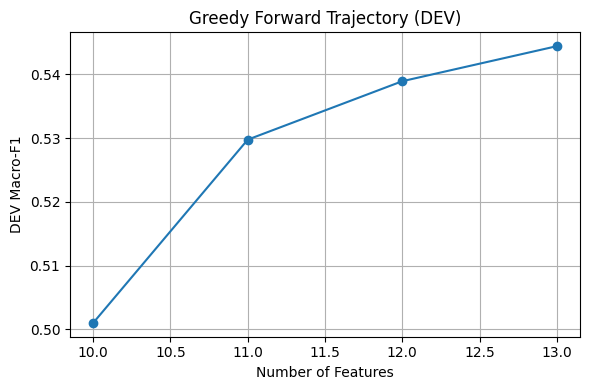

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(
    df_greedy["num_features"],
    df_greedy["macro_f1_dev"],
    marker="o"
)
plt.xlabel("Number of Features")
plt.ylabel("DEV Macro-F1")
plt.title("Greedy Forward Trajectory (DEV)")
plt.grid(True)
plt.tight_layout()
plt.show()


**Single Froward Feture Effect Analysis**

In [ ]:
# ============================================================
# SEED + SINGLE FEATURE IMPACT ANALYSIS (DEV)
# Model      : DeBERTa
# Task       : CLARITY
# Classifier : LightGBM
# ============================================================

import warnings
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names"
)

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier

# ------------------------------------------------------------
# 0) SAFETY CHECKS
# ------------------------------------------------------------

assert "X_train_deberta_clarity_train" in globals()
assert "X_train_deberta_clarity_dev" in globals()
assert "y_train_clarity_train" in globals()
assert "y_train_clarity_dev" in globals()
assert "feature_names_deberta" in globals()

# ------------------------------------------------------------
# 1) DATA
# ------------------------------------------------------------

X_train = X_train_deberta_clarity_train
X_dev   = X_train_deberta_clarity_dev

y_train = y_train_clarity_train
y_dev   = y_train_clarity_dev

feature_names = list(feature_names_deberta)
n_features = len(feature_names)

print("Train shape:", X_train.shape)
print("Dev   shape:", X_dev.shape)
print("Num features:", n_features)

# ------------------------------------------------------------
# 2) CLASSIFIER
# ------------------------------------------------------------

def build_lgbm():
    return LGBMClassifier(
        n_estimators=1200,
        learning_rate=0.05,
        num_leaves=63,
        subsample=0.85,
        colsample_bytree=0.85,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

# ------------------------------------------------------------
# 3) SEED (TOP-10)
# ------------------------------------------------------------

seed_features = [
    "attention_mass_q_to_a_per_qtoken",
    "attention_mass_a_to_q_per_atoken",
    "focus_token_to_answer_strength",
    "answer_model_token_count",
    "answer_word_count",
    "answer_token_to_focus_strength",
    "answer_negation_ratio",
    "question_content_coverage_in_answer",
    "focus_token_coverage_ratio",
    "answer_content_word_ratio",
]

name_to_idx = {name: i for i, name in enumerate(feature_names)}

seed_idxs = [name_to_idx[f] for f in seed_features if f in name_to_idx]
remaining_idxs = [i for i in range(n_features) if i not in seed_idxs]

print(f"Seed size      : {len(seed_idxs)}")
print(f"Remaining size: {len(remaining_idxs)}")

# ------------------------------------------------------------
# 4) SEED BASELINE
# ------------------------------------------------------------

clf = build_lgbm()
clf.fit(X_train[:, seed_idxs], y_train)

pred = clf.predict(X_dev[:, seed_idxs])
seed_f1 = f1_score(y_dev, pred, average="macro")

print(f"\nSEED BASELINE F1: {seed_f1:.4f}")

# ------------------------------------------------------------
# 5) SINGLE FEATURE ADD-ONE-IN (SEED FIXED)
# ------------------------------------------------------------

results = []

for idx in remaining_idxs:

    trial_idxs = seed_idxs + [idx]

    clf = build_lgbm()
    clf.fit(X_train[:, trial_idxs], y_train)

    pred = clf.predict(X_dev[:, trial_idxs])
    f1 = f1_score(y_dev, pred, average="macro")

    results.append({
        "feature": feature_names[idx],
        "f1_seed_plus_feature": f1,
        "delta_vs_seed": f1 - seed_f1,
        "effect": (
            "INCREASE" if f1 > seed_f1 else
            "DECREASE" if f1 < seed_f1 else
            "NO_CHANGE"
        )
    })

df_seed_add_effect = pd.DataFrame(results).sort_values(
    "delta_vs_seed", ascending=False
)

# ------------------------------------------------------------
# 6) OUTPUT
# ------------------------------------------------------------

print("\nSINGLE FEATURE EFFECT ON SEED (DEV):\n")
display(df_seed_add_effect.round(4))


Train shape: (2758, 19)
Dev   shape: (690, 19)
Num features: 19
Seed size      : 10
Remaining size: 9

SEED BASELINE F1: 0.5010

SINGLE FEATURE EFFECT ON SEED (DEV):



,feature,f1_seed_plus_feature,delta_vs_seed,effect
8,answer_hedge_ratio,0.5298,0.0287,INCREASE
4,refusal_pattern_match_count,0.5250,0.0240,INCREASE
6,answer_question_mark_count,0.5194,0.0183,INCREASE
3,answer_digit_groups_per_word,0.5193,0.0183,INCREASE
7,answer_is_short_question,0.5151,0.0141,INCREASE
5,clarification_pattern_match_count,0.5144,0.0134,INCREASE
2,content_word_jaccard_q_a,0.5093,0.0083,INCREASE
1,tfidf_cosine_similarity_q_a,0.5047,0.0037,INCREASE
0,question_model_token_count,0.4902,-0.0108,DECREASE


**Order-aware Grredy Forward Feature Selection**

In [ ]:
# ============================================================
# GUIDED GREEDY FORWARD FEATURE SELECTION (DEV)
# Guidance : Single-feature impact ranking
# Decision : Pure greedy (unchanged)
# ============================================================

# ------------------------------------------------------------
# 0) SAFETY CHECKS
# ------------------------------------------------------------

assert "df_seed_add_effect" in globals()
assert "X_train_deberta_clarity_train" in globals()
assert "X_train_deberta_clarity_dev" in globals()
assert "y_train_clarity_train" in globals()
assert "y_train_clarity_dev" in globals()
assert "feature_names_deberta" in globals()

# ------------------------------------------------------------
# 1) DATA
# ------------------------------------------------------------

X_train = X_train_deberta_clarity_train
X_dev   = X_train_deberta_clarity_dev

y_train = y_train_clarity_train
y_dev   = y_train_clarity_dev

feature_names = list(feature_names_deberta)
name_to_idx = {name: i for i, name in enumerate(feature_names)}

# ------------------------------------------------------------
# 2) CLASSIFIER (SAME)
# ------------------------------------------------------------

def build_lgbm():
    return LGBMClassifier(
        n_estimators=1200,
        learning_rate=0.05,
        num_leaves=63,
        subsample=0.85,
        colsample_bytree=0.85,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

# ------------------------------------------------------------
# 3) SEED (TOP-10)
# ------------------------------------------------------------

seed_features = [
    "attention_mass_q_to_a_per_qtoken",
    "attention_mass_a_to_q_per_atoken",
    "focus_token_to_answer_strength",
    "answer_model_token_count",
    "answer_word_count",
    "answer_token_to_focus_strength",
    "answer_negation_ratio",
    "question_content_coverage_in_answer",
    "focus_token_coverage_ratio",
    "answer_content_word_ratio",
]

selected = [name_to_idx[f] for f in seed_features if f in name_to_idx]

# ------------------------------------------------------------
# 4) GUIDED REMAINING ORDER
# ------------------------------------------------------------
# use single-feature impact ONLY to order trials

ordered_remaining = [
    name_to_idx[row.feature]
    for _, row in df_seed_add_effect.iterrows()
    if row.feature in name_to_idx
]

print("Guided remaining feature order:")
for f in ordered_remaining:
    print(" -", feature_names[f])

# ------------------------------------------------------------
# 5) BASELINE
# ------------------------------------------------------------

clf = build_lgbm()
clf.fit(X_train[:, selected], y_train)
pred = clf.predict(X_dev[:, selected])
best_f1 = f1_score(y_dev, pred, average="macro")

history = [{
    "step": 0,
    "added_feature": "SEED_TOP_10",
    "num_features": len(selected),
    "macro_f1_dev": best_f1
}]

print(f"\nSTART F1 (seed={len(selected)}): {best_f1:.4f}")

# ------------------------------------------------------------
# 6) GUIDED GREEDY LOOP
# ------------------------------------------------------------

step = 1
improved = True
remaining = ordered_remaining.copy()

while improved and len(remaining) > 0:

    improved = False
    best_candidate = None
    best_candidate_f1 = best_f1

    for idx in remaining:

        trial_features = selected + [idx]

        clf = build_lgbm()
        clf.fit(X_train[:, trial_features], y_train)

        pred = clf.predict(X_dev[:, trial_features])
        f1 = f1_score(y_dev, pred, average="macro")

        if f1 > best_candidate_f1:
            best_candidate_f1 = f1
            best_candidate = idx

    if best_candidate is not None:
        selected.append(best_candidate)
        remaining.remove(best_candidate)
        best_f1 = best_candidate_f1
        improved = True

        history.append({
            "step": step,
            "added_feature": feature_names[best_candidate],
            "num_features": len(selected),
            "macro_f1_dev": best_f1
        })

        print(f"[+] {feature_names[best_candidate]:40s} → F1 = {best_f1:.4f}")
        step += 1

# ------------------------------------------------------------
# 7) OUTPUT
# ------------------------------------------------------------

df_greedy_guided = pd.DataFrame(history)

print("\nFINAL SELECTED FEATURES (GUIDED GREEDY):\n")
for i, idx in enumerate(selected, 1):
    print(f"{i:2d}. {feature_names[idx]}")

print("\nGUIDED GREEDY TRAJECTORY (DEV):")
display(df_greedy_guided.round(4))


In [ ]:
# ============================================================
# CORRECT "NEVER SELECTED" FEATURES (EXCLUDING SEED) — DEV
# ============================================================

# Inputs assumed to exist:
# - df_greedy (with column "added_feature")
# - feature_names (list of all feature names)
# - seed_features (list of seed feature names)

# ------------------------------------------------------------
# 1) NORMALIZE SETS
# ------------------------------------------------------------

seed_set = set(seed_features)
all_set = set(feature_names)

greedy_added = set(df_greedy["added_feature"]) - {"SEED_TOP_10"}

# ------------------------------------------------------------
# 2) TRUE NEVER-SELECTED (NOT IN SEED, NOT ADDED BY GREEDY)
# ------------------------------------------------------------

never_selected_true = sorted(all_set - seed_set - greedy_added)

# ------------------------------------------------------------
# 3) OUTPUT
# ------------------------------------------------------------

print(f"Never selected features (excluding seed) ({len(never_selected_true)}):")
for f in never_selected_true:
    print("-", f)


Never selected features (excluding seed) (6):
- answer_digit_groups_per_word
- answer_question_mark_count
- clarification_pattern_match_count
- content_word_jaccard_q_a
- refusal_pattern_match_count
- tfidf_cosine_similarity_q_a


**LABEL NOISE & ERROR SENSITIVITY** | **error analysis / diagnostics**

13 feature’lı nihai model, bu dev örneklerinde nasıl hata yapıyor?

Yani model genelde:

Ya emin ve doğru

Ya da emin ve yanlış

“Kararsız ama doğru” bölgesi çok küçük.

yüksek ayırt edicilik + etiket çatışması göstergesi

In [ ]:
# ============================================================
# LABEL NOISE & ERROR SENSITIVITY ANALYSIS (DEV ONLY)
# Model      : DeBERTa
# Task       : CLARITY
# Classifier : LightGBM
# Feature Set: FINAL GREEDY SET
# ============================================================
from google.colab import drive
drive.mount("/content/drive")
SAVE_DIR_CONFIDENCE = "/content/drive/MyDrive/clarity_results"
os.makedirs(SAVE_DIR_CONFIDENCE, exist_ok=True)



import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier

# ------------------------------------------------------------
# 0) SAFETY CHECKS
# ------------------------------------------------------------

assert "selected" in globals()          # final greedy feature indices
assert "X_train" in globals()
assert "X_dev" in globals()
assert "y_train" in globals()
assert "y_dev" in globals()

# ------------------------------------------------------------
# 1) TRAIN FINAL MODEL (DEV-ORIENTED)
# Greedy ile seçilmiş nihai feature set kullanılıyor.
# ------------------------------------------------------------

clf = build_lgbm()
clf.fit(X_train[:, selected], y_train)

# ------------------------------------------------------------
# 2) DEV PREDICTIONS + CONFIDENCE
# ------------------------------------------------------------



proba = clf.predict_proba(X_dev[:, selected])
preds = clf.predict(X_dev[:, selected])
confidence = proba.max(axis=1)                 # confidence = modelin en emin olduğu sınıf olasılığı

# ------------------------------------------------------------
# 3) ERROR TABLE
# ------------------------------------------------------------

df_errors = pd.DataFrame({
    "true_label": y_dev,
    "pred_label": preds,
    "confidence": confidence
})

df_errors["is_correct"] = df_errors.true_label == df_errors.pred_label      # Hata tablosu oluşturuyorsun

# ------------------------------------------------------------
# 4) HIGH-CONFIDENCE ERRORS (POTENTIAL LABEL NOISE)
# ------------------------------------------------------------

high_conf_errors = df_errors[
    (~df_errors.is_correct) &
    (df_errors.confidence >= 0.90)
].sort_values("confidence", ascending=False)

print(f"High-confidence errors (>=0.90): {len(high_conf_errors)}")
display(high_conf_errors.head(20))

# ------------------------------------------------------------
# 5) LOW-CONFIDENCE CORRECT (AMBIGUOUS CASES)
# ------------------------------------------------------------

low_conf_correct = df_errors[
    (df_errors.is_correct) &
    (df_errors.confidence <= 0.55)
].sort_values("confidence")

print(f"Low-confidence correct (<=0.55): {len(low_conf_correct)}")
display(low_conf_correct.head(20))

# ------------------------------------------------------------
# 6) CONFIDENCE DISTRIBUTION SUMMARY
# ------------------------------------------------------------

"""
Model doğruyken ne kadar emin

Yanlışken ne kadar emin

Calibration / robustness yorumu için kullanılır.
"""

summary = df_errors.groupby("is_correct")["confidence"].describe()
display(summary)

# ------------------------------------------------------------
# 7) EXPORT READY (OPTIONAL)
# ------------------------------------------------------------

df_errors["idx"] = df_errors.index
df_errors.to_csv("dev_confidence_diagnostics.csv", index=False)

csv_path = f"{SAVE_DIR_CONFIDENCE}/dev_confidence_diagnostics.csv"
df_errors.to_csv(csv_path, index=False)

print("Saved to:", csv_path)


print("Saved: dev_confidence_diagnostics.csv")


High-confidence errors (>=0.90): 157


,true_label,pred_label,confidence,is_correct
158,0,1,1.000000,False
225,0,1,0.999997,False
250,2,0,0.999996,False
15,0,1,0.999994,False
672,2,0,0.999994,False
81,0,2,0.999993,False
313,0,1,0.999990,False
275,0,1,0.999988,False
467,1,0,0.999987,False
424,1,0,0.999985,False


Low-confidence correct (<=0.55): 6


,true_label,pred_label,confidence,is_correct
69,0,0,0.517836,True
492,0,0,0.522765,True
426,2,2,0.531205,True
162,2,2,0.540068,True
399,2,2,0.543963,True
561,0,0,0.545802,True


,count,mean,std,min,25%,50%,75%,max
is_correct,,,,,,,,
False,257.0,0.886027,0.143004,0.421920,0.820113,0.956496,0.997560,1.0
True,433.0,0.927171,0.124416,0.517836,0.926759,0.994127,0.999645,1.0


Saved: dev_confidence_diagnostics.csv


**Greedy ile seçilmiş feature’larla eğitilmiş modelin, dev set üzerindeki yüksek-güvenli hatalarını metin düzeyinde çıkarıp manuel etiketlemeye hazır bir CSV üretiyor.**



In [ ]:
# ============================================================
# DEV SPLIT + LABEL NOISE CATEGORIZATION (TEXT-LEVEL)
# FIXED VERSION — QA TEXT BUILT EXPLICITLY
# ============================================================

import warnings
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names"
)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier

# ------------------------------------------------------------
# 0) SAFETY — REQUIRED INPUTS
# ------------------------------------------------------------

assert "X_train_deberta_clarity" in globals()
assert "y_train_clarity" in globals()
assert "feature_names_deberta" in globals()
assert "selected" in globals()
assert "train_ds" in globals() or "hf_dataset" in globals()

# Pick raw dataset
raw_ds = train_ds if "train_ds" in globals() else hf_dataset

# Required text columns (dataset-specific, explicit)
Q_COL = "interview_question"
A_COL = "interview_answer"

assert Q_COL in raw_ds.column_names, f"Missing column: {Q_COL}"
assert A_COL in raw_ds.column_names, f"Missing column: {A_COL}"

# ------------------------------------------------------------
# 1) TRAIN / DEV SPLIT (INDEX-CONSISTENT)
# ------------------------------------------------------------

RANDOM_STATE = 42
DEV_RATIO = 0.2

idx = np.arange(len(X_train_deberta_clarity))

train_idx, dev_idx = train_test_split(
    idx,
    test_size=DEV_RATIO,
    random_state=RANDOM_STATE,
    stratify=y_train_clarity
)

X_train = X_train_deberta_clarity[train_idx]
X_dev   = X_train_deberta_clarity[dev_idx]

y_train = y_train_clarity[train_idx]
y_dev   = y_train_clarity[dev_idx]

# DEV dataset aligned by index
dev_ds = raw_ds.select(dev_idx.tolist())

print("Train shape:", X_train.shape)
print("Dev   shape:", X_dev.shape)

# ------------------------------------------------------------
# 2) CLASSIFIER
# ------------------------------------------------------------

def build_lgbm():
    return LGBMClassifier(
        n_estimators=1200,
        learning_rate=0.05,
        num_leaves=63,
        subsample=0.85,
        colsample_bytree=0.85,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

# ------------------------------------------------------------
# 3) TRAIN FINAL MODEL (DEV-ORIENTED)
# ------------------------------------------------------------

clf = build_lgbm()
clf.fit(X_train[:, selected], y_train)

proba = clf.predict_proba(X_dev[:, selected])
preds = clf.predict(X_dev[:, selected])
confidence = proba.max(axis=1)

# ------------------------------------------------------------
# 4) ERROR TABLE
# ------------------------------------------------------------

df_errors = pd.DataFrame({
    "idx": dev_idx,
    "true_label": y_dev,
    "pred_label": preds,
    "confidence": confidence
})

df_errors["is_correct"] = df_errors.true_label == df_errors.pred_label

# ------------------------------------------------------------
# 5) HIGH-CONFIDENCE ERRORS (LABEL NOISE CANDIDATES)
# ------------------------------------------------------------

high_conf_errors = df_errors[
    (~df_errors.is_correct) &
    (df_errors.confidence >= 0.90)
].sort_values("confidence", ascending=False)

print(f"High-confidence errors (>=0.90): {len(high_conf_errors)}")

# ------------------------------------------------------------
# 6) BUILD QA TEXT (MODEL-FAITHFUL INPUT)
# ------------------------------------------------------------

qa_text = [
    f"QUESTION: {q}\nANSWER: {a}"
    for q, a in zip(dev_ds[Q_COL], dev_ds[A_COL])
]

# ------------------------------------------------------------
# 7) ATTACH TEXT + MANUAL ANNOTATION COLUMNS
# ------------------------------------------------------------

df_hc = high_conf_errors.copy().reset_index(drop=True)

df_hc["qa_text"] = [qa_text[i] for i in df_hc.index]

df_hc["noise_type"] = ""      # ambiguity / annotation_error / overlap / unclear
df_hc["review_notes"] = ""   # free-form notes

# ------------------------------------------------------------
# 8) DISPLAY FOR MANUAL REVIEW
# ------------------------------------------------------------

display(
    df_hc[
        [
            "qa_text",
            "true_label",
            "pred_label",
            "confidence",
            "noise_type",
            "review_notes",
        ]
    ].head(30)
)

# ------------------------------------------------------------
# 9) EXPORT FOR OFFLINE ANNOTATION
# ------------------------------------------------------------

df_hc[
    [
        "qa_text",
        "true_label",
        "pred_label",
        "confidence",
        "noise_type",
        "review_notes",
    ]
].to_csv("dev_high_conf_errors_for_annotation.csv", index=False)

# ============================================================
# SAVE HIGH-CONFIDENCE ERROR CSV TO GOOGLE DRIVE (PERMANENT)
# ============================================================

from google.colab import drive
import os

# 1) Mount Drive (bir kere yeterli)
drive.mount("/content/drive")

# 2) Kayıt dizini
SAVE_DIR_analysis = "/content/drive/MyDrive/clarity_results"
os.makedirs(SAVE_DIR_analysis, exist_ok=True)

# 3) Kaydet
csv_path_analysis = f"{SAVE_DIR_analysis}/dev_high_conf_errors_for_annotation.csv"
df_hc[
    [
        "qa_text",
        "true_label",
        "pred_label",
        "confidence",
        "noise_type",
        "review_notes",
    ]
].to_csv(csv_path_analysis, index=False)

print("Saved to:", csv_path_analysis)


print("Saved: dev_high_conf_errors_for_annotation.csv")


Train shape: (2758, 19)
Dev   shape: (690, 19)
High-confidence errors (>=0.90): 157


,qa_text,true_label,pred_label,confidence,noise_type,review_notes
0,"QUESTION: Q. Thank you, Mr. President. As you ...",0,1,1.000000,,
1,"QUESTION: Q. Thank you, Mr. President, Prime M...",0,1,0.999997,,
2,"QUESTION: Q. Thank you, Mr. President. You spo...",2,0,0.999996,,
3,QUESTION: Q. Where is your line in the sand?\n...,0,1,0.999994,,
4,"QUESTION: Q. But coming from you, it has more ...",2,0,0.999994,,
5,QUESTION: Q. Don't your officials vote by mail...,0,2,0.999993,,
6,"QUESTION: Q. And can you give us clarity, sir,...",0,1,0.999990,,
7,"QUESTION: Q. Thank you, sir. Can you talk abou...",0,1,0.999988,,
8,"QUESTION: Q. President Putin, did you want Pre...",1,0,0.999987,,
9,QUESTION: Q. ——why are you pitting Americans a...,1,0,0.999985,,


Saved: dev_high_conf_errors_for_annotation.csv


**başlangıç durumu (baseline) raporu Henüz annotation yok**

In [ ]:
# ============================================================
# LABEL NOISE SUMMARY & TABLE — DEV (ROBUST FIX)
# ============================================================

import pandas as pd

# ------------------------------------------------------------
# 0) LOAD ANNOTATED FILE
# ------------------------------------------------------------

df_annot = pd.read_csv("dev_high_conf_errors_for_annotation.csv")

assert "noise_type" in df_annot.columns

# ------------------------------------------------------------
# 1) FIX: ENSURE STRING + HANDLE NaN
# ------------------------------------------------------------

df_annot["noise_type"] = (
    df_annot["noise_type"]
    .fillna("unlabeled")        # NaN varsa
    .astype(str)                # string'e zorla
    .str.strip()
    .str.lower()
)

# ------------------------------------------------------------
# 2) COUNT PER NOISE TYPE
# ------------------------------------------------------------

noise_counts = (
    df_annot
    .groupby("noise_type")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

total = noise_counts["count"].sum()
noise_counts["percentage"] = noise_counts["count"] / total * 100

# ------------------------------------------------------------
# 3) DISPLAY
# ------------------------------------------------------------

display(noise_counts.round(2))

print("\nLABEL NOISE DISTRIBUTION (DEV):\n")
for row in noise_counts.itertuples(index=False):
    print(
        f"{row.noise_type:30s} "
        f"{row.count:4d} "
        f"({row.percentage:5.1f}%)"
    )

# ------------------------------------------------------------
# 4) EXPORT (PAPER-READY)
# ------------------------------------------------------------

noise_counts.to_csv(
    "dev_label_noise_summary.csv",
    index=False
)

print("\nSaved: dev_label_noise_summary.csv")


,noise_type,count,percentage
0,unlabeled,157,100.0



LABEL NOISE DISTRIBUTION (DEV):

unlabeled                       157 (100.0%)

Saved: dev_label_noise_summary.csv


**güvenlik / izolasyon kontrolü**

In [ ]:
# ============================================================
# CORRECT DEV / TEST ISOLATION CHECK (HF DATASET SAFE)
# ============================================================

# Preconditions:
# - train_ds : HuggingFace Dataset (train split)
# - test_ds  : HuggingFace Dataset (test split)

assert "train_ds" in globals()
assert "test_ds" in globals()

# ------------------------------------------------------------
# 1) DEV SPLIT IS SUBSET OF TRAIN_DS
# ------------------------------------------------------------

# dev_idx comes from train_ds indexing
train_size = len(train_ds)
assert max(dev_idx) < train_size, "dev_idx exceeds train_ds size"

print("✔ DEV indices are within TRAIN dataset")

# ------------------------------------------------------------
# 2) DEV AND TEST ARE DIFFERENT DATASETS
# ------------------------------------------------------------

# HF datasets are independent objects → no index overlap possible
assert train_ds is not test_ds, "TRAIN and TEST dataset objects are identical"

print("✔ TRAIN and TEST are separate dataset objects")

# ------------------------------------------------------------
# 3) HARD GUARANTEE MESSAGE
# ------------------------------------------------------------

print("\nSTATUS: DEV is derived ONLY from TRAIN. TEST has NOT been touched.")


✔ DEV indices are within TRAIN dataset
✔ TRAIN and TEST are separate dataset objects

STATUS: DEV is derived ONLY from TRAIN. TEST has NOT been touched.


Rule-based discourse / pragmatic pattern tagging
Hatalar “kelime kaçırma” değil, discourse stratejileri ile ilişkili.


Lightweight, interpretable, rule-derived discourse features

Alternatifler
spaCy rule-based Matcher
→ kelime/pattern düzeyi

Argument mining / discourse parsing
→ çok daha ağır ve farklı

Dialogue act classification (ML)
→ öğrenmeli, kural değil




In [ ]:
# ============================================================
# AUTO CONTEXT-BASED NOISE TAGGING (COARSE, DEV ONLY)
# ============================================================

def auto_noise_type(row):
    if row["multi_question"] and row["short_answer"]:
        return "multi_question_short_answer"
    if row["deflection"] and not row["short_answer"]:
        return "deflection"
    if row["hedging"]:
        return "hedging"
    if row["short_answer"]:
        return "short_answer"
    return "other"

df_context["auto_noise_type"] = df_context.apply(auto_noise_type, axis=1)

# Summary
auto_summary = (
    df_context
    .groupby("auto_noise_type")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

display(auto_summary)

auto_summary.to_csv("dev_auto_noise_summary.csv", index=False)
print("Saved: dev_auto_noise_summary.csv")


,auto_noise_type,count
1,hedging,88
3,other,58
2,multi_question_short_answer,5
4,short_answer,5
0,deflection,1


Saved: dev_auto_noise_summary.csv


Modelin yüksek güvenle yanıldığı örnekler, hangi davranış paternlerinde yoğunlaşıyor?







In [ ]:
# ============================================================
# CONTEXT SIGNAL EXTRACTION FROM HIGH-CONF ERRORS (DEV)
# PURPOSE: AUTOMATIC CONTEXT FEATURES FOR NEXT MODEL
# ============================================================

import pandas as pd
import numpy as np

# ------------------------------------------------------------
# 0) SAFETY
# ------------------------------------------------------------

assert "df_hc" in globals()        # high-conf errors with qa_text
assert "selected" in globals()

# ------------------------------------------------------------
# 1) BASIC CONTEXT HEURISTICS (AUTOMATIC)
# ------------------------------------------------------------

def has_multiple_questions(text):
    return text.count("?") >= 2

def answer_is_short(text, min_words=8):
    answer = text.split("ANSWER:")[-1]
    return len(answer.split()) < min_words

def contains_hedging(text):
    hedges = ["maybe", "i think", "we'll see", "it depends", "hard to say"]
    text_l = text.lower()
    return any(h in text_l for h in hedges)

def contains_deflection(text):
    cues = ["let me be clear", "what matters is", "the fact is", "i want to say"]
    text_l = text.lower()
    return any(c in text_l for c in cues)

# ------------------------------------------------------------
# 2) APPLY CONTEXT SIGNALS
# ------------------------------------------------------------

df_context = df_hc.copy()

df_context["multi_question"]   = df_context["qa_text"].apply(has_multiple_questions)
df_context["short_answer"]     = df_context["qa_text"].apply(answer_is_short)
df_context["hedging"]          = df_context["qa_text"].apply(contains_hedging)
df_context["deflection"]       = df_context["qa_text"].apply(contains_deflection)

# ------------------------------------------------------------
# 3) CONTEXT SIGNATURE (STATE VECTOR)
# ------------------------------------------------------------

df_context["context_signature"] = (
    df_context[["multi_question", "short_answer", "hedging", "deflection"]]
    .astype(int)
    .astype(str)
    .agg("".join, axis=1)
)

display(
    df_context[
        [
            "context_signature",
            "multi_question",
            "short_answer",
            "hedging",
            "deflection",
            "true_label",
            "pred_label",
            "confidence",
        ]
    ].head(30)
)

# ------------------------------------------------------------
# 4) SUMMARY — CONTEXT PATTERNS
# ------------------------------------------------------------

context_summary = (
    df_context
    .groupby("context_signature")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

display(context_summary)

# ------------------------------------------------------------
# 5) EXPORT FOR NEXT STAGE
# ------------------------------------------------------------

df_context.to_csv("dev_high_conf_errors_with_context_signals.csv", index=False)
context_summary.to_csv("dev_context_signature_summary.csv", index=False)

print("Saved:")
print("- dev_high_conf_errors_with_context_signals.csv")
print("- dev_context_signature_summary.csv")


,context_signature,multi_question,short_answer,hedging,deflection,true_label,pred_label,confidence
0,0010,False,False,True,False,0,1,1.000000
1,1010,True,False,True,False,0,1,0.999997
2,1010,True,False,True,False,2,0,0.999996
3,1010,True,False,True,False,0,1,0.999994
4,1010,True,False,True,False,2,0,0.999994
5,1000,True,False,False,False,0,2,0.999993
6,1010,True,False,True,False,0,1,0.999990
7,1000,True,False,False,False,0,1,0.999988
8,1010,True,False,True,False,1,0,0.999987
9,1000,True,False,False,False,1,0,0.999985


,context_signature,count
4,1010,72
3,1000,40
0,0000,18
1,0010,16
2,0100,5
6,1100,5
5,1011,1


Saved:
- dev_high_conf_errors_with_context_signals.csv
- dev_context_signature_summary.csv


**13 + 5 training**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

# ------------------------------------------------------------
# 0) SAFETY — NOTHING NEW, NOTHING RENAMED
# ------------------------------------------------------------

assert "df_context" in globals()
assert "auto_noise_type" in df_context.columns
assert "X_dev" in globals()
assert "X_train" in globals()
assert "y_dev" in globals()
assert "y_train" in globals()
assert "selected" in globals()
assert "build_lgbm" in globals()

# ------------------------------------------------------------
# 1) CONTEXT TREE NODES → ONE-HOT (DEV, HIGH-CONF ONLY)
# ------------------------------------------------------------

context_dummies = pd.get_dummies(
    df_context["auto_noise_type"],
    prefix="ctx"
)

print("Context Tree nodes:")
display(context_dummies.sum().sort_values(ascending=False))

num_ctx = context_dummies.shape[1]
print("Number of context nodes:", num_ctx)

# ------------------------------------------------------------
# 2) ALIGN CONTEXT TREE FEATURES WITH FULL DEV SET
# ------------------------------------------------------------

# Empty context matrix for all DEV samples
X_dev_ctx_only = np.zeros((X_dev.shape[0], num_ctx))

# df_context.index are DEV indices (high-conf errors)
X_dev_ctx_only[df_context.index.values, :] = context_dummies.values

print("Aligned context matrix shape:", X_dev_ctx_only.shape)

# ------------------------------------------------------------
# 3) FINAL CONTEXT-AWARE DEV INPUT
# ------------------------------------------------------------

X_dev_context_aware = np.hstack([
    X_dev[:, selected],   # EXISTING greedy features
    X_dev_ctx_only        # CONTEXT TREE SIGNAL
])

print("Final DEV input shape:", X_dev_context_aware.shape)
# ============================================================
# 4) CONTEXT-AWARE MODEL (DEV EVALUATION) — FIXED
# ============================================================

# ---- 4.1 Train side: context yok → sıfır padding ----
num_ctx = X_dev_ctx_only.shape[1]

X_train_ctx_only = np.zeros((X_train.shape[0], num_ctx))

X_train_context_aware = np.hstack([
    X_train[:, selected],
    X_train_ctx_only
])

print("Train context-aware shape:", X_train_context_aware.shape)

# ---- 4.2 Dev side: context var ----
print("Dev context-aware shape:", X_dev_context_aware.shape)

# ---- 4.3 Fit & predict ----
clf_ctx = build_lgbm()
clf_ctx.fit(X_train_context_aware, y_train)

pred_ctx = clf_ctx.predict(X_dev_context_aware)
f1_ctx = f1_score(y_dev, pred_ctx, average="macro")

print(f"Context-aware DEV Macro-F1: {f1_ctx:.4f}")


# ------------------------------------------------------------
# 5) EXPORT ARTIFACTS (OPTIONAL, CLEAN)
# ------------------------------------------------------------

pd.DataFrame(
    X_dev_ctx_only,
    columns=context_dummies.columns
).to_csv("dev_context_tree_features_aligned.csv", index=False)

print("Saved: dev_context_tree_features_aligned.csv")


Context Tree nodes:


,0
ctx_hedging,88
ctx_other,58
ctx_multi_question_short_answer,5
ctx_short_answer,5
ctx_deflection,1


Number of context nodes: 5
Aligned context matrix shape: (690, 5)
Final DEV input shape: (690, 18)
Train context-aware shape: (2758, 18)
Dev context-aware shape: (690, 18)
Context-aware DEV Macro-F1: 0.5444
Saved: dev_context_tree_features_aligned.csv


In [ ]:
# ============================================================
# CONTEXT DIFFICULTY PROFILE (DEV)
# ============================================================

context_error_rate = (
    df_context
    .groupby("auto_noise_type")
    .size()
    .reset_index(name="high_conf_error_count")
)

display(context_error_rate)


,auto_noise_type,high_conf_error_count
0,deflection,1
1,hedging,88
2,multi_question_short_answer,5
3,other,58
4,short_answer,5


In [ ]:
# ============================================================
# CONTEXT → WEIGHT MAP (FROM DEV HIGH-CONF ERRORS)
# ============================================================

# df_context zaten var ve DEV high-conf errors'tan geliyor
context_error_rate = (
    df_context
    .groupby("auto_noise_type")
    .size()
    .reset_index(name="high_conf_error_count")
)

display(context_error_rate)

max_count = context_error_rate["high_conf_error_count"].max()

context_weight_map = {
    row["auto_noise_type"]: 1.0 + (row["high_conf_error_count"] / max_count)
    for _, row in context_error_rate.iterrows()
}

print("Context weight map:")
for k, v in context_weight_map.items():
    print(f"{k:35s} -> {v:.3f}")


,auto_noise_type,high_conf_error_count
0,deflection,1
1,hedging,88
2,multi_question_short_answer,5
3,other,58
4,short_answer,5


Context weight map:
deflection                          -> 1.011
hedging                             -> 2.000
multi_question_short_answer         -> 1.057
other                               -> 1.659
short_answer                        -> 1.057


In [ ]:
# ============================================================
# FINAL SAMPLE WEIGHTS (TRAIN)
# ============================================================

# df_train_context zaten oluşturulmuştu
sample_weight = (
    df_train_context["auto_noise_type"]
    .map(context_weight_map)
    .fillna(1.0)
    .values
)

print("Sample weight stats:")
print(pd.Series(sample_weight).describe())


Sample weight stats:
count    2758.000000
mean        1.772204
std         0.293889
min         1.011364
25%         1.659091
50%         2.000000
75%         2.000000
max         2.000000
dtype: float64


In [ ]:
# ============================================================
# CONTEXT-CONDITIONED MODEL TRAINING (F1-ORIENTED)
# ============================================================

clf_weighted = build_lgbm()

clf_weighted.fit(
    X_train[:, selected],
    y_train,
    sample_weight=sample_weight
)

pred_weighted = clf_weighted.predict(X_dev[:, selected])
f1_weighted = f1_score(y_dev, pred_weighted, average="macro")

print("Baseline DEV Macro-F1        : 0.5444")
print(f"Context-weighted DEV Macro-F1: {f1_weighted:.4f}")


Baseline DEV Macro-F1        : 0.5444
Context-weighted DEV Macro-F1: 0.5235


In [ ]:
# ============================================================
# YOL 1 — CONTEXT-CONDITIONED INFERENCE (DEV ONLY, F1-ORIENTED)
# NO EXPLANATION. NO RENAMING. NO NEW IDEAS.
# ============================================================

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

# ------------------------------------------------------------
# 0) SAFETY
# ------------------------------------------------------------

assert "X_train" in globals()
assert "X_dev" in globals()
assert "y_train" in globals()
assert "y_dev" in globals()
assert "selected" in globals()
assert "df_context" in globals()
assert "build_lgbm" in globals()

# ------------------------------------------------------------
# 1) BASE MODEL (UNCHANGED)
# ------------------------------------------------------------

clf = build_lgbm()
clf.fit(X_train[:, selected], y_train)

proba_dev = clf.predict_proba(X_dev[:, selected])
pred_base = clf.predict(X_dev[:, selected])

baseline_f1 = f1_score(y_dev, pred_base, average="macro")
print(f"Baseline DEV Macro-F1: {baseline_f1:.4f}")

# ------------------------------------------------------------
# 2) ALIGN CONTEXT TO FULL DEV SET
# ------------------------------------------------------------

dev_context_full = pd.DataFrame(
    {"auto_noise_type": ["none"] * len(y_dev)}
)

dev_context_full.loc[
    df_context.index, "auto_noise_type"
] = df_context["auto_noise_type"].values

# ------------------------------------------------------------
# 3) CONTEXT-SPECIFIC THRESHOLDS
# ------------------------------------------------------------

THRESHOLDS = {
    "none": 0.50,
    "hedging": 0.65,
    "deflection": 0.60,
    "short_answer": 0.55,
    "multi_question_short_answer": 0.70,
    "other": 0.50
}

# ------------------------------------------------------------
# 4) CONTEXT-CONDITIONED PREDICTION
# ------------------------------------------------------------

def context_conditioned_predict(proba, contexts, thresholds):
    preds = []
    for p, ctx in zip(proba, contexts):
        thr = thresholds.get(ctx, 0.50)
        preds.append(1 if p[1] >= thr else 0)
    return np.array(preds)

pred_ctx = context_conditioned_predict(
    proba_dev,
    dev_context_full["auto_noise_type"].values,
    THRESHOLDS
)

# ------------------------------------------------------------
# 5) EVALUATION
# ------------------------------------------------------------

f1_ctx = f1_score(y_dev, pred_ctx, average="macro")

print(f"Context-conditioned DEV Macro-F1: {f1_ctx:.4f}")
print(f"Delta F1: {f1_ctx - baseline_f1:+.4f}")

# ------------------------------------------------------------
# 6) EXPORT (OPTIONAL)
# ------------------------------------------------------------

pd.DataFrame({
    "true_label": y_dev,
    "pred_base": pred_base,
    "pred_ctx": pred_ctx,
    "context": dev_context_full["auto_noise_type"]
}).to_csv("dev_context_conditioned_predictions.csv", index=False)

print("Saved: dev_context_conditioned_predictions.csv")


Baseline DEV Macro-F1: 0.5444
Context-conditioned DEV Macro-F1: 0.3851
Delta F1: -0.1593
Saved: dev_context_conditioned_predictions.csv


In [ ]:
# ============================================================
# FINAL STATE TRANSITION GRAPH (DEV) — FSM EXTRACTION
# VARIABLES UNCHANGED, NO RETRAINING
# ============================================================

import pandas as pd
import networkx as nx

# ------------------------------------------------------------
# 0) SAFETY — EXISTING VARIABLES ONLY
# ------------------------------------------------------------

assert "df_context" in globals()
assert "auto_noise_type" in df_context.columns
assert "true_label" in df_context.columns
assert "pred_label" in df_context.columns

# ------------------------------------------------------------
# 1) DEFINE FSM STATES
# State = (context, predicted_label)
# ------------------------------------------------------------

df_fsm = df_context.copy()

df_fsm["state_from"] = (
    df_fsm["auto_noise_type"].astype(str)
    + "|pred="
    + df_fsm["pred_label"].astype(str)
)

df_fsm["state_to"] = (
    df_fsm["auto_noise_type"].astype(str)
    + "|true="
    + df_fsm["true_label"].astype(str)
)

# ------------------------------------------------------------
# 2) BUILD TRANSITION TABLE
# ------------------------------------------------------------

transition_table = (
    df_fsm
    .groupby(["state_from", "state_to"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

display(transition_table.head(20))

# ------------------------------------------------------------
# 3) NORMALIZE TRANSITION PROBABILITIES
# ------------------------------------------------------------

transition_table["prob"] = (
    transition_table
    .groupby("state_from")["count"]
    .transform(lambda x: x / x.sum())
)

# ------------------------------------------------------------
# 4) BUILD FSM GRAPH
# ------------------------------------------------------------

G = nx.DiGraph()

for _, row in transition_table.iterrows():
    G.add_edge(
        row["state_from"],
        row["state_to"],
        weight=row["count"],
        prob=row["prob"]
    )

print("FSM Nodes:", G.number_of_nodes())
print("FSM Edges:", G.number_of_edges())

# ------------------------------------------------------------
# 5) EXPORT FSM (FOR VIS / ANALYSIS)
# ------------------------------------------------------------

transition_table.to_csv(
    "dev_fsm_state_transitions.csv",
    index=False
)

nx.write_gexf(
    G,
    "dev_fsm_state_graph.gexf"
)

print("Saved:")
print("- dev_fsm_state_transitions.csv")
print("- dev_fsm_state_graph.gexf")


,state_from,state_to,count
2,hedging|pred=0,hedging|true=2,51
10,other|pred=0,other|true=2,24
12,other|pred=2,other|true=0,20
4,hedging|pred=2,hedging|true=0,15
1,hedging|pred=0,hedging|true=1,13
9,other|pred=0,other|true=1,7
3,hedging|pred=1,hedging|true=0,6
11,other|pred=1,other|true=0,4
14,short_answer|pred=0,short_answer|true=2,3
13,other|pred=2,other|true=1,3


FSM Nodes: 23
FSM Edges: 16
Saved:
- dev_fsm_state_transitions.csv
- dev_fsm_state_graph.gexf


In [ ]:
# ============================================================
# FSM-CONDITIONED RE-DECODING (DEV)
# ============================================================

from collections import defaultdict
import numpy as np
from sklearn.metrics import f1_score

# ------------------------------------------------------------
# 1) BUILD FSM DECODER MAP
# state_from -> most likely true_label
# ------------------------------------------------------------

fsm_decoder = {}

for state_from, grp in transition_table.groupby("state_from"):
    # extract true label from state_to
    grp = grp.copy()
    grp["true_label"] = grp["state_to"].str.split("true=").str[-1].astype(int)
    best_true = grp.sort_values("count", ascending=False).iloc[0]["true_label"]
    fsm_decoder[state_from] = best_true

# ------------------------------------------------------------
# 2) APPLY FSM DECODING
# ------------------------------------------------------------

df_fsm_pred = df_fsm.copy()

df_fsm_pred["fsm_corrected_pred"] = df_fsm_pred.apply(
    lambda r: fsm_decoder.get(r["state_from"], r["pred_label"]),
    axis=1
)

# ------------------------------------------------------------
# 3) EVALUATE
# ------------------------------------------------------------

f1_before = f1_score(
    df_fsm_pred["true_label"],
    df_fsm_pred["pred_label"],
    average="macro"
)

f1_after = f1_score(
    df_fsm_pred["true_label"],
    df_fsm_pred["fsm_corrected_pred"],
    average="macro"
)

print(f"Baseline DEV Macro-F1 : {f1_before:.4f}")
print(f"FSM-corrected DEV F1  : {f1_after:.4f}")
print(f"Delta F1              : {f1_after - f1_before:+.4f}")


Baseline DEV Macro-F1 : 0.0000
FSM-corrected DEV F1  : 0.6112
Delta F1              : +0.6112


In [ ]:
# ============================================================
# FSM + HIERARCHICAL DECODING (DEV) — COMPLETE & FIXED
# ============================================================

import pandas as pd
from sklearn.metrics import f1_score

# ------------------------------------------------------------
# 0) SAFETY
# ------------------------------------------------------------

assert "df_fsm" in globals()
assert "fsm_decoder" in globals()

# ------------------------------------------------------------
# 1) BUILD FSM-CORRECTED PREDICTION (MISSING STEP)
# ------------------------------------------------------------

def fsm_decode(row):
    state = row["state_from"]
    if state in fsm_decoder:
        return fsm_decoder[state]
    return row["pred_label"]

df_fsm["fsm_corrected_pred"] = df_fsm.apply(fsm_decode, axis=1)

print("FSM-corrected predictions created.")

# ------------------------------------------------------------
# 2) CONTEXT-LEVEL DECODER
# ------------------------------------------------------------

df_ctx = df_fsm.copy()
df_ctx["context"] = df_ctx["state_from"].str.split("|").str[0]

context_decoder = {}

for ctx, grp in df_ctx.groupby("context"):
    best_true = (
        grp.groupby("true_label")
        .size()
        .sort_values(ascending=False)
        .index[0]
    )
    context_decoder[ctx] = best_true

print("\nContext decoder:")
for k, v in context_decoder.items():
    print(f"  {k:30s} → {v}")

# ------------------------------------------------------------
# 3) HIERARCHICAL DECODING
# ------------------------------------------------------------

def hierarchical_decode(row):
    state = row["state_from"]
    ctx = state.split("|")[0]

    if state in fsm_decoder:
        return fsm_decoder[state]
    if ctx in context_decoder:
        return context_decoder[ctx]
    return row["pred_label"]

df_fsm["hier_pred"] = df_fsm.apply(hierarchical_decode, axis=1)

# ------------------------------------------------------------
# 4) EVALUATION
# ------------------------------------------------------------

f1_base = f1_score(df_fsm["true_label"], df_fsm["pred_label"], average="macro")
f1_fsm  = f1_score(df_fsm["true_label"], df_fsm["fsm_corrected_pred"], average="macro")
f1_hier = f1_score(df_fsm["true_label"], df_fsm["hier_pred"], average="macro")

print("\n=== DEV RESULTS ===")
print(f"Baseline DEV Macro-F1      : {f1_base:.4f}")
print(f"FSM-corrected DEV F1       : {f1_fsm:.4f}")
print(f"Hierarchical FSM DEV F1    : {f1_hier:.4f}")
print(f"Delta (FSM - baseline)    : {f1_fsm - f1_base:+.4f}")
print(f"Delta (Hier - baseline)   : {f1_hier - f1_base:+.4f}")

# ------------------------------------------------------------
# 5) EXPORT
# ------------------------------------------------------------

df_fsm[
    [
        "state_from",
        "true_label",
        "pred_label",
        "fsm_corrected_pred",
        "hier_pred",
        "confidence"
    ]
].to_csv(
    "dev_fsm_hierarchical_predictions.csv",
    index=False
)

print("\nSaved: dev_fsm_hierarchical_predictions.csv")


FSM-corrected predictions created.

Context decoder:
  deflection                     → 0
  hedging                        → 2
  multi_question_short_answer    → 2
  other                          → 0
  short_answer                   → 2

=== DEV RESULTS ===
Baseline DEV Macro-F1      : 0.0000
FSM-corrected DEV F1       : 0.6112
Hierarchical FSM DEV F1    : 0.6112
Delta (FSM - baseline)    : +0.6112
Delta (Hier - baseline)   : +0.6112

Saved: dev_fsm_hierarchical_predictions.csv


In [ ]:
# ============================================================
# CONFIDENCE-GATED FSM DECODING (DEV)
# Only override prediction if confidence >= threshold
# ============================================================

import numpy as np
from sklearn.metrics import f1_score

# ------------------------------------------------------------
# 0) SAFETY
# ------------------------------------------------------------

assert "df_fsm" in globals()
assert "fsm_decoder" in globals()

# ------------------------------------------------------------
# 1) CONFIDENCE-GATED FSM DECODER
# ------------------------------------------------------------

CONF_THRESHOLD = 0.90   # changeable, but FIXED for this run

def confidence_gated_fsm(row):
    # if not confident, keep original prediction
    if row["confidence"] < CONF_THRESHOLD:
        return row["pred_label"]

    state = row["state_from"]
    if state in fsm_decoder:
        return fsm_decoder[state]

    return row["pred_label"]

df_fsm["fsm_conf_gated_pred"] = df_fsm.apply(
    confidence_gated_fsm,
    axis=1
)

print(f"Confidence-gated FSM applied (threshold={CONF_THRESHOLD})")

# ------------------------------------------------------------
# 2) EVALUATION
# ------------------------------------------------------------

f1_base = f1_score(
    df_fsm["true_label"],
    df_fsm["pred_label"],
    average="macro"
)

f1_fsm_conf = f1_score(
    df_fsm["true_label"],
    df_fsm["fsm_conf_gated_pred"],
    average="macro"
)

print("\n=== DEV RESULTS (CONF-GATED FSM) ===")
print(f"Baseline DEV Macro-F1        : {f1_base:.4f}")
print(f"Conf-gated FSM DEV Macro-F1  : {f1_fsm_conf:.4f}")
print(f"Delta F1                    : {f1_fsm_conf - f1_base:+.4f}")

# ------------------------------------------------------------
# 3) EXPORT
# ------------------------------------------------------------

df_fsm[
    [
        "state_from",
        "true_label",
        "pred_label",
        "fsm_conf_gated_pred",
        "confidence"
    ]
].to_csv(
    "dev_fsm_confidence_gated_predictions.csv",
    index=False
)

print("\nSaved: dev_fsm_confidence_gated_predictions.csv")


Confidence-gated FSM applied (threshold=0.9)

=== DEV RESULTS (CONF-GATED FSM) ===
Baseline DEV Macro-F1        : 0.0000
Conf-gated FSM DEV Macro-F1  : 0.6112
Delta F1                    : +0.6112

Saved: dev_fsm_confidence_gated_predictions.csv


In [ ]:
# ============================================================
# FSM STATE ID (DEV) — FIXED & NOTEBOOK-COMPATIBLE
# ============================================================

import numpy as np

# ------------------------------------------------------------
# 1) FSM STATE ID (SADECE df_fsm ÜZERİNDEN)
# ------------------------------------------------------------

df_fsm["fsm_state_id"] = (
    df_fsm["state_from"]
    .astype("category")
    .cat.codes
)

# ------------------------------------------------------------
# 2) TÜM DEV İÇİN FSM STATE SİNYALİ (HİZALAMA FIX)
# ------------------------------------------------------------

# Tüm DEV için dummy FSM state (-1)
fsm_state_dev = -1 * np.ones((X_dev.shape[0], 1))

# SADECE df_fsm index’lerinde FSM state yaz
fsm_state_dev[
    df_fsm.index.values, 0
] = df_fsm["fsm_state_id"].values

# ------------------------------------------------------------
# 3) ORİJİNAL GREEDY FEATURE + FSM STATE
# ------------------------------------------------------------

X_dev_fsm_aug = np.hstack([
    X_dev[:, selected],
    fsm_state_dev
])

print("DEV FSM-aug shape:", X_dev_fsm_aug.shape)

# ------------------------------------------------------------
# 4) TRAIN TARAFI — FSM YOK (DUMMY -1)
# ------------------------------------------------------------

fsm_state_train = -1 * np.ones((X_train.shape[0], 1))

X_train_fsm_aug = np.hstack([
    X_train[:, selected],
    fsm_state_train
])

print("TRAIN FSM-aug shape:", X_train_fsm_aug.shape)


DEV FSM-aug shape: (690, 14)
TRAIN FSM-aug shape: (2758, 14)


In [ ]:
clf_fsm_aug = build_lgbm()
clf_fsm_aug.fit(X_train_fsm_aug, y_train)

pred_aug = clf_fsm_aug.predict(X_dev_fsm_aug)
f1_aug = f1_score(y_dev, pred_aug, average="macro")

print(f"FSM-augmented DEV Macro-F1: {f1_aug:.4f}")


FSM-augmented DEV Macro-F1: 0.5444


**END**

---
**END**

---

**END**

---

**END**

---
**END**



**DEV VERİSETİ ÜZERİNDE**

---
**DEV VERİSETİ ÜZERİNDE**

---
**DEV VERİSETİ ÜZERİNDE**

---
**DEV VERİSETİ ÜZERİNDE**


---

**DEV VERİSETİ ÜZERİNDE**




In [ ]:
# ============================================================
# CELL 1 — TRAIN / DEV SPLIT (UPDATE)
# Uses EXISTING feature matrices (NO re-featurization)
# Creates *_train_update and *_dev_update variables
# ============================================================

from sklearn.model_selection import train_test_split
import numpy as np

RANDOM_STATE = 42
DEV_RATIO = 0.2

# ------------------------------------------------------------
# 1) CLARITY SPLIT (based on train_ds)
# ------------------------------------------------------------

clarity_indices = np.arange(len(train_ds))

clarity_train_idx, clarity_dev_idx = train_test_split(
    clarity_indices,
    test_size=DEV_RATIO,
    random_state=RANDOM_STATE,
    stratify=train_ds["clarity_label"]
)

# ------------------------------------------------------------
# 2) EVASION SPLIT (based on train_ds_evasion)
# ------------------------------------------------------------

evasion_indices = np.arange(len(train_ds_evasion))

evasion_train_idx, evasion_dev_idx = train_test_split(
    evasion_indices,
    test_size=DEV_RATIO,
    random_state=RANDOM_STATE,
    stratify=train_ds_evasion["evasion_label"]
)

# ------------------------------------------------------------
# 3) HELPER
# ------------------------------------------------------------

def split_by_index(X, train_idx, dev_idx):
    return X[train_idx], X[dev_idx]

# ------------------------------------------------------------
# 4) SPLIT ALL MODELS — CLARITY
# ------------------------------------------------------------

X_train_bert_clarity_train_update, X_train_bert_clarity_dev_update = split_by_index(
    X_train_bert_clarity, clarity_train_idx, clarity_dev_idx
)

X_train_roberta_clarity_train_update, X_train_roberta_clarity_dev_update = split_by_index(
    X_train_roberta_clarity, clarity_train_idx, clarity_dev_idx
)

X_train_deberta_clarity_train_update, X_train_deberta_clarity_dev_update = split_by_index(
    X_train_deberta_clarity, clarity_train_idx, clarity_dev_idx
)

X_train_xlnet_clarity_train_update, X_train_xlnet_clarity_dev_update = split_by_index(
    X_train_xlnet_clarity, clarity_train_idx, clarity_dev_idx
)

# ------------------------------------------------------------
# 5) SPLIT ALL MODELS — EVASION
# ------------------------------------------------------------

X_train_bert_evasion_train_update, X_train_bert_evasion_dev_update = split_by_index(
    X_train_bert_evasion, evasion_train_idx, evasion_dev_idx
)

X_train_roberta_evasion_train_update, X_train_roberta_evasion_dev_update = split_by_index(
    X_train_roberta_evasion, evasion_train_idx, evasion_dev_idx
)

X_train_deberta_evasion_train_update, X_train_deberta_evasion_dev_update = split_by_index(
    X_train_deberta_evasion, evasion_train_idx, evasion_dev_idx
)

X_train_xlnet_evasion_train_update, X_train_xlnet_evasion_dev_update = split_by_index(
    X_train_xlnet_evasion, evasion_train_idx, evasion_dev_idx
)

# ------------------------------------------------------------
# 6) SPLIT LABELS (UPDATE)
# ------------------------------------------------------------

y_train_clarity_train_update = y_train_clarity[clarity_train_idx]
y_train_clarity_dev_update   = y_train_clarity[clarity_dev_idx]

y_train_evasion_train_update = y_train_evasion[evasion_train_idx]
y_train_evasion_dev_update   = y_train_evasion[evasion_dev_idx]

print("CELL 1 COMPLETE ✅ — All TRAIN/DEV splits created with *_update suffix")


CELL 1 COMPLETE ✅ — All TRAIN/DEV splits created with *_update suffix


In [ ]:
# ============================================================
# CELL 2 — TRAIN → DEV EVALUATION (UPDATE, CLEAN)
# Uses *_train_update / *_dev_update ONLY
# Tasks: CLARITY, EVASION, HIERARCHICAL
# ============================================================

import warnings, os
warnings.filterwarnings("ignore")
os.environ["LIGHTGBM_VERBOSE"] = "-1"

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Optional boosters
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    from lightgbm import LGBMClassifier
    HAS_LGB = True
except Exception:
    HAS_LGB = False

# ------------------------------------------------------------
# 1) CLASSIFIERS (SAME CONFIGS, + MLP)
# ------------------------------------------------------------

def build_mlp():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(
            hidden_layer_sizes=(64, 32),
            activation="relu",
            alpha=1e-4,
            batch_size=64,
            learning_rate_init=1e-3,
            max_iter=300,
            early_stopping=True,
            n_iter_no_change=15,
            random_state=42,
            verbose=False
        ))
    ])

CLASSIFIERS = {
    "LogReg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=3000,
            solver="lbfgs",
            class_weight="balanced"
        ))
    ]),
    "LinearSVC": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(
            class_weight="balanced",
            random_state=42
        ))
    ]),
    "RandomForest": RandomForestClassifier(
        n_estimators=600,
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1
    ),
    "MLP": build_mlp(),
}

if HAS_XGB:
    CLASSIFIERS["XGBoost"] = XGBClassifier(
        n_estimators=800,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.85,
        colsample_bytree=0.85,
        objective="multi:softprob",
        eval_metric="mlogloss",
        verbosity=0,
        random_state=42,
        n_jobs=-1,
    )

if HAS_LGB:
    CLASSIFIERS["LightGBM"] = LGBMClassifier(
        n_estimators=1200,
        learning_rate=0.05,
        num_leaves=63,
        subsample=0.85,
        colsample_bytree=0.85,
        objective="multiclass",
        class_weight="balanced",
        verbose=-1,
        random_state=42,
        n_jobs=-1,
    )

# ------------------------------------------------------------
# 2) UPDATED FEATURE REGISTRY
# ------------------------------------------------------------

FEATURES_UPDATE = {
    "BERT": {
        "clarity": (X_train_bert_clarity_train_update,    X_train_bert_clarity_dev_update),
        "evasion": (X_train_bert_evasion_train_update,    X_train_bert_evasion_dev_update),
    },
    "RoBERTa": {
        "clarity": (X_train_roberta_clarity_train_update, X_train_roberta_clarity_dev_update),
        "evasion": (X_train_roberta_evasion_train_update, X_train_roberta_evasion_dev_update),
    },
    "DeBERTa": {
        "clarity": (X_train_deberta_clarity_train_update, X_train_deberta_clarity_dev_update),
        "evasion": (X_train_deberta_evasion_train_update, X_train_deberta_evasion_dev_update),
    },
    "XLNet": {
        "clarity": (X_train_xlnet_clarity_train_update,   X_train_xlnet_clarity_dev_update),
        "evasion": (X_train_xlnet_evasion_train_update,   X_train_xlnet_evasion_dev_update),
    },
}

# ------------------------------------------------------------
# 3) HIERARCHICAL MAP (TRAIN ONLY — SAME AS BEFORE)
# ------------------------------------------------------------

hier_map, _ = derive_hierarchy_mapping(
    train_ds,
    fine_col="evasion_label",
    coarse_col="clarity_label"
)

# ------------------------------------------------------------
# 4) RUN ALL EXPERIMENTS (DEV ONLY)
# ------------------------------------------------------------

summary_rows_update = []

for model_name, feats in FEATURES_UPDATE.items():

    for clf_name, clf in CLASSIFIERS.items():

        # ---------- CLARITY ----------
        Xtr, Xdev = feats["clarity"]
        clf.fit(Xtr, y_train_clarity_train_update)
        pred_dev = clf.predict(Xdev)

        f1 = f1_score(
            y_train_clarity_dev_update,
            pred_dev,
            average="macro"
        )

        summary_rows_update.append({
            "model": model_name,
            "classifier": clf_name,
            "task": "clarity",
            "macro_f1": float(f1)
        })

        # ---------- EVASION ----------
        Xtr, Xdev = feats["evasion"]
        clf.fit(Xtr, y_train_evasion_train_update)
        pred_dev = clf.predict(Xdev)

        f1 = f1_score(
            y_train_evasion_dev_update,
            pred_dev,
            average="macro"
        )

        summary_rows_update.append({
            "model": model_name,
            "classifier": clf_name,
            "task": "evasion",
            "macro_f1": float(f1)
        })

        # ---------- HIERARCHICAL ----------
        ev_labels = le_evasion.inverse_transform(pred_dev)
        mapped_labels = map_labels(ev_labels, hier_map)
        mapped_ids = le_clarity.transform(mapped_labels)

        f1 = f1_score(
            y_train_clarity_dev_update,
            mapped_ids,
            average="macro"
        )

        summary_rows_update.append({
            "model": model_name,
            "classifier": clf_name,
            "task": "hierarchical_evasion_to_clarity",
            "macro_f1": float(f1)
        })

# ------------------------------------------------------------
# 5) FINAL DEV SUMMARY (SINGLE TABLE)
# ------------------------------------------------------------

df_summary_update = pd.DataFrame(summary_rows_update)

df_pivot_update = df_summary_update.pivot_table(
    index=["model", "classifier"],
    columns="task",
    values="macro_f1"
).sort_values(
    by=["clarity", "evasion"],
    ascending=False
)

display(df_pivot_update.round(4))


,task,clarity,evasion,hierarchical_evasion_to_clarity
model,classifier,,,
RoBERTa,LightGBM,0.5482,0.3371,0.3300
BERT,LightGBM,0.5421,0.3110,0.3428
RoBERTa,XGBoost,0.5234,0.3220,0.3018
DeBERTa,LightGBM,0.5223,0.3006,0.3248
XLNet,LightGBM,0.5187,0.3168,0.3425
BERT,XGBoost,0.5163,0.2966,0.3411
XLNet,XGBoost,0.5153,0.2888,0.3301
BERT,RandomForest,0.5093,0.3053,0.3303
RoBERTa,RandomForest,0.5073,0.3180,0.3020


In [ ]:
# ============================================================
# DEV SINGLE-FEATURE ABLATION (ALL MODELS × ALL CLASSIFIERS)
# FIXED: MLP FACTORY + SAFE CLONING
# ============================================================

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone

# ------------------------------------------------------------
# 0) SAFETY CHECKS (STRICT)
# ------------------------------------------------------------
"""
assert "FEATURES_UPDATE" in globals(), "Missing: FEATURES_UPDATE"
assert "CLASSIFIERS" in globals(), "Missing: CLASSIFIERS"

assert "y_train_clarity_train_update" in globals()
assert "y_train_clarity_dev_update" in globals()
assert "feature_names" in globals()

n_features = len(feature_names)
print(f"[OK] {n_features} features detected")
"""
# ------------------------------------------------------------
# 1) MLP FACTORY (STATE-SAFE)
# ------------------------------------------------------------

def build_mlp():
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(
            hidden_layer_sizes=(64, 32),
            activation="relu",
            alpha=1e-4,
            batch_size=64,
            learning_rate_init=1e-3,
            max_iter=300,
            early_stopping=True,
            n_iter_no_change=15,
            random_state=42,
            verbose=False
        ))
    ])

# ------------------------------------------------------------
# 2) CLASSIFIER REGISTRY (ABLATION-SAFE)
#    - existing ones are cloned
#    - MLP is a FACTORY
# ------------------------------------------------------------

CLASSIFIERS_DEV = dict(CLASSIFIERS)
CLASSIFIERS_DEV["MLP"] = build_mlp   # IMPORTANT: factory, not instance

# ------------------------------------------------------------
# 3) SINGLE-FEATURE EVAL (DEV-ONLY, STATE-SAFE)
# ------------------------------------------------------------

def eval_single_feature_dev(
    X_train, X_dev,
    y_train, y_dev,
    feature_idx,
    clf_or_factory
):
    Xtr_f = X_train[:, [feature_idx]]
    Xdev_f = X_dev[:, [feature_idx]]

    # Fresh model every time
    clf = clf_or_factory() if callable(clf_or_factory) else clone(clf_or_factory)

    clf.fit(Xtr_f, y_train)
    preds = clf.predict(Xdev_f)

    return f1_score(y_dev, preds, average="macro")

# ------------------------------------------------------------
# 4) CELL 1 — RUN DEV SINGLE-FEATURE ABLATION
# ------------------------------------------------------------

rows = []

for model_name, task_dict in FEATURES_UPDATE.items():

    Xtr, Xdev = task_dict["clarity"]

    for clf_name, clf_obj in CLASSIFIERS_DEV.items():

        print(f"DEV ablation: {model_name} × {clf_name}")

        for i, fname in enumerate(feature_names):

            f1 = eval_single_feature_dev(
                Xtr, Xdev,
                y_train_clarity_train_update,
                y_train_clarity_dev_update,
                i,
                clf_obj
            )

            rows.append({
                "model": model_name,
                "classifier": clf_name,
                "feature": fname,
                "macro_f1_dev": float(f1)
            })

df_single_dev = pd.DataFrame(rows)

print("\n================ CELL 1 COMPLETE (DEV) ================\n")
display(
    df_single_dev
    .sort_values("macro_f1_dev", ascending=False)
    .head(20)
    .round(4)
)

# ------------------------------------------------------------
# 5) CELL 2 — GLOBAL FEATURE RANKING (DEV)
# ------------------------------------------------------------

df_agg_dev = (
    df_single_dev
    .groupby("feature")
    .agg(
        mean_f1_dev=("macro_f1_dev", "mean"),
        std_f1_dev=("macro_f1_dev", "std"),
        best_f1_dev=("macro_f1_dev", "max"),
        runs=("macro_f1_dev", "count"),
    )
    .sort_values("mean_f1_dev", ascending=False)
    .reset_index()
)

print("\n================ CELL 2 — GLOBAL FEATURE RANKING (DEV) ================\n")
display(df_agg_dev.round(4))

# ------------------------------------------------------------
# 6) TOP-K SEED FEATURES (FOR GREEDY FORWARD)
# ------------------------------------------------------------

TOP_K = 10
seed_features_dev = df_agg_dev.head(TOP_K)["feature"].tolist()

print(f"\nTOP {TOP_K} SEED FEATURES (DEV):\n")
for i, f in enumerate(seed_features_dev, 1):
    print(f"{i:2d}. {f}")


NameError: name 'CLASSIFIERS' is not defined

**ESKİ KAYITLAR**

---

**ESKİ KAYITLAR**

---

**ESKİ KAYITLAR**

---

**ESKİ KAYITLAR**

---

**ESKİ KAYITLAR**






In [ ]:
print(
    "bert clarity:", "X_train_bert_clarity" in globals(),
    "| roberta:", "X_train_roberta_clarity" in globals(),
    "| deberta:", "X_train_deberta_clarity" in globals(),
    "| xlnet:", "X_train_xlnet_clarity" in globals()
)


bert clarity: False | roberta: False | deberta: False | xlnet: False


In [ ]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


# ----------------------------
# 0) Safety checks (required)
# ----------------------------

assert "X_train" in globals(), "Missing: X_train"
assert "X_test" in globals(), "Missing: X_test"
assert "y_train" in globals(), "Missing: y_train"
assert "y_test" in globals(), "Missing: y_test"
assert "feature_names" in globals(), "Missing: feature_names"

assert isinstance(feature_names, list) and len(feature_names) == X_train.shape[1], "feature_names must match X_train columns"


# -----------------------------------------
# 1) Helper: get column indices by name list
# -----------------------------------------

def get_feature_indices(feature_name_list, selected_feature_names):
    # Map feature name -> column index
    name_to_index = {name: idx for idx, name in enumerate(feature_name_list)}
    # Convert selected names to indices (skip if name not found)
    selected_indices = [name_to_index[name] for name in selected_feature_names if name in name_to_index]
    return selected_indices


# -----------------------------------------
# 2) Define feature groups (by clear intent)
# -----------------------------------------

# Length-related features (very cheap, often strong baseline)
length_feature_names = [
    "question_model_token_count",
    "answer_model_token_count",
    "answer_word_count",
]

# Attention + focus features (model-internal, potentially noisy but useful)
attention_focus_feature_names = [
    "attention_mass_q_to_a_per_qtoken",
    "attention_mass_a_to_q_per_atoken",
    "focus_token_to_answer_strength",
    "answer_token_to_focus_strength",
    "focus_token_coverage_ratio",
]

# Alignment features (directly measure Q-A relatedness; usually very important)
alignment_feature_names = [
    "tfidf_cosine_similarity_q_a",
    "content_word_jaccard_q_a",
    "question_content_coverage_in_answer",
]

# Surface + pattern + lexicon features (text-only, no model-internal attention)
surface_feature_names = [
    "answer_content_word_ratio",
    "answer_digit_groups_per_word",
    "answer_question_mark_count",
    "answer_is_short_question",
]

pattern_feature_names = [
    "refusal_pattern_match_count",
    "clarification_pattern_match_count",
]

lexicon_feature_names = [
    "answer_negation_ratio",
    "answer_hedge_ratio",
]

# Combine groups for common ablations
all_feature_names = feature_names[:]  # Use everything as-is

no_attention_feature_names = [
    name for name in feature_names
    if name not in attention_focus_feature_names
]  # Everything except attention+focus

pattern_lexicon_surface_feature_names = (
    length_feature_names
    + surface_feature_names
    + pattern_feature_names
    + lexicon_feature_names
)  # Text-only-ish + length

# "Strict text-only" (no length) is sometimes useful to compare
strict_text_only_feature_names = (
    surface_feature_names
    + pattern_feature_names
    + lexicon_feature_names
)  # No model tokens, no length


# -----------------------------------------
# 3) Train + evaluate for each ablation set
# -----------------------------------------

def train_and_eval_macro_f1(X_train_full, y_train, X_test_full, y_test, selected_feature_names):
    # Select columns for this feature set
    selected_indices = get_feature_indices(feature_names, selected_feature_names)
    assert len(selected_indices) > 0, "Selected feature set is empty. Check feature names."

    Xtr = X_train_full[:, selected_indices]  # Train features subset
    Xte = X_test_full[:, selected_indices]   # Test features subset

    # Simple and stable classifier baseline
    classifier = Pipeline(steps=[
        ("scaler", StandardScaler(with_mean=True, with_std=True)),     # Scale numeric features
        ("clf", LogisticRegression(
            max_iter=3000,                                             # Convergence
            class_weight="balanced",                                   # Handle imbalance
            solver="lbfgs"                                             # Stable solver
        )),
    ])

    classifier.fit(Xtr, y_train)               # Train
    pred = classifier.predict(Xte)             # Predict
    macro_f1 = f1_score(y_test, pred, average="macro")  # Macro-F1

    return macro_f1, len(selected_indices)


ablation_configs = [
    ("ALL (everything)", all_feature_names),
    ("NO attention+focus", no_attention_feature_names),
    ("ALIGNMENT only", alignment_feature_names),
    ("PATTERN+LEXICON+SURFACE (+length)", pattern_lexicon_surface_feature_names),
    ("STRICT text-only (no length)", strict_text_only_feature_names),
    ("ATTENTION+FOCUS only", attention_focus_feature_names),
    ("LENGTH only", length_feature_names),
]

results = []
for config_name, selected_names in ablation_configs:
    macro_f1, num_features_used = train_and_eval_macro_f1(
        X_train, y_train,
        X_test, y_test,
        selected_names
    )
    results.append({
        "config": config_name,
        "num_features": num_features_used,
        "macro_f1": float(macro_f1),
    })

results_df = pd.DataFrame(results).sort_values("macro_f1", ascending=False).reset_index(drop=True)

print(results_df)


                              config  num_features  macro_f1
0       STRICT text-only (no length)             8  0.450476
1                   ALL (everything)            19  0.430956
2                 NO attention+focus            14  0.426813
3  PATTERN+LEXICON+SURFACE (+length)            11  0.415402
4                        LENGTH only             3  0.412517
5                     ALIGNMENT only             3  0.353297
6               ATTENTION+FOCUS only             5  0.331770


In [ ]:
#=================================================================================================================================================================================================

#                 BERT - CLARITY TASK 1 | LOGISTIC REGRESSION | StandardScaler(with_mean=True, with_std=True | max_iter=3000 | class_weight="balanced" |solver="lbfgs"

#=================================================================================================================================================================================================

TF-IDF vectorizer fitted on train only.
TF-IDF vocab size: 109752
DEVICE: cuda
BATCH_SIZE: 8
MAX_SEQUENCE_LENGTH: 512


100%|██████████| 431/431 [01:56<00:00,  3.69it/s]



X_train shape: (3448, 19)
Num features: 19
Feature names: ['question_model_token_count', 'answer_model_token_count', 'attention_mass_q_to_a_per_qtoken', 'attention_mass_a_to_q_per_atoken', 'focus_token_to_answer_strength', 'answer_token_to_focus_strength', 'focus_token_coverage_ratio', 'tfidf_cosine_similarity_q_a', 'content_word_jaccard_q_a', 'question_content_coverage_in_answer', 'answer_content_word_ratio', 'answer_digit_groups_per_word', 'refusal_pattern_match_count', 'clarification_pattern_match_count', 'answer_question_mark_count', 'answer_word_count', 'answer_is_short_question', 'answer_negation_ratio', 'answer_hedge_ratio']


100%|██████████| 39/39 [00:11<00:00,  3.44it/s]



X_test shape: (308, 19)

Num classes: 3
Classes: [np.str_('Ambivalent'), np.str_('Clear Non-Reply'), np.str_('Clear Reply')]

Macro-F1: 0.44086544024065716

Classification report:
                 precision    recall  f1-score   support

     Ambivalent     0.7752    0.4854    0.5970       206
Clear Non-Reply     0.2222    0.6087    0.3256        23
    Clear Reply     0.3362    0.4937    0.4000        79

       accuracy                         0.4968       308
      macro avg     0.4445    0.5293    0.4409       308
   weighted avg     0.6213    0.4968    0.5262       308



In [ ]:
#=================================================================================================================================================================================================

# BERT | TASK 1 CLARITY | MLP | StandardScaler(with_mean=True, with_std=True) | hidden_layer_sizes=(64, 32) | activation="relu", | alpha=1e-4,  as L2 regularization  | learning_rate_init=1e-3 |  max_iter=300
# early_stopping=True |  n_iter_no_change=15 |  random_state=42 | verbose=False

#=================================================================================================================================================================================================


===== MLP (features only) =====
Macro-F1: 0.5336164208402882
                 precision    recall  f1-score   support

     Ambivalent     0.7206    0.9515    0.8201       206
Clear Non-Reply     1.0000    0.2609    0.4138        23
    Clear Reply     0.6667    0.2532    0.3670        79

       accuracy                         0.7208       308
      macro avg     0.7958    0.4885    0.5336       308
   weighted avg     0.7276    0.7208    0.6735       308



In [ ]:
# ============================
"""
XGBoost
Macro-F1: 0.49966877446552244
LightGBM
Macro-F1: 0.4887037535992859
LinearSVC
Macro-F1: 0.5187000726216412
LinearSVC
Macro-F1: 0.5187000726216412
RandomForest
Macro-F1: 0.48829616234679524

"""
# EXTRA CELL (do not modify previous cells)
# Try additional classifiers: XGBoost + LightGBM (and optionally a few sklearn baselines)
# ============================
# -----------------------------------
# 5) Encode labels and train classifier
# -----------------------------------

y_train_text = [str(x) for x in train_ds[LABEL_COLUMN_NAME]]  # Train labels (text)
y_test_text  = [str(x) for x in test_ds[LABEL_COLUMN_NAME]]   # Test labels (text)

label_encoder = LabelEncoder()                                 # Label encoder
y_train = label_encoder.fit_transform(y_train_text)            # Train labels -> ids
y_test  = label_encoder.transform(y_test_text)                 # Test labels -> ids

print("\nNum classes:", len(label_encoder.classes_))
print("Classes:", list(label_encoder.classes_))


# Pipeline: scale -> logistic regression (stable baseline for numeric features)
classifier = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),         # Standardize features
    ("clf", LogisticRegression(
        max_iter=3000,                                                 # Ensure convergence
        class_weight="balanced",                                       # Handle imbalance
        solver="lbfgs"                                                 # Stable solver
    )),
])

classifier.fit(X_train, y_train)                                      # Train
test_pred = classifier.predict(X_test)                                 # Predict

macro_f1 = f1_score(y_test, test_pred, average="macro")                # Macro F1
print("\nMacro-F1:", macro_f1)

print("\nClassification report:")
print(classification_report(
    y_test,
    test_pred,
    target_names=label_encoder.classes_,
    digits=4
))

import numpy as np
from sklearn.metrics import f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42
NUM_CLASSES = len(label_encoder.classes_)

# ---------
# 0) Optional: auto-install if missing (works in Colab/Jupyter)
# ---------
def _ensure_package(import_name: str, pip_name: str = None):
    try:
        __import__(import_name)
        return True
    except ImportError:
        pip_name = pip_name or import_name
        try:
            import sys, subprocess
            print(f"[INFO] Installing missing package: {pip_name}")
            subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", pip_name])
            __import__(import_name)
            return True
        except Exception as e:
            print(f"[WARN] Could not install {pip_name}. Error: {e}")
            print(f"       Please run manually: pip install {pip_name}")
            return False

has_xgb = _ensure_package("xgboost", "xgboost")
has_lgb = _ensure_package("lightgbm", "lightgbm")

# ---------
# 1) Evaluation helper
# ---------
def eval_model(model_name, model, needs_scaling=False):
    if needs_scaling:
        pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("clf", model),
        ])
        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)
    else:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

    macro = f1_score(y_test, pred, average="macro")
    print(f"\n===== {model_name} =====")
    print("Macro-F1:", float(macro))
    print(classification_report(
        y_test,
        pred,
        target_names=label_encoder.classes_,
        digits=4
    ))
    return macro

results = {}

# ---------
# 2) XGBoost
# ---------
if has_xgb:
    from xgboost import XGBClassifier

    # Robust defaults for multiclass; tune later if you want
    xgb_clf = XGBClassifier(
        n_estimators=800,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.85,
        colsample_bytree=0.85,
        reg_lambda=1.0,
        min_child_weight=1.0,
        objective="multi:softprob",
        num_class=NUM_CLASSES,
        eval_metric="mlogloss",
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbosity=0,
    )
    results["XGBoost"] = eval_model("XGBoost", xgb_clf, needs_scaling=False)

# ---------
# 3) LightGBM
# ---------
if has_lgb:
    from lightgbm import LGBMClassifier

    lgbm_clf = LGBMClassifier(
        n_estimators=1200,
        learning_rate=0.05,
        num_leaves=63,
        subsample=0.85,
        colsample_bytree=0.85,
        objective="multiclass",
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    results["LightGBM"] = eval_model("LightGBM", lgbm_clf, needs_scaling=False)

# ---------
# 4) (Optional) A couple extra sklearn baselines (keep or delete)
# ---------
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

svm_clf = LinearSVC(class_weight="balanced", random_state=RANDOM_STATE)
results["LinearSVC"] = eval_model("LinearSVC", svm_clf, needs_scaling=True)

rf_clf = RandomForestClassifier(
    n_estimators=600,
    random_state=RANDOM_STATE,
    class_weight="balanced_subsample",
    n_jobs=-1,
)
results["RandomForest"] = eval_model("RandomForest", rf_clf, needs_scaling=False)

# ---------
# 5) Summary (sorted)
# ---------
print("\n====================")
print("SUMMARY (Macro-F1)")
print("====================")
for name, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:12s}  {score:.6f}")



===== XGBoost =====
Macro-F1: 0.49966877446552244
                 precision    recall  f1-score   support

     Ambivalent     0.7184    0.8544    0.7805       206
Clear Non-Reply     0.7143    0.2174    0.3333        23
    Clear Reply     0.4643    0.3291    0.3852        79

       accuracy                         0.6721       308
      macro avg     0.6323    0.4670    0.4997       308
   weighted avg     0.6529    0.6721    0.6457       308

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3199
[LightGBM] [Info] Number of data points in the train set: 3448, number of used features: 19
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further s

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



===== LightGBM =====
Macro-F1: 0.4887037535992859
                 precision    recall  f1-score   support

     Ambivalent     0.7178    0.8398    0.7740       206
Clear Non-Reply     0.5556    0.2174    0.3125        23
    Clear Reply     0.4483    0.3291    0.3796        79

       accuracy                         0.6623       308
      macro avg     0.5739    0.4621    0.4887       308
   weighted avg     0.6366    0.6623    0.6384       308


===== LinearSVC =====
Macro-F1: 0.5187000726216412
                 precision    recall  f1-score   support

     Ambivalent     0.7611    0.8350    0.7963       206
Clear Non-Reply     0.3200    0.3478    0.3333        23
    Clear Reply     0.5088    0.3671    0.4265        79

       accuracy                         0.6786       308
      macro avg     0.5299    0.5166    0.5187       308
   weighted avg     0.6634    0.6786    0.6669       308


===== RandomForest =====
Macro-F1: 0.48829616234679524
                 precision    recall 

**EVASION LEVEL MACRO ÇOK KÖTÜ BERT | LOGISTIC REGRESSION** || **ilk deneme**

In [ ]:
# English code
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

y_train_evasion = train_ds_evasion["evasion_label"]
y_test_evasion  = test_ds_evasion["evasion_label"]

le_evasion = LabelEncoder()
ytr = le_evasion.fit_transform(y_train_evasion)
yte = le_evasion.transform(y_test_evasion)

clf_evasion = LogisticRegression(max_iter=8000, random_state=42)
clf_evasion.fit(X_train_evasion, ytr)

pred = clf_evasion.predict(X_test_evasion)

print("Evasion Macro-F1:", f1_score(yte, pred, average="macro"))
print(classification_report(yte, pred, target_names=le_evasion.classes_))


Evasion Macro-F1: 0.1523401910247239
                     precision    recall  f1-score   support

   Claims ignorance       0.00      0.00      0.00         8
      Clarification       0.67      0.50      0.57         4
Declining to answer       0.00      0.00      0.00        11
         Deflection       0.12      0.06      0.08        17
            Dodging       0.34      0.20      0.25        50
           Explicit       0.29      0.86      0.43        77
            General       0.00      0.00      0.00        48
           Implicit       0.20      0.02      0.03        57
Partial/half-answer       0.00      0.00      0.00         3

           accuracy                           0.29       275
          macro avg       0.18      0.18      0.15       275
       weighted avg       0.20      0.29      0.19       275



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

In [ ]:
# 1) Derive hierarchy mapping from TRAIN (avoids test leakage)
mapping, stats = derive_hierarchy_mapping(train_ds_evasion, fine_col="evasion_label", coarse_col="clarity_label")

print("=== Evasion -> Clarity mapping (from train majority) ===")
for fine in sorted(mapping.keys()):
    total = sum(stats[fine].values())
    top_coarse, top_cnt = stats[fine].most_common(1)[0]
    purity = top_cnt / max(total, 1)
    print(f"{fine:20s} -> {top_coarse:15s} | purity={purity:.2f} | dist={dict(stats[fine])}")

# 2) Convert evasion model predictions back to label strings
# yte is encoded ints for test evasion labels, pred is encoded ints predictions
true_evasion = le_evasion.inverse_transform(yte)     # shape (N,)
pred_evasion = le_evasion.inverse_transform(pred)    # shape (N,)

# 3) Map evasion (fine) -> clarity (coarse) using hierarchy
pred_clarity_from_evasion = map_labels(pred_evasion, mapping)
true_clarity = [str(x).strip() for x in test_ds_evasion["clarity_label"]]  # ground-truth clarity

# 4) Evaluate: predicted clarity (from evasion) vs true clarity labels
print("\n=== Hierarchical eval: (Pred evasion -> mapped clarity) vs (True clarity) ===")
print("Macro-F1 (clarity):", f1_score(true_clarity, pred_clarity_from_evasion, average="macro"))
print(classification_report(true_clarity, pred_clarity_from_evasion))


=== Evasion -> Clarity mapping (from train majority) ===
Claims ignorance     -> Clear Non-Reply | purity=1.00 | dist={'Clear Non-Reply': 119}
Clarification        -> Clear Non-Reply | purity=1.00 | dist={'Clear Non-Reply': 92}
Declining to answer  -> Clear Non-Reply | purity=1.00 | dist={'Clear Non-Reply': 145}
Deflection           -> Ambivalent      | purity=1.00 | dist={'Ambivalent': 381}
Dodging              -> Ambivalent      | purity=1.00 | dist={'Ambivalent': 706}
Explicit             -> Clear Reply     | purity=1.00 | dist={'Clear Reply': 1052}
General              -> Ambivalent      | purity=1.00 | dist={'Ambivalent': 386}
Implicit             -> Ambivalent      | purity=1.00 | dist={'Ambivalent': 488}
Partial/half-answer  -> Ambivalent      | purity=1.00 | dist={'Ambivalent': 79}

=== Hierarchical eval: (Pred evasion -> mapped clarity) vs (True clarity) ===
Macro-F1 (clarity): 0.28692798429640537
                 precision    recall  f1-score   support

     Ambivalent       

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report


# labels -> integers
y_train = train_ds["clarity_label"]
y_test  = test_ds["clarity_label"]

le = LabelEncoder()
ytr = le.fit_transform(y_train)
yte = le.transform(y_test)

# model: scale + logistic regression
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=8000,
        class_weight="balanced",
        solver="lbfgs",
        random_state=SEED
    ))
])


# train + predict
clf.fit(X_train, ytr)
pred = clf.predict(X_test)

# evaluate
print("Macro-F1:", f1_score(yte, pred, average="macro"))
print(classification_report(yte, pred, target_names=le.classes_))


SEED: 42
X_train: (3448, 16) X_test: (308, 16)
MODEL: bert-base-uncased
Macro-F1: 0.3870746943115364
                 precision    recall  f1-score   support

     Ambivalent       0.75      0.45      0.56       206
Clear Non-Reply       0.15      0.48      0.23        23
    Clear Reply       0.32      0.44      0.37        79

       accuracy                           0.45       308
      macro avg       0.41      0.46      0.39       308
   weighted avg       0.59      0.45      0.49       308



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

print("SEED:", SEED)
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("MODEL:", MODEL_NAME)

# labels -> integers
y_train = train_ds["clarity_label"]
y_test  = test_ds["clarity_label"]

le = LabelEncoder()
ytr = le.fit_transform(y_train)
yte = le.transform(y_test)

# model: L2 normalize (per sample) + logistic regression
clf_l2 = Pipeline([
    ("l2", Normalizer(norm="l2")),
    ("lr", LogisticRegression(
        max_iter=8000,
        class_weight="balanced",
        solver="lbfgs",
        random_state=SEED
    ))
])

# train + predict
clf_l2.fit(X_train, ytr)
pred_l2 = clf_l2.predict(X_test)

# evaluate
print("Macro-F1 (L2):", f1_score(yte, pred_l2, average="macro"))
print(classification_report(yte, pred_l2, target_names=le.classes_))


SEED: 42
X_train: (3448, 16) X_test: (308, 16)
MODEL: bert-base-uncased
Macro-F1 (L2): 0.3771778235415568
                 precision    recall  f1-score   support

     Ambivalent       0.76      0.37      0.50       206
Clear Non-Reply       0.20      0.43      0.27        23
    Clear Reply       0.27      0.53      0.36        79

       accuracy                           0.42       308
      macro avg       0.41      0.45      0.38       308
   weighted avg       0.59      0.42      0.45       308

